In [1]:
#General packages
import numpy as np
import pandas as pd

#For file downloading
import glob, os

#For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#For machine learning models:
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import pydot

#To serialize and save the models after training them for the first time, then load them from memory afterwards to save time
from dill import dump, load

import warnings
warnings.filterwarnings('ignore')

## Load and parse the data downloaded from Etsy and preselected-cleaned in the 'data_downloading' notebook


In [2]:
csv_filename_pattern = f'./Git_exclude/Data/all_paintings*.csv'

all_paintings_csv_files = glob.glob(csv_filename_pattern)
all_paintings_csv_files

['./Git_exclude/Data\\all_paintings_from_USD100_cleaned_listings.csv',
 './Git_exclude/Data\\all_paintings_from_USD100_listings_with_style_and_image_info.csv',
 './Git_exclude/Data\\all_paintings_from_USD100_listings_with_style_tags.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_cleaned_listings.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_and_image_info.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_tags.csv']

In [3]:
# #Option 1: load all paintings in the $250-650 range, even if they don't have style and image information (~50000 entries)

# min_price = 250.0

# csv_all_cleaned_listings = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_cleaned_listings.csv'
# all_paintings_df = pd.read_csv(csv_all_cleaned_listings)
# print(f'Loaded listings file {csv_all_cleaned_listings} with all the cleaned listings (multiple taxonomies, with or without style data).')

In [4]:
#Option 2: load only the paintings in the $250-650 range that have style information (~20000 entries)

# min_price = 250.0

# csv_all_cleaned_listings_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'
# paintings_with_style_tags_df = pd.read_csv(csv_all_cleaned_listings_w_style)
# print(f'Loaded all listings file {csv_all_cleaned_listings_w_style} with some style-related tags, after cleaning up the data.')

In [5]:
#Option 3: load only the paintings in the $250-650 range that have style and also image information (~20000 entries, just ~300 fewer than option 2)

# min_price = 250.0

# csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'
# paintings_with_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)
# print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with style-related tags and some image info, after cleaning up the data.')


In [6]:
#Option 4: load all the paintings in the $100-650 range that have at least some style and materials tags

min_price = 100.0

csv_combined_filename_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'
paintings_with_style_tags_df = pd.read_csv(csv_combined_filename_w_style)
print(f'Loaded all listings file {csv_combined_filename_w_style} with style-related and materials-related tags, after cleaning up the data.')


Loaded all listings file ./Git_exclude/Data/all_paintings_from_USD100_listings_with_style_tags.csv with style-related and materials-related tags, after cleaning up the data.


In [7]:
#Option 5: load all the paintings in the $100-650 range that have at least some style and materials tags and also image information

# min_price = 100.0

# csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'
# paintings_with_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)
# print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with style-related and materials-related tags and some image info, after cleaning up the data.')


In [8]:
#For options 2 and 4 (stlye and materials tags, but no image information) 
all_paintings_df = paintings_with_style_tags_df

##For options 3 and 5 (stlye and materials tags, plus image information)
#all_paintings_df = paintings_with_style_tags_and_image_info_df

In [9]:
all_paintings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68554 entries, 0 to 68553
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   68554 non-null  int64  
 1   user_id                      68554 non-null  int64  
 2   shop_id                      68554 non-null  int64  
 3   title                        68553 non-null  object 
 4   description                  68554 non-null  object 
 5   shop_section_id              47075 non-null  float64
 6   featured_rank                68554 non-null  int64  
 7   url                          68554 non-null  object 
 8   num_favorers                 68554 non-null  int64  
 9   is_customizable              68554 non-null  bool   
 10  shipping_profile_id          49945 non-null  float64
 11  when_made                    68554 non-null  object 
 12  has_variations               68554 non-null  bool   
 13  price           

Keep the labels to be predicted, in this case the prices, in a separate data structure than the features. 

In [10]:
prices = all_paintings_df['price'].values

In [11]:
len(prices)

68554

In [12]:
#Note that this is a numpy array
prices[:5]

array([100., 100., 100., 100., 100.])

In [13]:
#How many different sellers are there?
all_paintings_df['shop_id'].nunique()

14645

In [14]:
#So in average every seller has 4 or more paintings in this list.. 
#it might be important to try to consider the shop_id as a categorical feature in future versions
#as different sellers are likely to have different price points based on their ability and/or business strategy

In [15]:
# # #This only applies for options 3 and 5:
# #check how many paintings have invalid 'mean_image' information - and impute nan values if any 
# all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].describe()

In [16]:
#np.where(all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].isna()==True)

In [17]:
#all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

In [18]:
# #impute the missing values with the mean colors across all paintings:
# all_paintings_df['image_red'].fillna(value=all_paintings_df['image_red'].mean(),inplace=True)
# all_paintings_df['image_green'].fillna(value=all_paintings_df['image_green'].mean(),inplace=True)
# all_paintings_df['image_blue'].fillna(value=all_paintings_df['image_blue'].mean(),inplace=True)
# all_paintings_df['image_saturation'].fillna(value=all_paintings_df['image_saturation'].mean(),inplace=True)
# all_paintings_df['image_hue'].fillna(value=all_paintings_df['image_hue'].mean(),inplace=True)
# all_paintings_df['image_brightness'].fillna(value=all_paintings_df['image_brightness'].mean(),inplace=True)

In [19]:
#all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

# Models


### Set aside 20% of the data for testing the model at the end - this also shuffles the dataframe (which is good since listings were ordered by price)

In [20]:
from sklearn.model_selection import train_test_split

paintings_df_train, paintings_df_test = train_test_split(all_paintings_df, test_size=0.2, random_state=1)

In [21]:
len(paintings_df_test)

13711

In [22]:
len(paintings_df_train)

54843

In [23]:
paintings_df_train.head()

listing_id    user_id   shop_id  \
31195  1022408416   16985175   6559478   
54435   844691761  308433303  23268049   
46479   943957210   19849751   6814176   
9498    601118320   36382301  15234739   
16695   905658437  335823576  24293355   

                                                   title  \
31195            Hand Painted Sailboat Barnwood Painting   
54435  Abstract Painting Original Large Acrylic Canva...   
46479                                    Rockport Dinghy   
9498                                         Orange Nose   
16695                          Appreciate the Difference   

                                             description  shop_section_id  \
31195  Hand painted sailboat acrylic painting on a ba...       11102514.0   
54435  MADE TO ORDER - UNSTRETCHED CANVAS - CREATION ...       28894275.0   
46479  An original Oil on canvas framed painting of a...              NaN   
9498   This is a 20&quot; in diameter circle painting...              NaN   
16695  This colorful narrative original 8&quot; x 8&q...       32500518.0   

       featured_rank                                                url  \
31195             -1  https://www.etsy.com/listing/1022408416/hand-p...   
54435             -1  https://www.etsy.com/listing/844691761/abstrac...   
46479             -1  https://www.etsy.com/listing/943957210/rockpor...   
9498              -1  https://www.etsy.com/listing/601118320/orange-...   
16695             -1  https://www.etsy.com/listing/905658437/appreci...   

       num_favorers  is_customizable  ...  max_dimension   area  aspect_ratio  \
31195             0            False  ...           25.0  425.0      1.470588   
54435             2            False  ...           48.0  240.0      9.600000   
46479             1            False  ...           18.0  252.0      1.285714   
9498              0            False  ...           24.0  576.0      1.000000   
16695             2            False  ...           12.0  144.0      1.000000   

       weight  days_from_original_creation  made_by_seller  painting_type  \
31195   120.0                          199           False        acrylic   
54435   320.0                          523            True        acrylic   
46479    64.0                          327            True            oil   
9498     83.0                         1323            True        acrylic   
16695    16.0                          409            True        acrylic   

                                      materials_tags_new  \
31195                        ['white', 'blue', 'hanger']   
54435  ['acrylic', 'white', 'palette', 'canvas', 'gra...   
46479                     ['stretched', 'oil', 'canvas']   
9498                                ['acrylic', 'resin']   
16695        ['hardboard', 'wood', 'acrylic', 'collage']   

                                                tags_new  \
31195  ['lake', 'decor', 'and', 'barnwood', 'art', 'w...   
54435  ['rooms', 'color', 'expression', 'colorful', '...   
46479  ['14', 'decor', 'dinghy', 'house', 'reflecting...   
9498               ['pour', 'painting', 'orange', 'art']   
16695  ['birds', 'colorful', 'night', 'moon', 'figura...   

                                          style_tags_new  
31195  ['nautical', 'cottage', 'primitive', 'coastal'...  
54435             ['contemporary', 'modern', 'abstract']  
46479                              ['beach', 'nautical']  
9498                                        ['abstract']  
16695                                       ['abstract']  

[5 rows x 25 columns]

In [24]:
paintings_df_test.head()

listing_id    user_id   shop_id  \
37169   671254913   89682024  14453345   
38391   584144370  145566755  17173044   
10861   981165196  145560799  17172722   
43138   884029182    9985593  18916452   
59885   809343706    9466728   5826470   

                                                   title  \
37169  Red Apples - Still Life Oil Painting 14 x 11  ...   
38391                 White Horse Original Hand Painting   
10861  Dark Moon River - Made-to-Order Original Acryl...   
43138                                   Weeping Confetti   
59885  Gold Leaf Abstract Texture Painting By Amy Nea...   

                                             description  shop_section_id  \
37169  Red Apples is an original still life Oil paint...       20899385.0   
38391  Having spent most of my life and training as a...              NaN   
10861  Dark Moon River is an original painting by imp...       25643548.0   
43138  Weeping Confetti\n18&quot;x 24&quot; Acrylic o...       25135607.0   
59885  An original textured abstract painting by Amy ...              NaN   

       featured_rank                                                url  \
37169             -1  https://www.etsy.com/listing/671254913/red-app...   
38391             -1  https://www.etsy.com/listing/584144370/white-h...   
10861             -1  https://www.etsy.com/listing/981165196/dark-mo...   
43138             -1  https://www.etsy.com/listing/884029182/weeping...   
59885             22  https://www.etsy.com/listing/809343706/gold-le...   

       num_favorers  is_customizable  ...  max_dimension   area  aspect_ratio  \
37169             0            False  ...           14.0  154.0      1.272727   
38391             4             True  ...           16.0  208.0      1.230769   
10861            16             True  ...            7.0   35.0      1.400000   
43138             1            False  ...           28.0  560.0      1.400000   
59885            13            False  ...           26.0  676.0      1.000000   

       weight  days_from_original_creation  made_by_seller  painting_type  \
37169    48.0                         1096            True            oil   
38391    12.0                         1398            True            oil   
10861    48.0                          269            True        acrylic   
43138    80.0                          422            True        acrylic   
59885    96.0                          566            True  more_than_one   

                                      materials_tags_new  \
37169  ['canvas', 'cotton', 'stretched', 'unframed', ...   
38391                 ['white', 'oil', 'canvas', 'fine']   
10861  ['acrylic', 'purple', 'canvas', 'stretched', '...   
43138                                         ['yellow']   
59885  ['gold', 'white', 'texture', 'canvas', 'leaf',...   

                                                tags_new  \
37169  ['14', 'life', 'fruit', 'apples', 'art', 'appl...   
38391  ['14', 'beautiful', 'horse', 'detailed', 'art'...   
10861  ['nature', 'brushstrokes', 'painting', 'flower...   
43138  ['wet', 'decor', 'colorful', 'bright', 'mid', ...   
59885  ['square', 'patina', 'original', 'distressed',...   

                               style_tags_new  
37169                             ['realism']  
38391                             ['western']  
10861          ['impressionism', 'landscape']  
43138       ['century', 'modern', 'abstract']  
59885  ['contemporary', 'modern', 'abstract']  

[5 rows x 25 columns]

In [25]:
paintings_df_test.index[:5]

Int64Index([37169, 38391, 10861, 43138, 59885], dtype='int64')

In [26]:
#Make sure the test set has all 4 painting types represented
paintings_df_test['painting_type'].value_counts()

acrylic          6608
oil              4059
watercolor       2105
more_than_one     939
Name: painting_type, dtype: int64

In [27]:
paintings_df_train['painting_type'].value_counts()

acrylic          26019
oil              16569
watercolor        8378
more_than_one     3877
Name: painting_type, dtype: int64

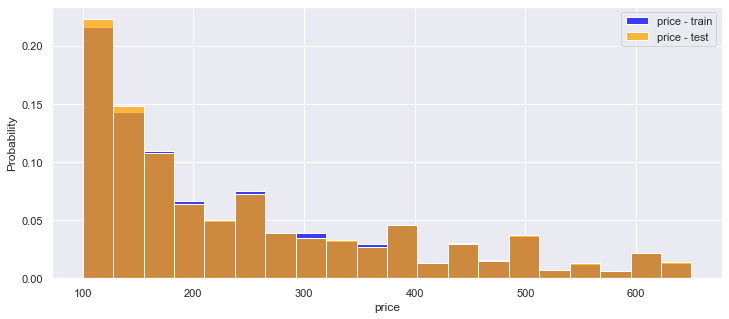

In [28]:
#check that the price distribution is also consistent:
plt.figure(figsize=(12,5))
sns.histplot(data=paintings_df_train,x='price',stat='probability',bins=20,color='blue')
sns.histplot(data=paintings_df_test,x='price',stat='probability',bins=20,color='orange')
plt.legend(['price - train','price - test'])

In [29]:
#I need to also rearrange the 'prices' numpy array, so that I can later trace back the corresponding rows in the dataframe
prices_train = prices[paintings_df_train.index]
prices_test = prices[paintings_df_test.index]

### Feature types

In [30]:
#Let's divide the columns (features) into different groups, as I will test different models with different combinations of features
numerical_columns = ['num_favorers','featured_rank','max_dimension','aspect_ratio','area','weight','days_from_original_creation'] 

categorical_columns = ['painting_type','when_made'] 

boolean_columns = ['made_by_seller','is_customizable','has_variations']

#the following are textual 'tags' that refer to style, materials (and some colors) or other tags that don't fall in either category
tag_columns = ['style_tags_new','materials_tags_new','tags_new']

#The following are 'free text' that are unlikely to be very predictive, but I could try to add them in future versions
text_columns = ['title','description']

##image info when available (for Options 3 or 5)
#image_columns = ['image_red','image_green','image_blue','image_hue','image_saturation','image_brightness']

#Finally, this is the identifier of the seller/artist that could be included in future versions:
user_column = ['shop_id']


### Baseline results picking the mean price of the paintings in the training set as my predictions

In [31]:
np.mean(prices_train)

247.31057473150634

In [32]:
trivial_price_pred_train = np.ones(len(prices_train)) * np.mean(prices_train)

In [33]:
trivial_price_pred_test = np.ones(len(prices_test)) * np.mean(prices_train)

In [34]:
#auxiliary function that will be used throughout to assess performance of different models:

from sklearn import metrics

def print_all_scores_train_test(y_train,y_train_pred,y_test,y_test_pred,model_name='Results'):
    print(model_name+':')
    print("Training R^2:", metrics.r2_score(y_train, y_train_pred))
    print("Testing R^2:", metrics.r2_score(y_test, y_test_pred))
    print("Training RMSE: USD", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print("Testing RMSE: USD", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
    print("Training MAE: USD", metrics.mean_absolute_error(y_train, y_train_pred))
    print("Testing MAE: USD", metrics.mean_absolute_error(y_test, y_test_pred))

print_all_scores_train_test(prices_train,trivial_price_pred_train,prices_test,trivial_price_pred_test,model_name='Trivial model using the mean price of the training set paintings')

Trivial model using the mean price of the training set paintings:
Training R^2: 0.0
Testing R^2: -4.194280976577147e-05
Training RMSE: USD 140.76932362561388
Testing RMSE: USD 142.14800650662107
Training MAE: USD 114.50826464244624
Testing MAE: USD 115.81658310644096


## 1) Models using only numerical features

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#I could select and scale at the same time:
numerical_scaler_selector = ColumnTransformer([
    ('numerical scaled (std)', StandardScaler(), numerical_columns),
], remainder='drop')

In [36]:
#But it's probably cleaner to keep the selector and the scaling separately, e.g. 
numerical_selector = ColumnTransformer([
    ('numerical', 'passthrough', numerical_columns),
], remainder='drop')

In [37]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

numerical_preproc_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('standard scaling', StandardScaler()),
])

### Model 1a) Linear regression using only numerical features

In [38]:
#This is a good start since it has no parameters to fit, and the solution is really fast to compute (no cross-validation, etc.)
from sklearn.linear_model import LinearRegression

numerical_linreg_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [39]:
#Let's visualize this pipeline:
from sklearn import set_config
set_config(display='diagram')

numerical_linreg_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation'])])),
                                 ('standard scaling', StandardScaler())])),
                ('linear reg', LinearRegression())])

In [40]:
#Train the model
numerical_linreg_pipe.fit(paintings_df_train,prices_train);

In [41]:
#Predict prices on training set:
prices_train_pred = numerical_linreg_pipe.predict(paintings_df_train)

In [42]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_train,prices_train)

0.15301805357824239

In [43]:
#Predict prices on test set:
prices_test_pred = numerical_linreg_pipe.predict(paintings_df_test)

In [44]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_test,prices_test)

0.16241954534706127

In [45]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only numerical features')

#Note that I am not overfitting the training data, since the model actually does better on test data

Linear regression model using only numerical features:
Training R^2: 0.15301805357824239
Testing R^2: 0.16241954534706127
Training RMSE: USD 129.55229193548735
Testing RMSE: USD 130.0903053513099
Training MAE: USD 102.25969814414985
Testing MAE: USD 102.51902023110482


Text(0, 0.5, 'predicted prices (test)')

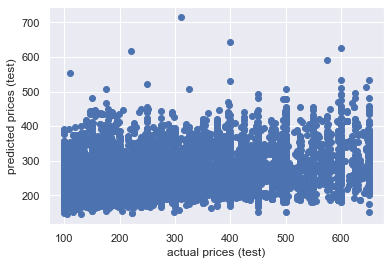

In [46]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

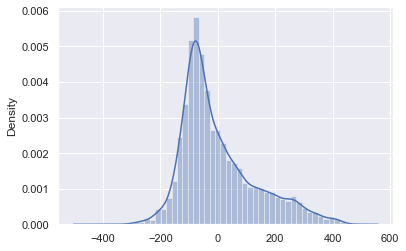

In [47]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [48]:
#Let's look at the coefficients of the model
# intercept
print(numerical_linreg_pipe['linear reg'].intercept_)

247.31057473150634


In [49]:
#coefficients for each variable:
coeff_df = pd.DataFrame(numerical_linreg_pipe['linear reg'].coef_,numerical_columns,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
num_favorers                     -0.833730
featured_rank                     5.771860
max_dimension                    25.879320
aspect_ratio                      4.306101
area                             22.808692
weight                           12.217222
days_from_original_creation       6.930578

In [50]:
#looks like area and max_dimension are the most informative numerical variables

### Model 1b) Ridge regression with polynomial terms using only numerical features

In [51]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

numerical_polyreg_ridge_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

numerical_polyreg_ridge_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=10))])

In [52]:
from sklearn.model_selection import GridSearchCV

#I will need to search for the right alpha using Cross Validation:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
numerical_polyreg_ridge_CVmodel = GridSearchCV(numerical_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=1, verbose=1)

In [53]:
numerical_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical preproc',
                                        Pipeline(steps=[('numerical selector',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          'passthrough',
                                                                                          ['num_favorers',
                                                                                           'featured_rank',
                                                                                           'max_dimension',
                                                                                           'aspect_ratio',
                                                                                           'area',
                                                                                           'weight',
                                                                                           'days_from_original_creation'])])),
                                                        ('standard scaling',
                                                         StandardScaler())])),
                                       ('polynomial_trans',
                                        PolynomialFeatur...
             n_jobs=1,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [54]:
numerical_polyreg_ridge_CVmodel.best_params_

{'ridge__alpha': 885.8667904100823}

In [55]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.18094450431612985

In [56]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.17707212206228673

In [57]:
print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial Ridge regression model using only numerical features')

Polynomial Ridge regression model using only numerical features:
Training R^2: 0.18094450431612985
Testing R^2: 0.17707212206228673
Training RMSE: USD 127.39860960318742
Testing RMSE: USD 128.94738920145667
Training MAE: USD 100.4619737634836
Testing MAE: USD 101.15915034605676


Text(0, 0.5, 'predicted prices (test)')

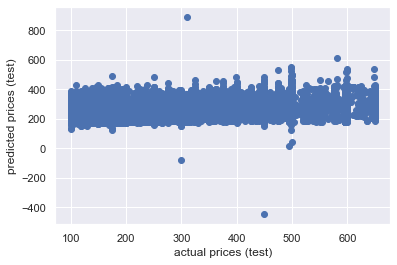

In [58]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

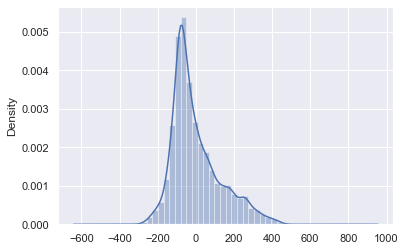

In [59]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [60]:
### The ridge regression model with polynomial features improves only marginally the perfrmance of the 
# basic linear regression model, which is also going to be much more interpretable. 
#So I keep that as my best linear-kind model for numerical only variables and I save it (unless already done so earlier)

In [61]:
#I will save the model after fitting the model the first time, then I will load it from memory the following times

from dill import dump, load

numerical_linreg_pipe_filename = './Git_exclude/models/numerical_linreg_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(numerical_linreg_pipe_filename, 'rb') as f:
        numerical_linreg_pipe = load(f)
        print('Loaded pickle file with numerical-only linear regression.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    numerical_linreg_pipe.fit(paintings_df_train,prices_train);
    
    with open(numerical_linreg_pipe_filename, 'wb') as f:
        dump(numerical_linreg_pipe, f, recurse=True) 
    print('Saved pickle file with numerical-only linear regression.')


Loaded pickle file with numerical-only linear regression.


#### Model 1c) Decision tree using only numerical features

In [62]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot

In [63]:
# #Recall that I already have the numerical selector, which need not change:
# numerical_selector = ColumnTransformer([
#     ('numerical', 'passthrough', numerical_columns),
# ], remainder='drop')

In [64]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

numerical_dtree_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3,min_samples_leaf=10)),
])

In [65]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,12,1)} 
numerical_dtree_CVmodel = GridSearchCV(numerical_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [66]:
numerical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   14.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical selector',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3,
                                                              min_samples_leaf=10))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 12)},
             verbose=1)

In [67]:
numerical_dtree_CVmodel.best_params_['dtree__max_depth']

11

In [68]:
#Predict prices on training set:
prices_train_pred = numerical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.3033984708692985

In [69]:
#Predict prices on test set:
prices_test_pred = numerical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.24767143198630648

In [70]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only numerical features')


Decision Tree model using only numerical features:
Training R^2: 0.3033984708692985
Testing R^2: 0.24767143198630648
Training RMSE: USD 117.48981923832842
Testing RMSE: USD 123.29215473696851
Training MAE: USD 89.1628681191306
Testing MAE: USD 93.47269256949315


In [71]:
#what are the main features used for decision?
numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.01506456, 0.01387781, 0.42867201, 0.06393624, 0.17154231,
       0.17581184, 0.13109523])

In [72]:
feature_names_num_dtree = numerical_dtree_CVmodel.best_estimator_['numerical selector'].get_feature_names()

numerical_dtree_features_imp_df = pd.DataFrame(numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_dtree,columns=['Dtree feature importance'])
numerical_dtree_features_imp_df = numerical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
numerical_dtree_features_imp_df

Dtree feature importance
max_dimension                                0.428672
weight                                       0.175812
area                                         0.171542
days_from_original_creation                  0.131095
aspect_ratio                                 0.063936
num_favorers                                 0.015065
featured_rank                                0.013878

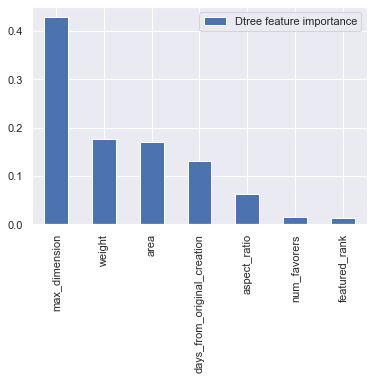

In [73]:
numerical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

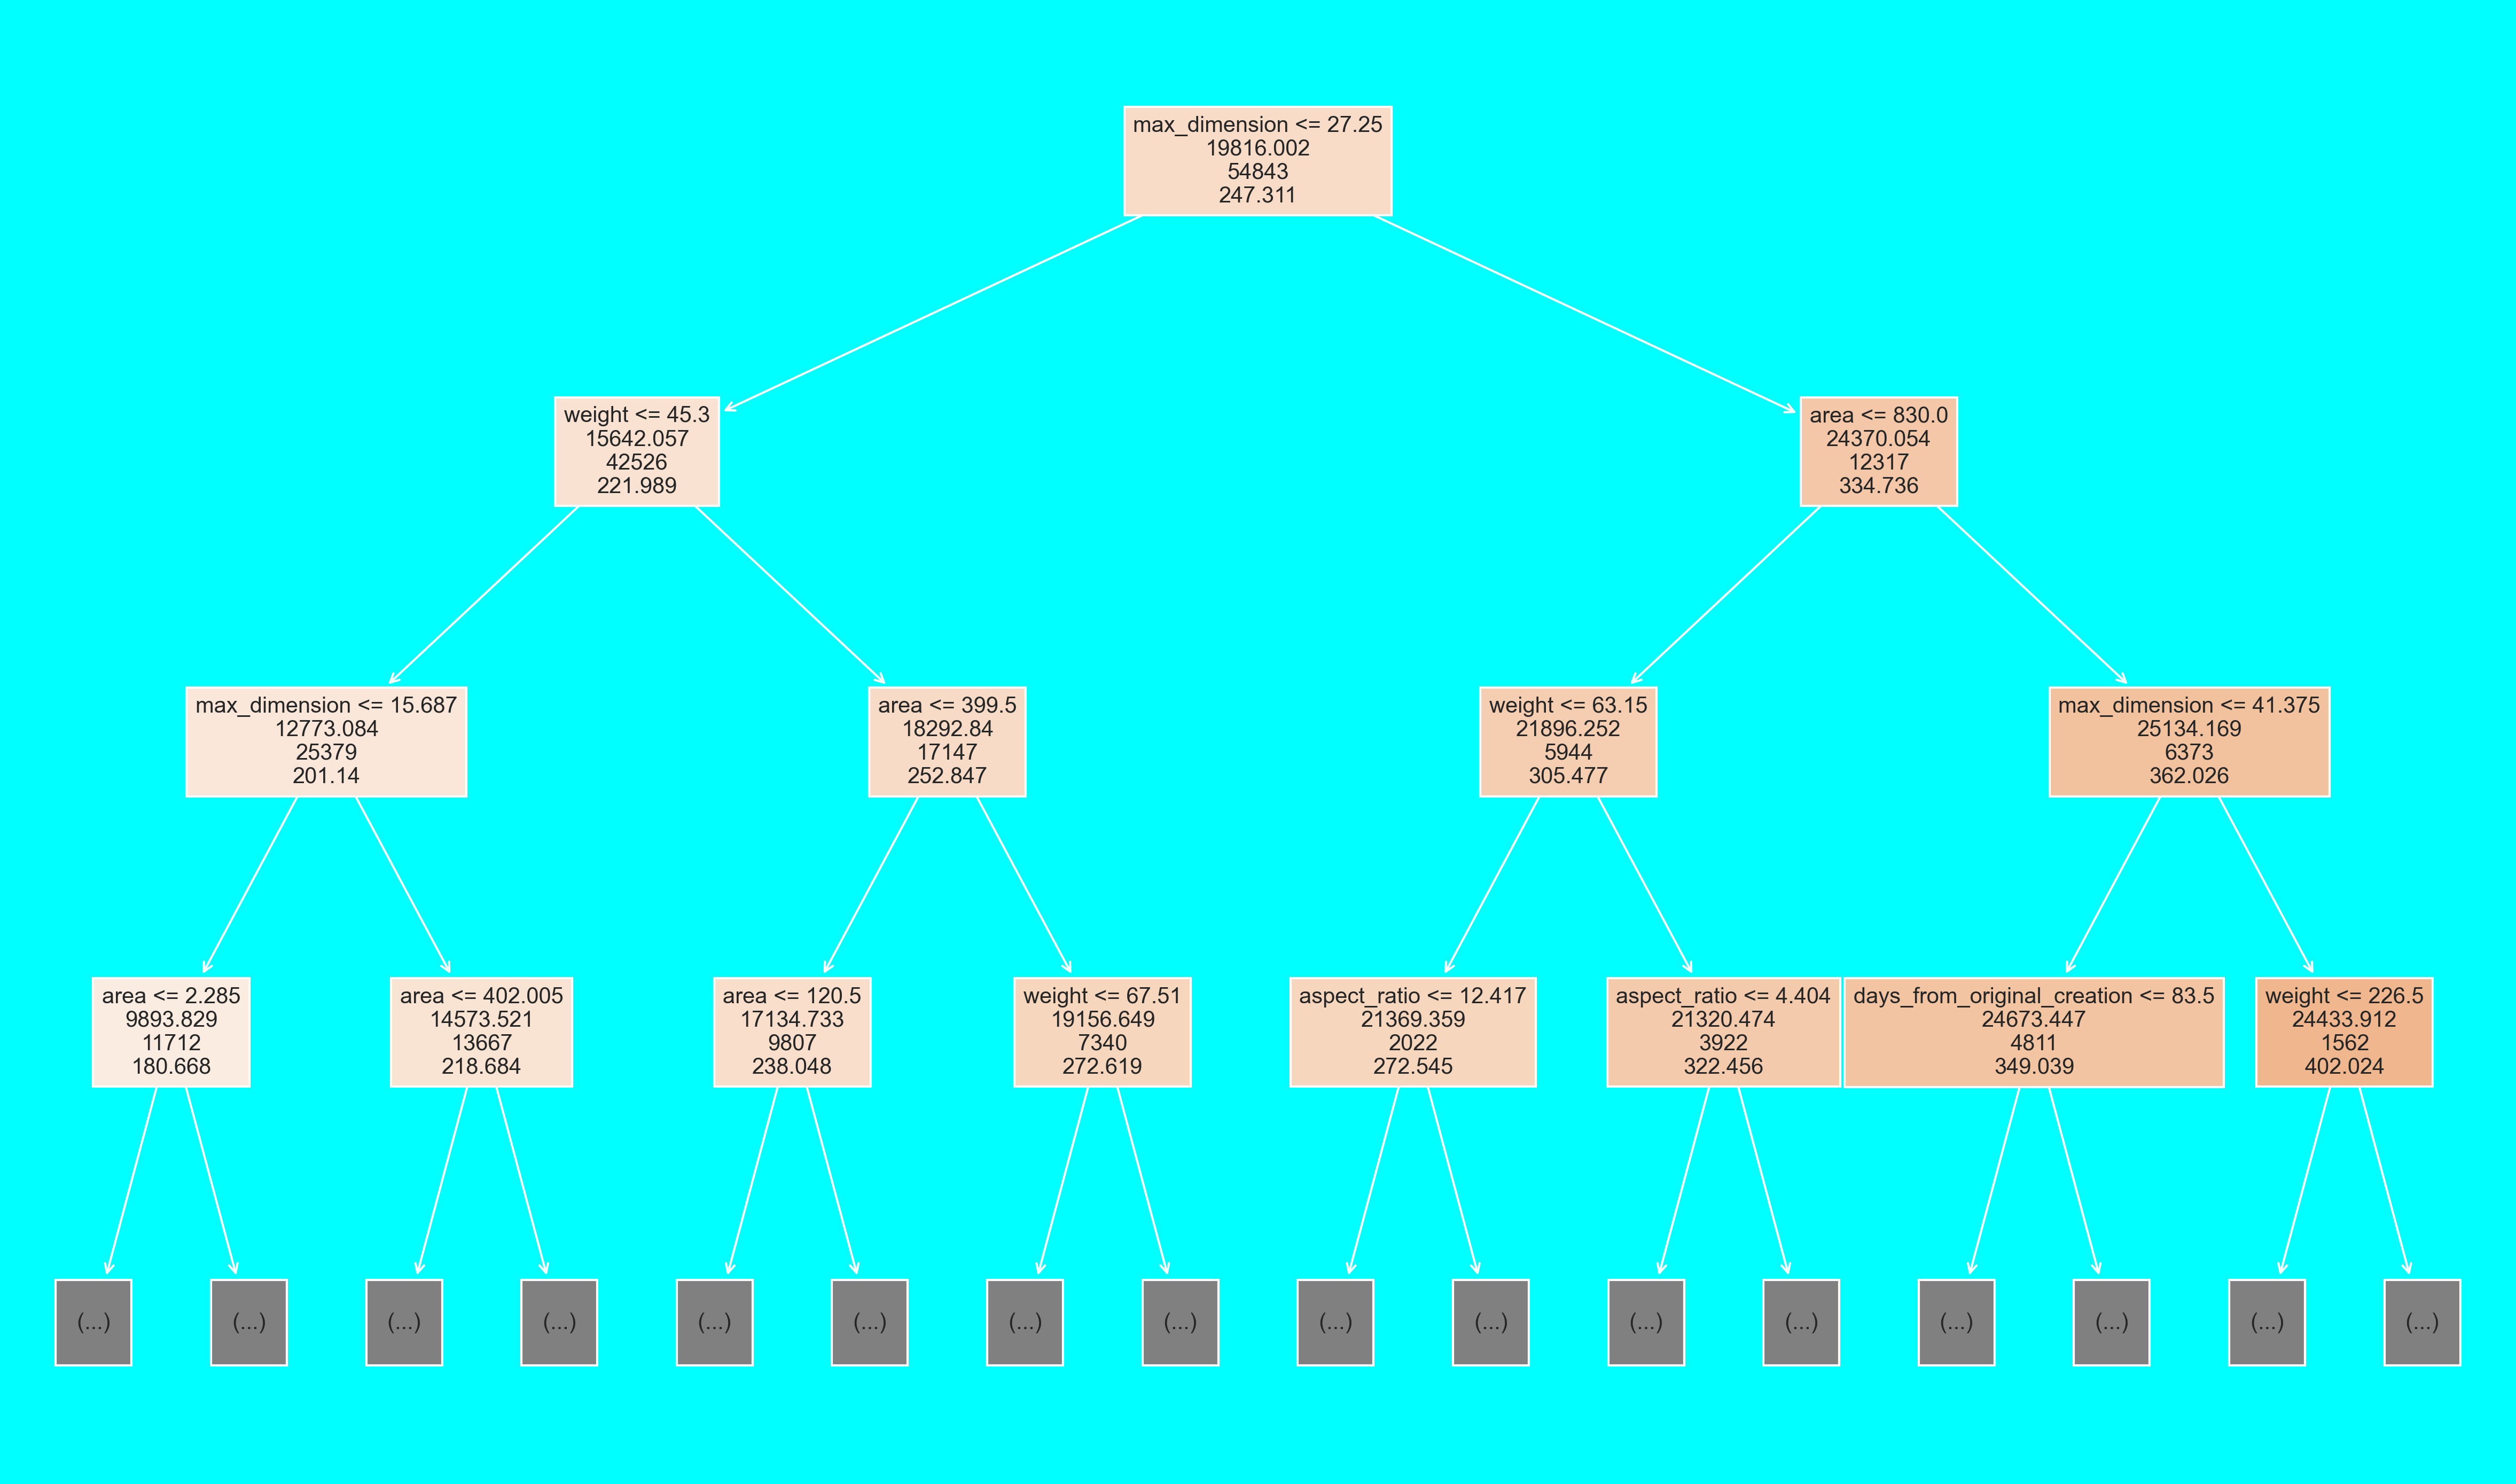

In [74]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(numerical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='none',filled=True,feature_names = feature_names_num_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_only.png')

#### Model 1d) Random Forest using only numerical features

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
numerical_rforest_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('rforest', RandomForestRegressor(n_estimators=20,max_features='sqrt',n_jobs=2,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [77]:
numerical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=12, max_features='sqrt',
                                       max_samples=0.8, min_samples_leaf=10,
                                       n_estimators=20, n_jobs=2,
                                       random_state=1))])

In [78]:
#Predict prices on training set:
prices_train_pred = numerical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_train,prices_train)

0.3152617605374768

In [79]:
#Predict prices on test set:
prices_test_pred = numerical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_test,prices_test)

0.27904564705534385

In [80]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only numerical features')


Random Forest model using only numerical features:
Training R^2: 0.3152617605374768
Testing R^2: 0.27904564705534396
Training RMSE: USD 116.48508336795977
Testing RMSE: USD 120.6939636819532
Training MAE: USD 89.85528463052538
Testing MAE: USD 92.84035997674575


In [81]:
#what are the main features used for decision?
numerical_rforest_pipe['rforest'].feature_importances_

array([0.03851915, 0.01506264, 0.30398329, 0.07811476, 0.27565168,
       0.1762523 , 0.11241616])

In [82]:
feature_names_num_rforest = numerical_rforest_pipe['numerical selector'].get_feature_names()

numerical_rforest_features_imp_df = pd.DataFrame(numerical_rforest_pipe['rforest'].feature_importances_,feature_names_num_rforest,columns=['Rforest feature importance'])
numerical_rforest_features_imp_df = numerical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
numerical_rforest_features_imp_df

Rforest feature importance
max_dimension                                  0.303983
area                                           0.275652
weight                                         0.176252
days_from_original_creation                    0.112416
aspect_ratio                                   0.078115
num_favorers                                   0.038519
featured_rank                                  0.015063

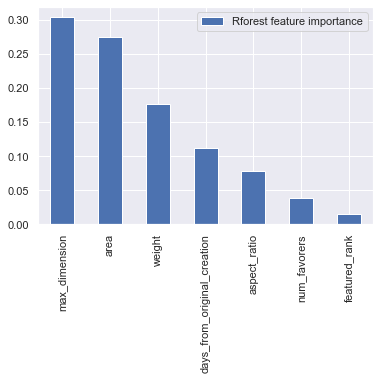

In [83]:
numerical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 1e) Gradient Boosting Trees using only numerical features¶

In [84]:
from sklearn.ensemble import GradientBoostingRegressor

In [85]:
numerical_gboost_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1,min_samples_leaf=10))
])

In [86]:
numerical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=10, min_samples_leaf=10,
                                           n_estimators=50, random_state=1,
                                           subsample=0.5))])

In [87]:
#Predict prices on training set:
prices_train_pred = numerical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_train,prices_train)

0.39793900976179564

In [88]:
#Predict prices on test set:
prices_test_pred = numerical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_test,prices_test)

0.3046005317642839

In [89]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only numerical features')


Gradient Boosting model using only numerical features:
Training R^2: 0.39793900976179564
Testing R^2: 0.3046005317642839
Training RMSE: USD 109.22656303329727
Testing RMSE: USD 118.53561110853678
Training MAE: USD 83.30746686014447
Testing MAE: USD 90.25211897651513


In [90]:
#what are the main features used for decision?
numerical_gboost_pipe['gboost'].feature_importances_

array([0.06288635, 0.01932914, 0.28129901, 0.08902687, 0.16160047,
       0.16990809, 0.21595008])

In [91]:
feature_names_num_gboost = numerical_gboost_pipe['numerical selector'].get_feature_names()

numerical_gboost_features_imp_df = pd.DataFrame(numerical_gboost_pipe['gboost'].feature_importances_,feature_names_num_gboost,columns=['Gboost feature importance'])
numerical_gboost_features_imp_df = numerical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
numerical_gboost_features_imp_df

Gboost feature importance
max_dimension                                 0.281299
days_from_original_creation                   0.215950
weight                                        0.169908
area                                          0.161600
aspect_ratio                                  0.089027
num_favorers                                  0.062886
featured_rank                                 0.019329

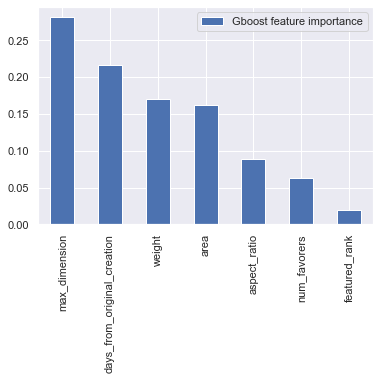

In [92]:
numerical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 2) Models using only categorical (and boolean) features

In [93]:
#I create a custom regressor to assess some 'baseline' model based on the 'painting_type' categorical feature: 
#how good is a model where I just return the mean price for all paintings of that category (e.g. all watercolors)? 

In [94]:
#Note that a sklearn Regressor takes numpy arrays - not dictionaries - but if I use a ColumnTransformer before the regressor I am fine

In [95]:
painting_type_selector = ColumnTransformer([
    ('categorical', 'passthrough', ['painting_type']),
], remainder='drop')

In [96]:
#check that the output is a 2Darray
temp = painting_type_selector.fit_transform(paintings_df_train)

In [97]:
for listing in temp[:3]:
    print(listing)

['acrylic']
['acrylic']
['oil']


#### 2a) Baseline model using the mean price of paintings of each type

In [98]:
from sklearn.base import BaseEstimator, RegressorMixin

import numpy as np
from collections import defaultdict

class CategoricalMeanRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_price = dict()
    
    def fit(self, X, y):
        # Store the average price per categorical feature in self.avg_price
        price_sum = defaultdict(int)
        count = defaultdict(int)
 
        for listing, price in zip(X, y):
            # increment the running sum in price_sum
            price_sum[listing[0]]+=price
            # increment the running count in count
            count[listing[0]]+=1
        
        for category in price_sum:
            self.avg_price[category]=price_sum[category]/count[category]
               
        return self
    
    def predict(self, X):
        predictions = np.zeros(len(X))
        
        for idx, listing in enumerate(X):
            if listing[0] in self.avg_price.keys():
                predictions[idx]=self.avg_price[listing[0]]
        
        return predictions

In [99]:
#Let's create a pipeline to apply the above "regressor" to the 'painting_type' column

from sklearn.pipeline import Pipeline

painting_type_mean_pipe = Pipeline([
    ('painting type selector', painting_type_selector),
    ('mean of painting_type', CategoricalMeanRegressor()),
])

In [100]:
painting_type_mean_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('painting type selector',
                 ColumnTransformer(transformers=[('categorical', 'passthrough',
                                                  ['painting_type'])])),
                ('mean of painting_type', CategoricalMeanRegressor())])

In [101]:
painting_type_mean_pipe[-1].avg_price

{'acrylic': 234.61577654790995,
 'oil': 284.5090095962385,
 'watercolor': 213.75605991883472,
 'more_than_one': 246.04279339695617}

In [102]:
#Check the results are right:
paintings_df_train.groupby(by='painting_type').mean()

listing_id       user_id       shop_id  shop_section_id  \
painting_type                                                              
acrylic        8.368579e+08  1.538163e+08  1.760321e+07     2.635560e+07   
more_than_one  7.860339e+08  1.227163e+08  1.545193e+07     2.486947e+07   
oil            8.248457e+08  1.212292e+08  1.508390e+07     2.408944e+07   
watercolor     8.065606e+08  1.231181e+08  1.547952e+07     2.488134e+07   

               featured_rank  num_favorers  is_customizable  \
painting_type                                                 
acrylic            -0.296207      8.534494         0.119797   
more_than_one       0.121744     12.508383         0.139025   
oil                 1.081417     13.098980         0.121432   
watercolor          0.498687     13.153617         0.190260   

               shipping_profile_id  has_variations       price  taxonomy_id  \
painting_type                                                                 
acrylic               9.179736e+10        0.107767  234.615777   106.000000   
more_than_one         8.202767e+10        0.104204  246.042793   109.214083   
oil                   8.034883e+10        0.117086  284.509010   112.000000   
watercolor            7.952441e+10        0.201838  213.756060   114.000000   

               max_dimension        area  aspect_ratio     weight  \
painting_type                                                       
acrylic            23.272763  446.114022      1.586626  59.784426   
more_than_one      23.014622  456.100809      1.560058  70.176796   
oil                22.492054  437.207656      1.478971  69.342672   
watercolor         17.949234  265.594636      1.563859  33.524685   

               days_from_original_creation  made_by_seller  
painting_type                                               
acrylic                         656.999846        0.945386  
more_than_one                   810.737942        0.862523  
oil                             693.768845        0.755085  
watercolor                      752.584507        0.857006

In [103]:
#Now I am ready to assess the performance of this model:
prices_pred_train = painting_type_mean_pipe.predict(paintings_df_train)
prices_pred_test = painting_type_mean_pipe.predict(paintings_df_test)

In [104]:
print_all_scores_train_test(prices_train,prices_pred_train,prices_test,prices_pred_test,model_name='Trivial model using the mean price of the paintings of same type in the training set')

Trivial model using the mean price of the paintings of same type in the training set:
Training R^2: 0.03364022124029076
Testing R^2: 0.0387022251672694
Training RMSE: USD 138.38131292442947
Testing RMSE: USD 139.36721913629634
Training MAE: USD 112.20255395284957
Testing MAE: USD 113.01600923649475


In [105]:
#Select the categorical features (defined earlier) and apply OneHotEncoding to all of them - 
#for now I drop the first column since I will try LinearRegression and want to avoid multi-collinearity
#Separately, pass through the boolean variables

In [106]:
from sklearn.preprocessing import OneHotEncoder

categorical_selector = ColumnTransformer([
     ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
 ], remainder='drop')

In [107]:
categorical_selector.fit_transform(paintings_df_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

In [108]:
categorical_feature_names = categorical_selector.get_feature_names()

#### Model 2b) Linear regression using only categorical features

In [109]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

categorical_linreg_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('linear reg', LinearRegression()),
])


In [110]:
#Train the model
categorical_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('linear reg', LinearRegression())])

In [111]:
#Predict prices on training set:
prices_train_pred = categorical_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_train,prices_train)

0.04766038974853348

In [112]:
#Predict prices on test set:
prices_test_pred = categorical_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_test,prices_test)

0.050458332714103826

In [113]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only categorical features with One-hot-encoding')


Linear regression model using only categorical features with One-hot-encoding:
Training R^2: 0.04766038974853348
Testing R^2: 0.050458332714103826
Training RMSE: USD 137.37381145197747
Testing RMSE: USD 138.51240799334178
Training MAE: USD 110.8477719612572
Testing MAE: USD 111.77804664630203


In [114]:
#Let's look at the coefficients of the model
# intercept
print(categorical_linreg_pipe['linear reg'].intercept_)

251.42363687170666


In [115]:
categorical_linreg_pipe['linear reg'].coef_

array([  9.01220948,  46.30239599, -22.9820757 , -27.82138366,
       -10.08031659, -35.44404497,  -1.36601678,  29.16551168,
        -1.43606668])

In [116]:
#coefficients for each variable:
coeff_df = pd.DataFrame(categorical_linreg_pipe['linear reg'].coef_,categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
categorical__x0_more_than_one          9.012209
categorical__x0_oil                   46.302396
categorical__x0_watercolor           -22.982076
categorical__x1_made_2020s           -27.821384
categorical__x1_made_before_2010     -10.080317
categorical__x1_made_to_order        -35.444045
made_by_seller                        -1.366017
is_customizable                       29.165512
has_variations                        -1.436067

### Model 2c) Decision Tree model using only categorical features

In [117]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
categorical_selector_no_drop = ColumnTransformer([
      ('categorical', OneHotEncoder(), categorical_columns),
     ('boolean','passthrough', boolean_columns),
  ], remainder='drop')

In [118]:
categorical_dtree_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('dtree', DecisionTreeRegressor(max_depth=3,min_samples_leaf=10)),
])

In [119]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} 
categorical_dtree_CVmodel = GridSearchCV(categorical_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [120]:
categorical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   10.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3,
                                                              min_samples_leaf=10))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [121]:
categorical_dtree_CVmodel.best_params_

{'dtree__max_depth': 10}

In [122]:
#Predict prices on training set:
prices_train_pred = categorical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.07304050694432429

In [123]:
#Predict prices on test set:
prices_test_pred = categorical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.07352041971865908

In [124]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only categorical features with One-hot-encoding')


Decision Tree model using only categorical features with One-hot-encoding:
Training R^2: 0.07304050694432429
Testing R^2: 0.07352041971865908
Training RMSE: USD 135.53092491273324
Testing RMSE: USD 136.82000181468726
Training MAE: USD 108.69256679521037
Testing MAE: USD 109.8627300109397


In [125]:
#what are the main features used for decision?
categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.01985649, 0.01029286, 0.4138681 , 0.04235228, 0.0894604 ,
       0.06445175, 0.00417939, 0.08041525, 0.07699149, 0.09627993,
       0.10185206])

In [126]:
feature_names_cat_dtree = categorical_dtree_CVmodel.best_estimator_['categorical selector'].get_feature_names()

categorical_dtree_features_imp_df = pd.DataFrame(categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_cat_dtree,columns=['Dtree feature importance'])
categorical_dtree_features_imp_df = categorical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
categorical_dtree_features_imp_df

Dtree feature importance
categorical__x0_oil                               0.413868
has_variations                                    0.101852
is_customizable                                   0.096280
categorical__x1_made_2010s                        0.089460
categorical__x1_made_to_order                     0.080415
made_by_seller                                    0.076991
categorical__x1_made_2020s                        0.064452
categorical__x0_watercolor                        0.042352
categorical__x0_acrylic                           0.019856
categorical__x0_more_than_one                     0.010293
categorical__x1_made_before_2010                  0.004179

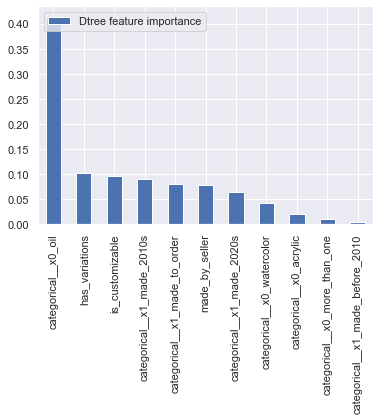

In [127]:
categorical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper left");

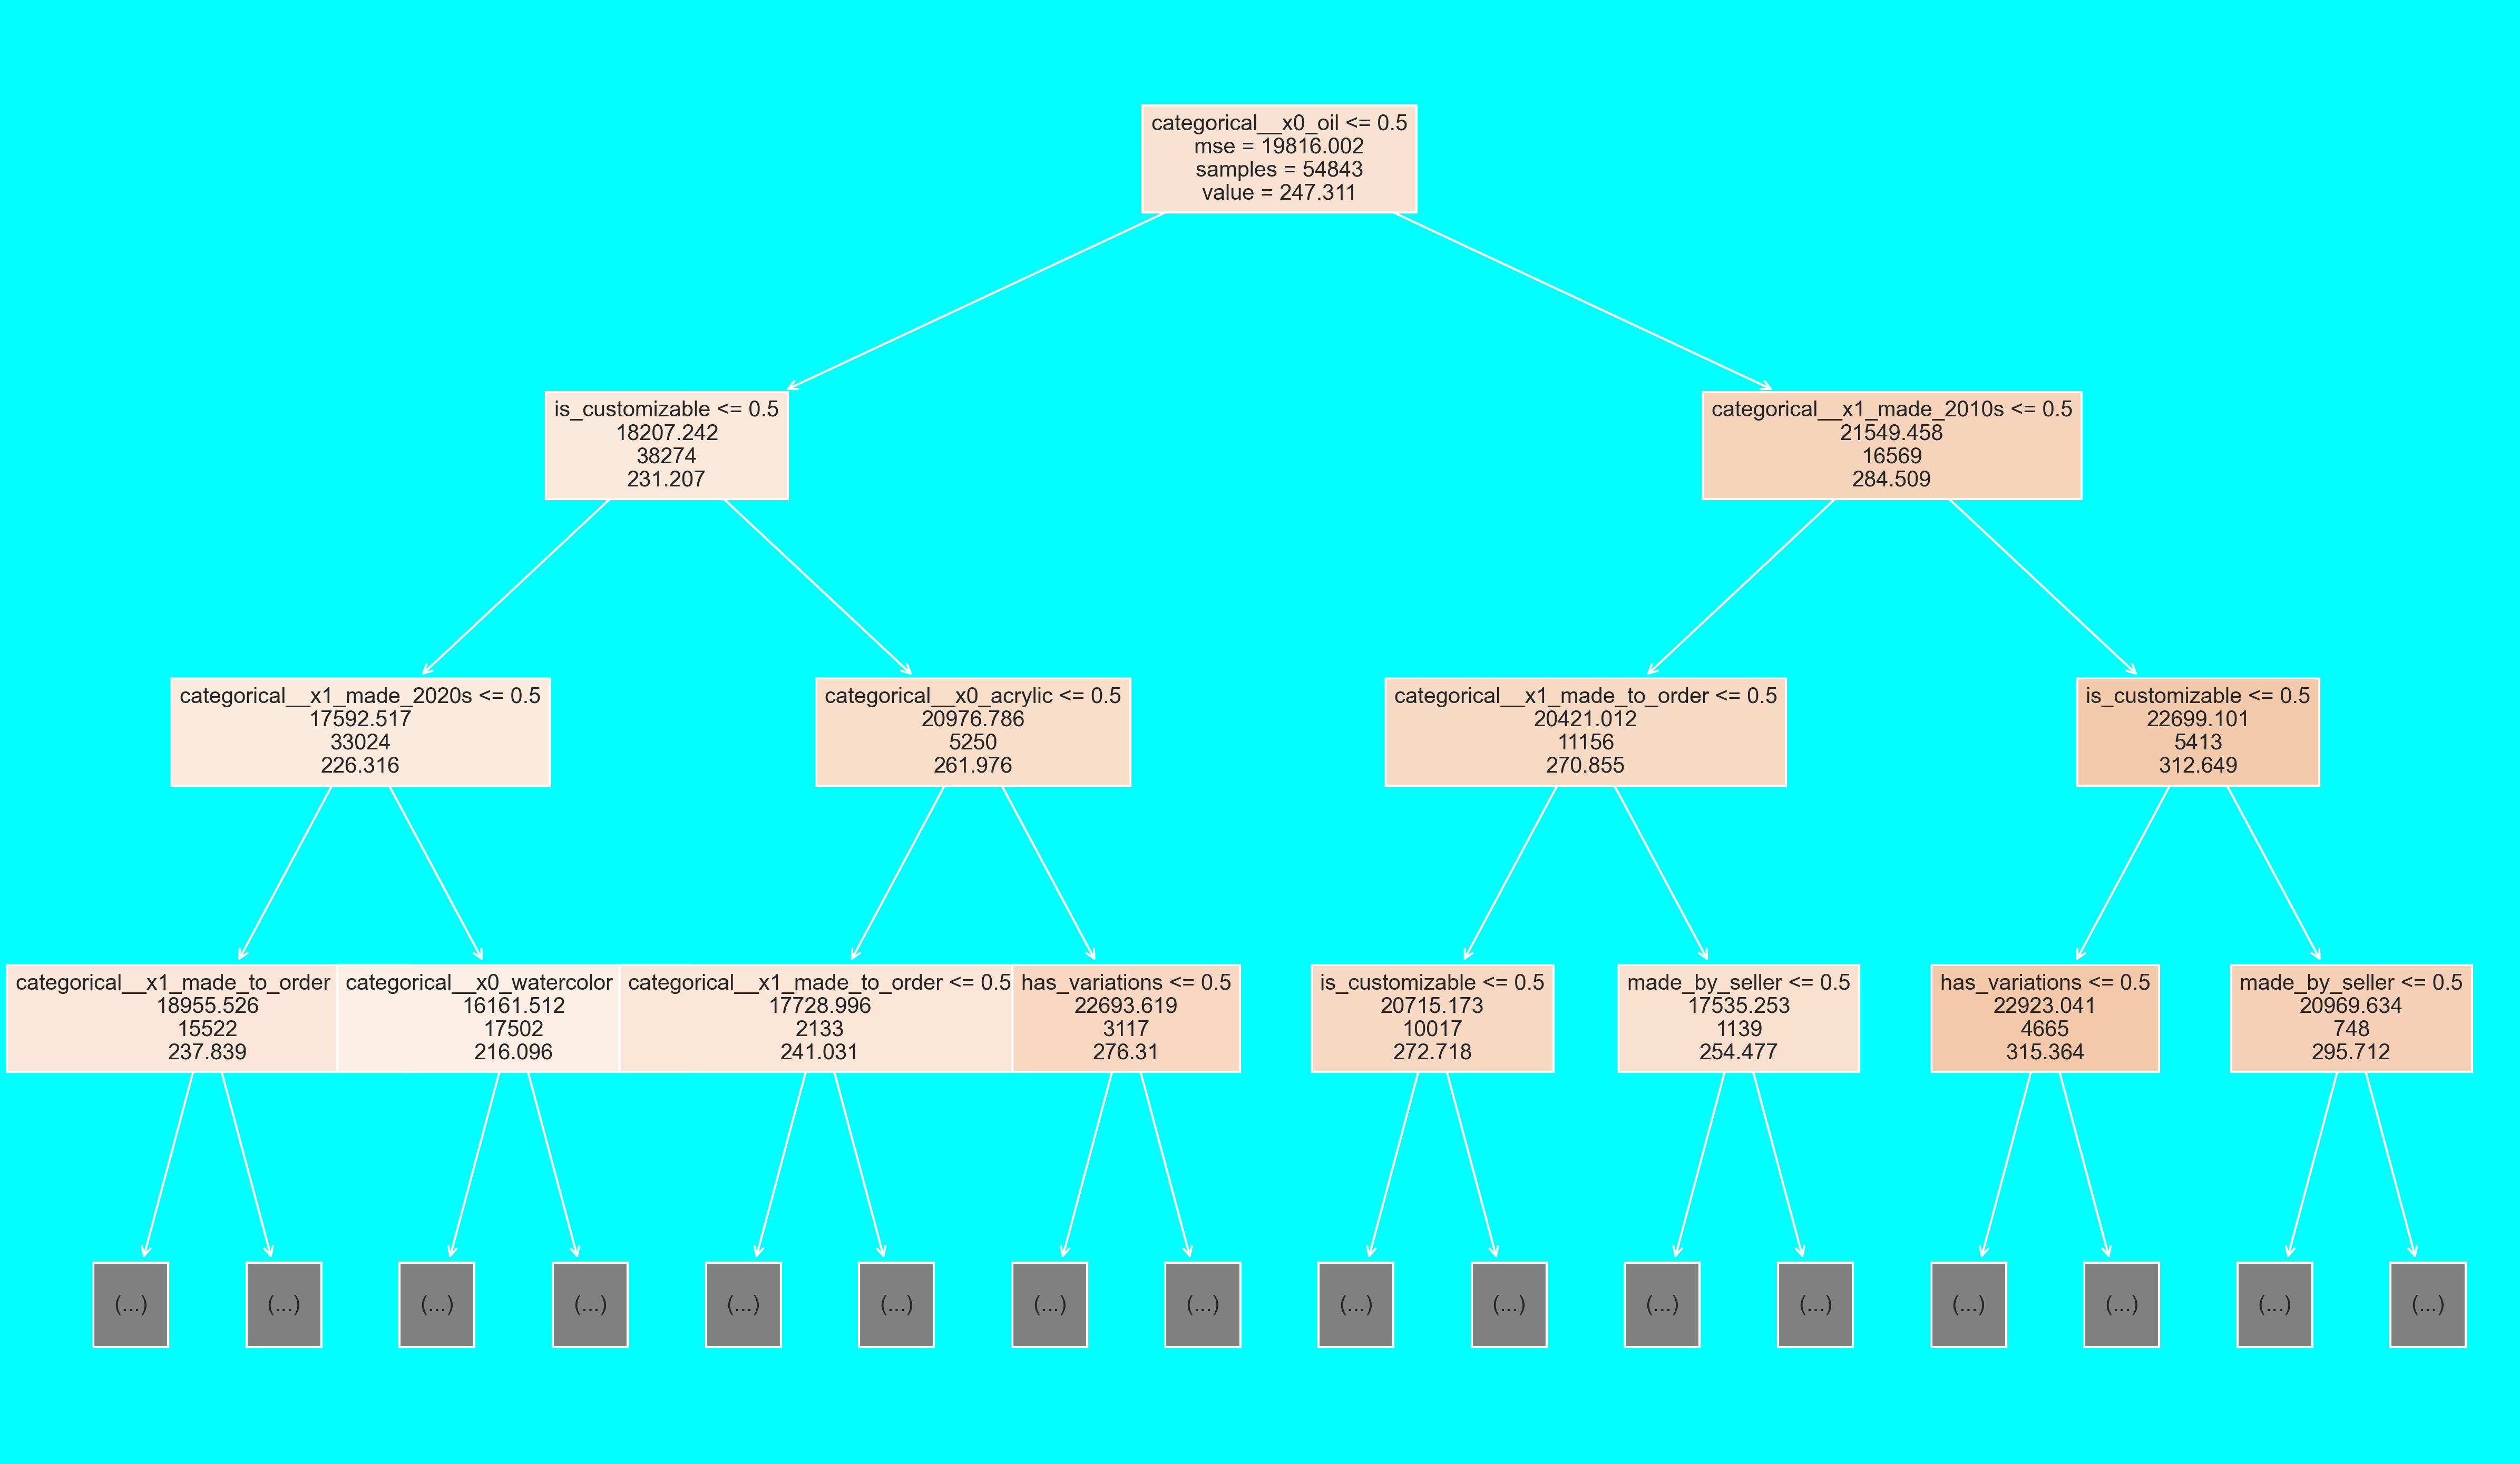

In [128]:
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(categorical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_categorical_only.png')

#### Model 2d) Random Forest using only categorical features

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
categorical_rforest_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [131]:
categorical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=11, max_features='sqrt',
                                       max_samples=0.8, min_samples_leaf=10,
                                       n_estimators=50, n_jobs=2,
                                       random_state=1))])

In [132]:
#Predict prices on training set:
prices_train_pred = categorical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_train,prices_train)

0.07276012970481949

In [133]:
#Predict prices on test set:
prices_test_pred = categorical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_test,prices_test)

0.07444460971872302

In [134]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only categorical features')


Random Forest model using only categorical features:
Training R^2: 0.07276012970481949
Testing R^2: 0.07444460971872302
Training RMSE: USD 135.55142036796448
Testing RMSE: USD 136.75174384672263
Training MAE: USD 108.7969230735439
Testing MAE: USD 109.87582031307679


In [135]:
#what are the main features used for decision?
categorical_rforest_pipe['rforest'].feature_importances_

array([0.06744429, 0.02868011, 0.31963062, 0.09468249, 0.08356783,
       0.06059185, 0.03662731, 0.03102586, 0.06645312, 0.12712496,
       0.08417157])

In [136]:
feature_names_cat_rforest = categorical_rforest_pipe['categorical selector'].get_feature_names()

categorical_rforest_features_imp_df = pd.DataFrame(categorical_rforest_pipe['rforest'].feature_importances_,feature_names_cat_rforest,columns=['Rforest feature importance'])
categorical_rforest_features_imp_df = categorical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
categorical_rforest_features_imp_df

Rforest feature importance
categorical__x0_oil                                 0.319631
is_customizable                                     0.127125
categorical__x0_watercolor                          0.094682
has_variations                                      0.084172
categorical__x1_made_2010s                          0.083568
categorical__x0_acrylic                             0.067444
made_by_seller                                      0.066453
categorical__x1_made_2020s                          0.060592
categorical__x1_made_before_2010                    0.036627
categorical__x1_made_to_order                       0.031026
categorical__x0_more_than_one                       0.028680

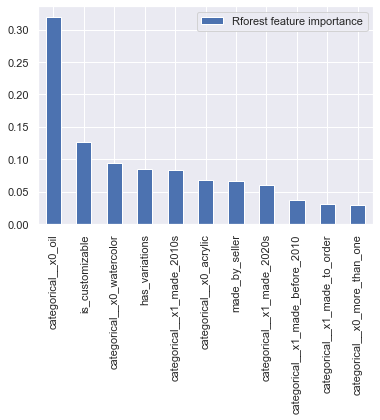

In [137]:
categorical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 2e) Gradient Boosting Trees using only numerical features¶

In [138]:
from sklearn.ensemble import GradientBoostingRegressor

In [139]:
categorical_gboost_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1,min_samples_leaf=10))
])

In [140]:
categorical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=9, min_samples_leaf=10,
                                           n_estimators=50, random_state=1,
                                           subsample=0.5))])

In [141]:
#Predict prices on training set:
prices_train_pred = categorical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_train,prices_train)

0.07353583807480013

In [142]:
#Predict prices on test set:
prices_test_pred = categorical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_test,prices_test)

0.0740663196437803

In [143]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only categorical features')


Gradient Boosting model using only categorical features:
Training R^2: 0.07353583807480013
Testing R^2: 0.0740663196437803
Training RMSE: USD 135.4947088442717
Testing RMSE: USD 136.77968736211574
Training MAE: USD 108.70224464133824
Testing MAE: USD 109.86845545478417


In [144]:
#what are the main features used for decision?
categorical_gboost_pipe['gboost'].feature_importances_

array([0.04328547, 0.35599999, 0.07159912, 0.08286823, 0.06169842,
       0.09274407, 0.07530585, 0.10672538, 0.10977348])

In [145]:
feature_names_cat_gboost = categorical_gboost_pipe['categorical selector'].get_feature_names()

categorical_gboost_features_imp_df = pd.DataFrame(categorical_gboost_pipe['gboost'].feature_importances_,feature_names_cat_gboost,columns=['Gboost feature importance'])
categorical_gboost_features_imp_df = categorical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
categorical_gboost_features_imp_df

Gboost feature importance
categorical__x0_oil                                0.356000
has_variations                                     0.109773
is_customizable                                    0.106725
categorical__x1_made_to_order                      0.092744
categorical__x1_made_2020s                         0.082868
made_by_seller                                     0.075306
categorical__x0_watercolor                         0.071599
categorical__x1_made_before_2010                   0.061698
categorical__x0_more_than_one                      0.043285

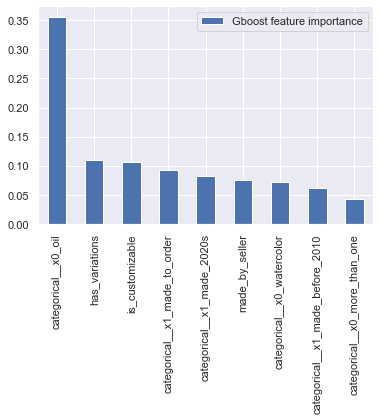

In [146]:
categorical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 3) Models combining numerical and categorical features, but still no tags or image info

#### 3a) Linear regression combining numerical and categorical features

In [147]:
#Note that I need to scale the numerical features, using MinMaxScaling or StandardScaling, 
#to prevent them from dominating the categorical ones (that are always in [0,1] range by construction)
#Also recall that for Linear Regression I need to drop the first hot-encoded value or I will have multicollinearity problems

variable_selector = ColumnTransformer([
    ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns) #('numerical',StandardScaler(),numerical_columns)
 ], remainder='drop')



In [148]:
#and then apply LinearRegression within a pipeline
from sklearn.pipeline import Pipeline

num_plus_cat_linreg_pipe = Pipeline([
    ('variable selector', variable_selector),
    ('linear reg', LinearRegression()),
])

In [149]:
#Train the model
num_plus_cat_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('variable selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('linear reg', LinearRegression())])

In [150]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_train,prices_train)

0.19270701990826378

In [151]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_test,prices_test)

0.2039834223502186

In [152]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using numerical features and categorical features with One-hot-encoding')


Linear regression model using numerical features and categorical features with One-hot-encoding:
Training R^2: 0.19270701990826378
Testing R^2: 0.2039834223502186
Training RMSE: USD 126.48051111041187
Testing RMSE: USD 126.82145226334316
Training MAE: USD 98.93718732974651
Testing MAE: USD 98.94717940499362


In [153]:
#Let's look at the coefficients of the model
# intercept
print(num_plus_cat_linreg_pipe['linear reg'].intercept_)

101.51747867562744


In [154]:
num_plus_cat_linreg_pipe['linear reg'].coef_

array([  11.32588454,   55.98022471,   15.60750729,  -21.33244537,
         -9.49211287,  -34.31279077,   36.99805127,   18.48168585,
        -15.61552789, -119.66086549,  171.63362252,  225.12523301,
        199.29187889,  338.37704218, 1839.66901784,    2.27086505])

In [155]:
numerical_columns + categorical_feature_names

['num_favorers',
 'featured_rank',
 'max_dimension',
 'aspect_ratio',
 'area',
 'weight',
 'days_from_original_creation',
 'categorical__x0_more_than_one',
 'categorical__x0_oil',
 'categorical__x0_watercolor',
 'categorical__x1_made_2020s',
 'categorical__x1_made_before_2010',
 'categorical__x1_made_to_order',
 'made_by_seller',
 'is_customizable',
 'has_variations']

In [156]:
#coefficients for each variable:
coeff_df = pd.DataFrame(num_plus_cat_linreg_pipe['linear reg'].coef_,columns=['Lin Reg Coeff']) #categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
0       11.325885
1       55.980225
2       15.607507
3      -21.332445
4       -9.492113
5      -34.312791
6       36.998051
7       18.481686
8      -15.615528
9     -119.660865
10     171.633623
11     225.125233
12     199.291879
13     338.377042
14    1839.669018
15       2.270865

#### 3b) Ridge regression combining numerical and categorical features with polynomial features

In [157]:
#For Ridge Regression, I don't really need to 'drop-first' categorical variables when doing OneHotEncoding, because the ridge term already prevents the problem from being ill-posed  
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

variable_selector_for_ridge = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns) #('numerical',StandardScaler(),numerical_columns)
 ], remainder='drop')

In [158]:
from sklearn.linear_model import Ridge

num_plus_cat_polyreg_ridge_pipe = Pipeline([('num and cat preproc', variable_selector_for_ridge),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [159]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
num_plus_cat_polyreg_ridge_CVmodel = GridSearchCV(num_plus_cat_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [160]:
#Train the model - this takes a bit of time, so I will save the model after fitting the model the first time, 
#then I will load it from memory the following times

from dill import dump, load

num_plus_cat_polyreg_ridge_CVmodel_filename = './Git_exclude/models/num_plus_cat_polyreg_ridge_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'rb') as f:
        num_plus_cat_polyreg_ridge_CVmodel = load(f)
        print('Loaded pickle file with numerical-plus-categorical features, ridge regression with polynomial features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_polyreg_ridge_CVmodel, f, recurse=True) 
        print('Saved pickle file with numerical-plus-categorical features, ridge regression with polynomial features.')


Loaded pickle file with numerical-plus-categorical features, ridge regression with polynomial features.


In [161]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.21789351845992988

In [162]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.22648503489073502

In [163]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression using numerical and categorical features with polynomial features')


Ridge regression using numerical and categorical features with polynomial features:
Training R^2: 0.21789351845992988
Testing R^2: 0.22648503489073502
Training RMSE: USD 124.49186308004023
Testing RMSE: USD 125.01612290391965
Training MAE: USD 97.67231594600763
Testing MAE: USD 97.67033041382905


### Model 3c) Decision Tree model combining numerical and categorical features

In [164]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot

In [165]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
#and I don't need to scale the numerical variables

variable_selector_for_trees = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical','passthrough',numerical_columns)
 ], remainder='drop')

In [166]:
num_plus_cat_dtree_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=3,min_samples_leaf=10)),
])

In [167]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,12,1)} #np.linspace(0,10,1)} 
num_plus_cat_dtree_CVmodel = GridSearchCV(num_plus_cat_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [168]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

num_plus_cat_dtree_CVmodel_filename = './Git_exclude/models/num_plus_cat_dtree_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_dtree_CVmodel_filename, 'rb') as f:
        num_plus_cat_dtree_CVmodel = load(f)
        print('Loaded pickle file with decision tree model for numerical-plus-categorical features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_dtree_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_dtree_CVmodel, f, recurse=True) 
        print('Saved pickle file with decision tree model for numerical-plus-categorical features.')

Loaded pickle file with decision tree model for numerical-plus-categorical features.


In [169]:
num_plus_cat_dtree_CVmodel.best_params_

{'dtree__max_depth': 9}

In [170]:
num_plus_cat_dtree_CVmodel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('num and cat selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations']),
                                                                        ('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 12)},
             verbose=1)

In [171]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_train,prices_train)

0.34302576472085833

In [172]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_test,prices_test)

0.2907613802486635

In [173]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using numerical + categorical features')


Decision Tree model using numerical + categorical features:
Training R^2: 0.34302576472085833
Testing R^2: 0.2907613802486635
Training RMSE: USD 114.09909321135794
Testing RMSE: USD 119.7092896972183
Training MAE: USD 86.00995862307553
Testing MAE: USD 89.76515790276116


In [174]:
#what are the main features used for decision?
num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.00050899, 0.00964248, 0.08998735, 0.00603855, 0.02759729,
       0.0055966 , 0.012778  , 0.01495018, 0.02520422, 0.00859078,
       0.02104336, 0.01084724, 0.01393565, 0.36386737, 0.04805548,
       0.16837784, 0.12425914, 0.04871948])

In [175]:
feature_names_num_plus_cat_dtree = num_plus_cat_dtree_CVmodel.best_estimator_['num and cat selector'].get_feature_names()

num_plus_cat_dtree_features_imp_df = pd.DataFrame(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_plus_cat_dtree,columns=['Dtree feature importance'])
num_plus_cat_dtree_features_imp_df = num_plus_cat_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
num_plus_cat_dtree_features_imp_df

Dtree feature importance
max_dimension                                     0.363867
area                                              0.168378
weight                                            0.124259
categorical__x0_oil                               0.089987
days_from_original_creation                       0.048719
aspect_ratio                                      0.048055
categorical__x1_made_2010s                        0.027597
made_by_seller                                    0.025204
has_variations                                    0.021043
categorical__x1_made_to_order                     0.014950
featured_rank                                     0.013936
categorical__x1_made_before_2010                  0.012778
num_favorers                                      0.010847
categorical__x0_more_than_one                     0.009642
is_customizable                                   0.008591
categorical__x0_watercolor                        0.006039
categorical__x1_made_2020s                        0.005597
categorical__x0_acrylic                           0.000509

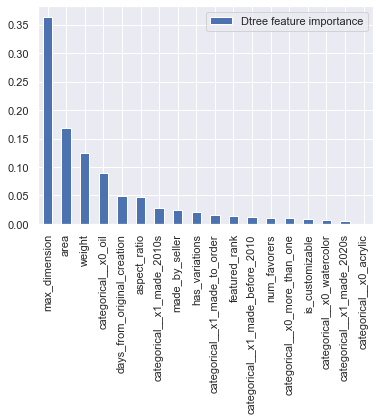

In [176]:
num_plus_cat_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

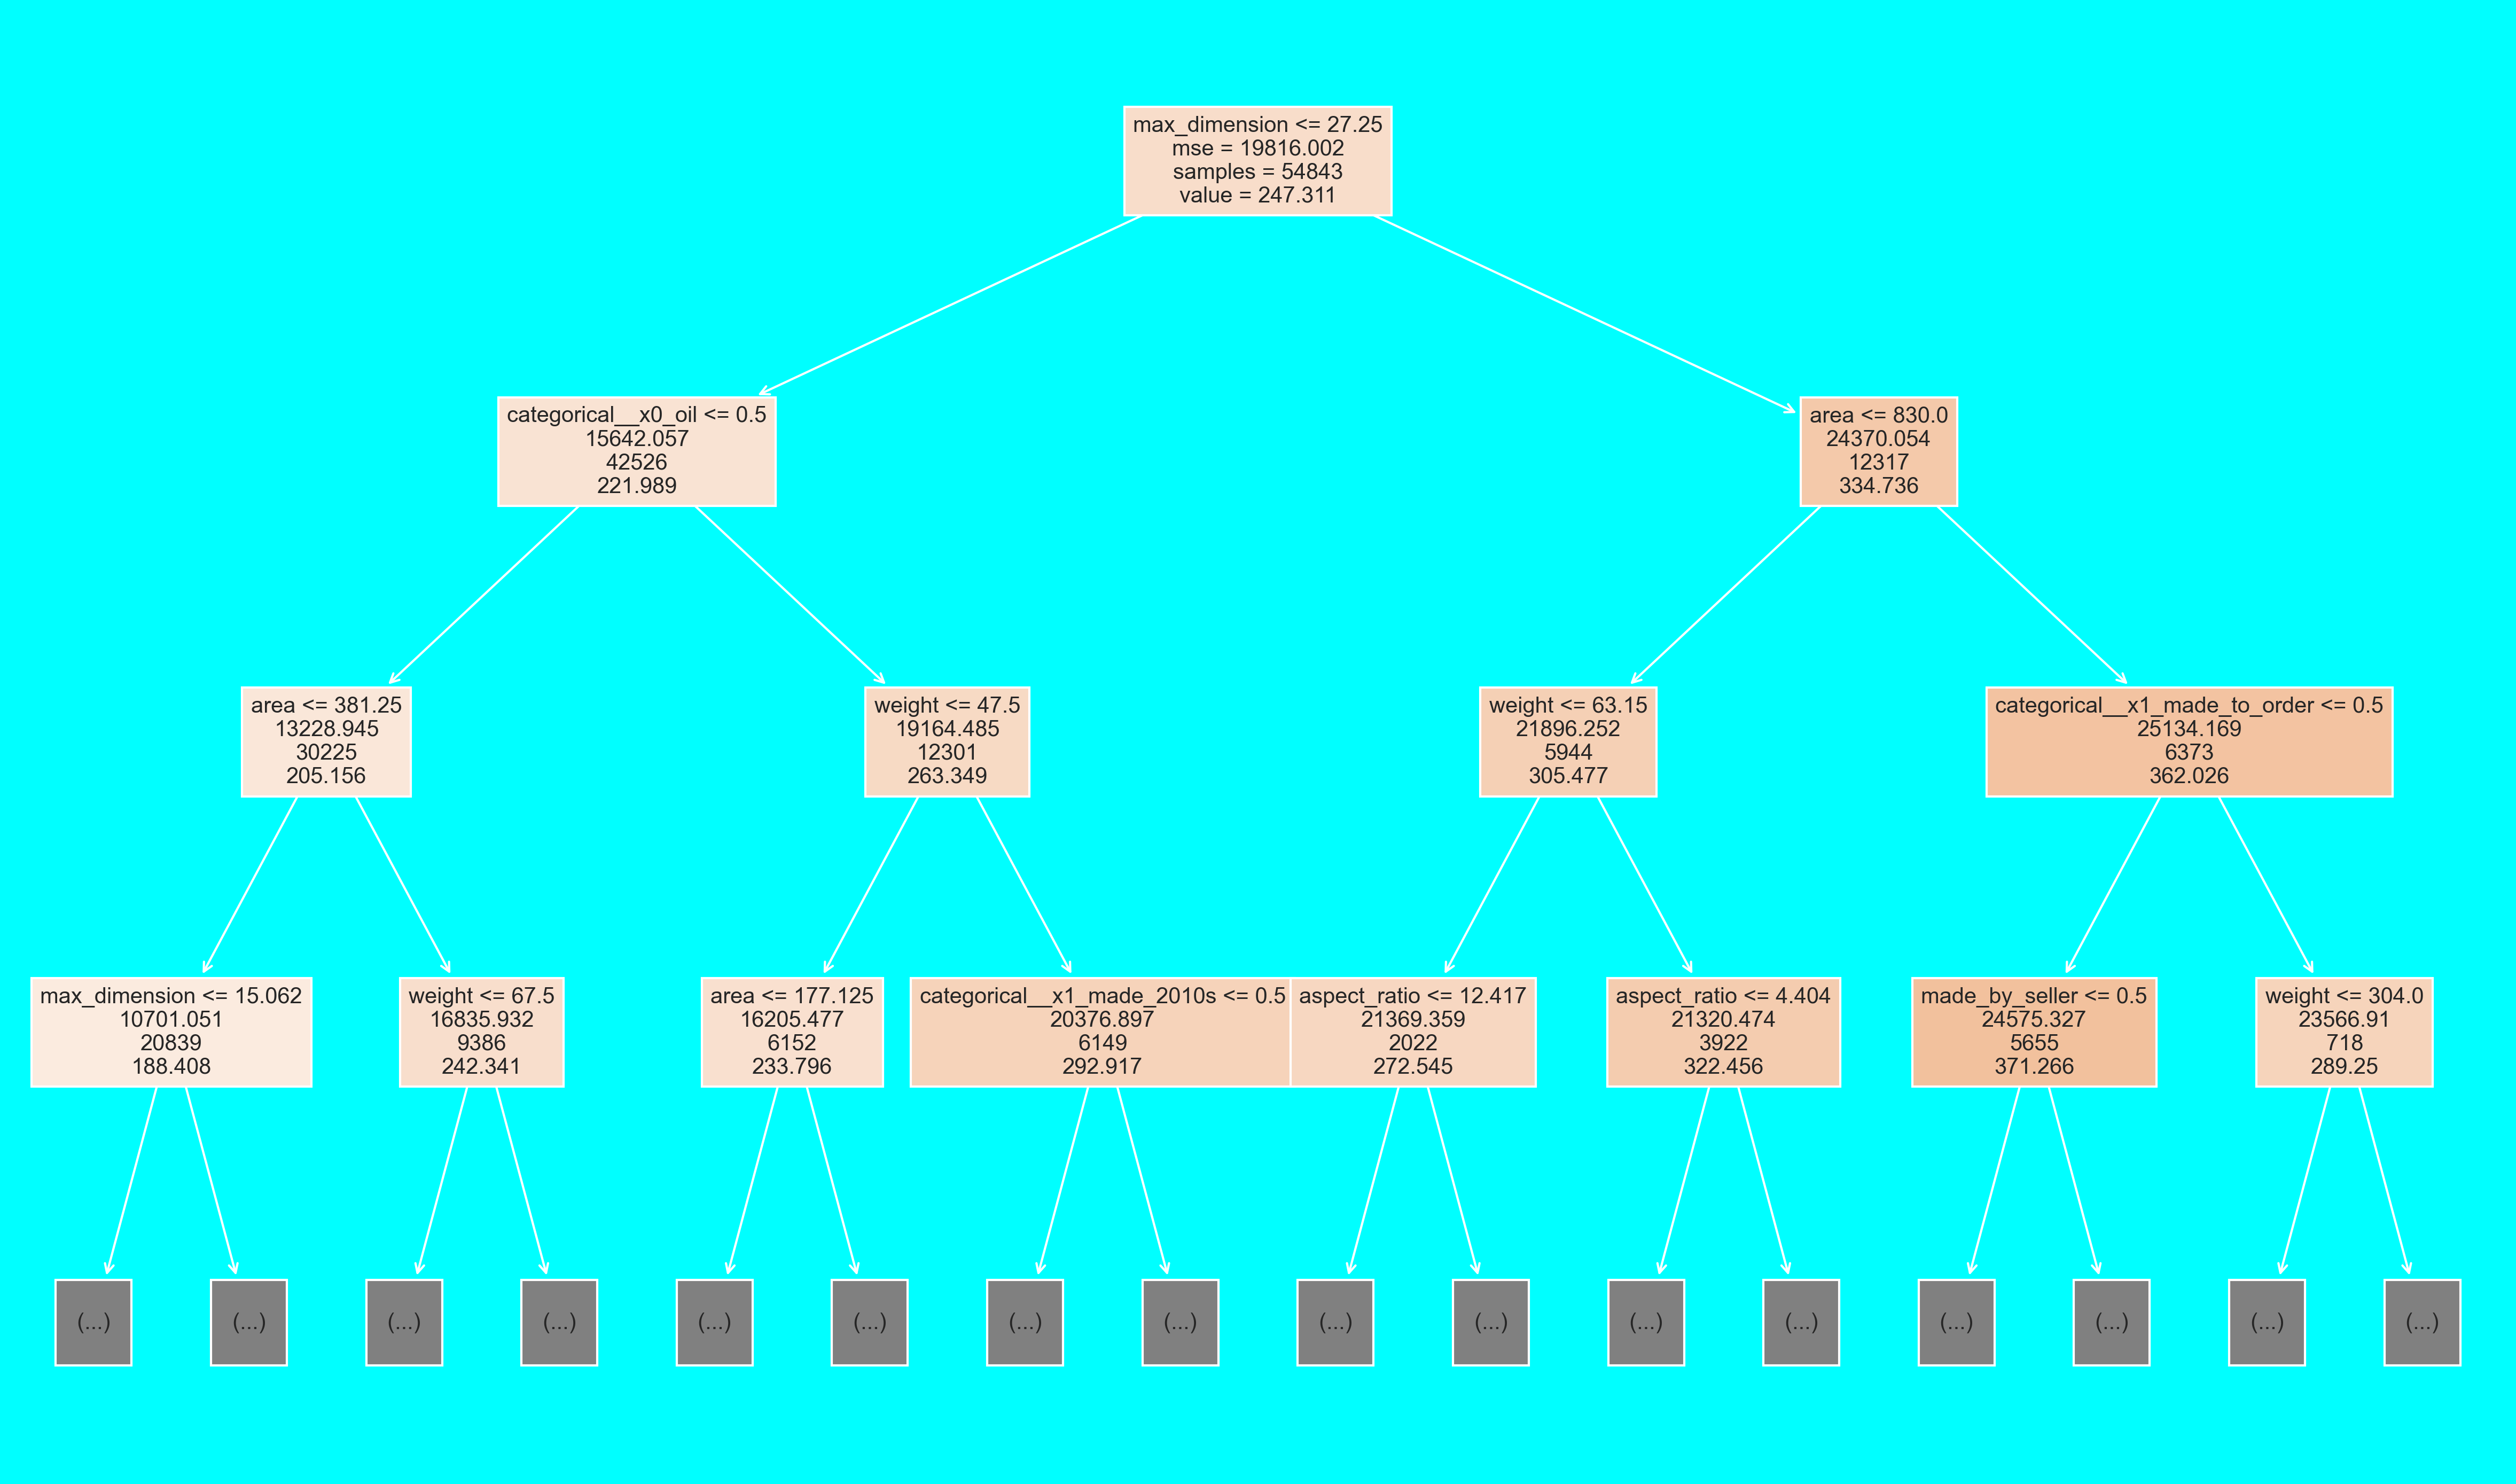

In [177]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_num_plus_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_plus_categorical.png')

#### Model 3d) Random Forest combining numerical and categorical features

In [178]:
from sklearn.ensemble import RandomForestRegressor

In [179]:
num_plus_cat_rforest_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [180]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times

from dill import dump, load

num_plus_cat_rforest_pipe_filename = './Git_exclude/models/num_plus_cat_rforest_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_rforest_pipe_filename, 'rb') as f:
        num_plus_cat_rforest_pipe = load(f)
        print('Loaded pickle file with random forest model for numerical-plus-categorical features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_rforest_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_rforest_pipe_filename, 'wb') as f:
        dump(num_plus_cat_rforest_pipe, f, recurse=True) 
        print('Saved pickle file with random forest model for numerical-plus-categorical features.')

Loaded pickle file with random forest model for numerical-plus-categorical features.


In [181]:
num_plus_cat_rforest_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [182]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_train,prices_train)

0.3709040680366238

In [183]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_test,prices_test)

0.3372104990789736

In [184]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using numerical + categorical features')


Random Forest model using numerical + categorical features:
Training R^2: 0.3709040680366239
Testing R^2: 0.3372104990789736
Training RMSE: USD 111.65198853660267
Testing RMSE: USD 115.72294465200645
Training MAE: USD 85.80174049150443
Testing MAE: USD 88.47691232750194


In [185]:
#what are the main features used for decision?
num_plus_cat_rforest_pipe['rforest'].feature_importances_

array([0.02322483, 0.006006  , 0.0552635 , 0.01090825, 0.02128335,
       0.00963668, 0.01403329, 0.01040719, 0.0224414 , 0.01238986,
       0.01409247, 0.02286931, 0.01395844, 0.22189905, 0.0624422 ,
       0.25212602, 0.16664936, 0.0603688 ])

In [186]:
feature_names_num_plus_cat_rforest = num_plus_cat_rforest_pipe['num and cat selector'].get_feature_names()

num_plus_cat_rforest_features_imp_df = pd.DataFrame(num_plus_cat_rforest_pipe['rforest'].feature_importances_,feature_names_num_plus_cat_rforest,columns=['Rforest feature importance'])
num_plus_cat_rforest_features_imp_df = num_plus_cat_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
num_plus_cat_rforest_features_imp_df

Rforest feature importance
area                                                0.252126
max_dimension                                       0.221899
weight                                              0.166649
aspect_ratio                                        0.062442
days_from_original_creation                         0.060369
categorical__x0_oil                                 0.055264
categorical__x0_acrylic                             0.023225
num_favorers                                        0.022869
made_by_seller                                      0.022441
categorical__x1_made_2010s                          0.021283
has_variations                                      0.014092
categorical__x1_made_before_2010                    0.014033
featured_rank                                       0.013958
is_customizable                                     0.012390
categorical__x0_watercolor                          0.010908
categorical__x1_made_to_order                       0.010407
categorical__x1_made_2020s                          0.009637
categorical__x0_more_than_one                       0.006006

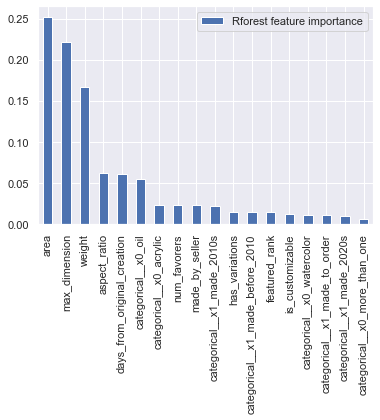

In [187]:
num_plus_cat_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 3e) Gradient Boosting Trees combining numerical and categorical features

In [188]:
from sklearn.ensemble import GradientBoostingRegressor

In [189]:
num_plus_cat_gboost_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('gboost', GradientBoostingRegressor(n_estimators=80,learning_rate=0.1,subsample=0.75,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']-3,random_state=1,min_samples_leaf=10))
])

In [190]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

num_plus_cat_gboost_pipe_filename = './Git_exclude/models/num_plus_cat_gboost_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_gboost_pipe_filename, 'rb') as f:
        num_plus_cat_gboost_pipe = load(f)
        print('Loaded pickle file with gradient boosting model for numerical-plus-categorical features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_gboost_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_gboost_pipe_filename, 'wb') as f:
        dump(num_plus_cat_gboost_pipe, f, recurse=True) 
        print('Saved pickle file with gradient boosting model for numerical-plus-categorical features.')

Loaded pickle file with gradient boosting model for numerical-plus-categorical features.


In [191]:
num_plus_cat_gboost_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=6, n_estimators=80,
                                           random_state=1, subsample=0.75))])

In [192]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_train,prices_train)

0.3774862929031434

In [193]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_test,prices_test)

0.33886680898212473

In [194]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using numerical plus categorical features')


Gradient Boosting model using numerical plus categorical features:
Training R^2: 0.3774862929031434
Testing R^2: 0.33886680898212473
Training RMSE: USD 111.06634575756148
Testing RMSE: USD 115.5782584759971
Training MAE: USD 84.51706451365533
Testing MAE: USD 87.68787843325053


In [195]:
#what are the main features used for decision?
num_plus_cat_gboost_pipe['gboost'].feature_importances_

array([0.00939358, 0.00858046, 0.07347291, 0.0067109 , 0.02501656,
       0.00611   , 0.01711144, 0.01141603, 0.02608419, 0.01212064,
       0.0207721 , 0.0192303 , 0.01535114, 0.31388691, 0.05373765,
       0.16501231, 0.13269642, 0.08329647])

In [196]:
feature_names_num_plus_cat_gboost = num_plus_cat_gboost_pipe['num and cat selector'].get_feature_names()

num_plus_cat_gboost_features_imp_df = pd.DataFrame(num_plus_cat_gboost_pipe['gboost'].feature_importances_,feature_names_num_plus_cat_gboost,columns=['Gboost feature importance'])
num_plus_cat_gboost_features_imp_df = num_plus_cat_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
num_plus_cat_gboost_features_imp_df

Gboost feature importance
max_dimension                                      0.313887
area                                               0.165012
weight                                             0.132696
days_from_original_creation                        0.083296
categorical__x0_oil                                0.073473
aspect_ratio                                       0.053738
made_by_seller                                     0.026084
categorical__x1_made_2010s                         0.025017
has_variations                                     0.020772
num_favorers                                       0.019230
categorical__x1_made_before_2010                   0.017111
featured_rank                                      0.015351
is_customizable                                    0.012121
categorical__x1_made_to_order                      0.011416
categorical__x0_acrylic                            0.009394
categorical__x0_more_than_one                      0.008580
categorical__x0_watercolor                         0.006711
categorical__x1_made_2020s                         0.006110

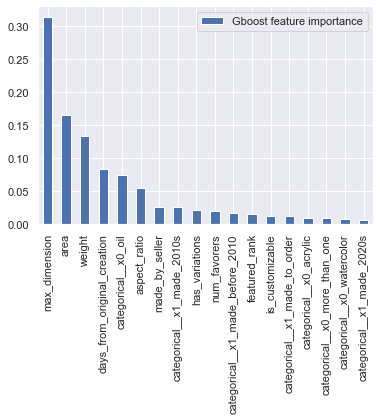

In [197]:
num_plus_cat_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 4) Models using only the 'style' tags

In [198]:
#Here I can't just use OneHotEncoding, because there can be multiple tags for the same listing, i.e. the 'new_style_tags' for a painting could be a list like: ['abstract','contemporary','modern']

In [199]:
all_paintings_df['style_tags_new'].iloc[1]

"['contemporary', 'expressionism', 'modern', 'abstract']"

In [200]:
all_paintings_df['style_tags_new'].value_counts()

['abstract']                                          9171
['landscape']                                         5525
['portrait']                                          4411
['modern', 'abstract']                                2492
['beach']                                             1554
                                                      ... 
['goth', 'whimsical']                                    1
['vintage', 'chic', 'rustic', 'landscape']               1
['regency', 'hollywood', 'victorian']                    1
['vintage', 'floral', 'cottage', 'modern', 'chic']       1
['impressionism', 'floral', 'vintage', 'abstract']       1
Name: style_tags_new, Length: 5719, dtype: int64

In [201]:
#I can use the 'DictVectorizer' provided by scikit-learn. 
#This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value 
#associated with it. Missing keys are filled with zeros. However, before I can use 'DictVectorizer' I need to convert my list of strings into array of dictionaries.
#I do that with a 'DictEncoder' defined as follows:

In [202]:
def stringlist_to_dict(stringlist):
    dict = {}
    for string in stringlist:
        dict[string]=1
    return dict

In [203]:
all_paintings_df['style_tags_new'].apply(eval).apply(stringlist_to_dict)

0        {'contemporary': 1, 'expressionism': 1, 'moder...
1        {'contemporary': 1, 'expressionism': 1, 'moder...
2        {'contemporary': 1, 'modern': 1, 'abstract': 1...
3        {'contemporary': 1, 'abstract': 1, 'whimsical'...
4                     {'modern': 1, 'boho': 1, 'beach': 1}
                               ...                        
68549                                     {'landscape': 1}
68550              {'modern': 1, 'abstract': 1, 'deco': 1}
68551                   {'vintage': 1, 'expressionism': 1}
68552                                 {'impressionism': 1}
68553                                         {'beach': 1}
Name: style_tags_new, Length: 68554, dtype: object

In [204]:
#can do the same thing with a lambda function
all_paintings_df['style_tags_new'].apply(eval).apply(lambda stringlist:{string:1 for string in stringlist})

0        {'contemporary': 1, 'expressionism': 1, 'moder...
1        {'contemporary': 1, 'expressionism': 1, 'moder...
2        {'contemporary': 1, 'modern': 1, 'abstract': 1...
3        {'contemporary': 1, 'abstract': 1, 'whimsical'...
4                     {'modern': 1, 'boho': 1, 'beach': 1}
                               ...                        
68549                                     {'landscape': 1}
68550              {'modern': 1, 'abstract': 1, 'deco': 1}
68551                   {'vintage': 1, 'expressionism': 1}
68552                                 {'impressionism': 1}
68553                                         {'beach': 1}
Name: style_tags_new, Length: 68554, dtype: object

In [205]:
# #This was the original version but dill had trouble with the static method
# from sklearn.base import BaseEstimator, TransformerMixin
# class DictEncoder(BaseEstimator, TransformerMixin):
    
#     @staticmethod
#     def stringlist_to_dict(stringlist):
#         dict = {}
#         for string in stringlist:
#             dict[string]=1
#         return dict
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series of strings representing lists of strings. Return a pandas series of dictionaries
#         return X.apply(eval).apply(stringlist_to_dict)

In [206]:
from sklearn.base import BaseEstimator, TransformerMixin
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of dictionaries
        return X.apply(eval).apply(lambda stringlist:{string:1 for string in stringlist})

In [207]:
from sklearn.feature_extraction import DictVectorizer

pipe_style_tags_encoding = Pipeline([
    ('to dict series',DictEncoder()),
    ('to binary vectors',DictVectorizer())
])

In [208]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tranform = ColumnTransformer([
    ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [209]:
#Let's test this in isolation, which will also enable me to extract the name of the style tags in the order in which they'll appear 
#in the regression models
style_tranform.fit_transform(paintings_df_train)

<54843x69 sparse matrix of type '<class 'numpy.float64'>'
	with 106262 stored elements in Compressed Sparse Row format>

In [210]:
style_vectorizer_feature_names = style_tranform.named_transformers_['style tags vectorizer'][-1].feature_names_

In [211]:
style_vectorizer_feature_names

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

### 4a) Ridge regression of style tags only, after vectorization

Since there are a large number of features, one for each possible style tag (there are about 70), cross validation is critical to prevent overfitting.

In [212]:
from sklearn.linear_model import Ridge

stlye_ridge_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('ridge',Ridge(alpha=10))
])

In [213]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_CVmodel = GridSearchCV(stlye_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [214]:
#Train the model
style_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  2.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [215]:
style_ridge_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [216]:
#Predict prices on training set:
prices_train_pred = style_ridge_CVmodel.predict(paintings_df_train)

In [217]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_train,prices_train)

0.03840533845844207

In [218]:
#Predict prices on test set:
prices_test_pred = style_ridge_CVmodel.predict(paintings_df_test)

In [219]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_test,prices_test)

0.03823654266731391

In [220]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using the vectorized style tags')

Ridge regression model using the vectorized style tags:
Training R^2: 0.03840533845844207
Testing R^2: 0.03823654266731391
Training RMSE: USD 138.03971237330592
Testing RMSE: USD 139.4009719539047
Training MAE: USD 111.7306404966635
Testing MAE: USD 112.98896109379645


In [221]:
#Which are the largest regression coefficients in the regression model?
style_ridge_reg_coeff_df = pd.DataFrame(style_ridge_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
style_ridge_reg_coeff_df['Feature']=pd.Series(style_vectorizer_feature_names)
style_ridge_reg_coeff_df = style_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_reg_coeff_df.set_index(['Feature'])
#style_ridge_reg_coeff_df


Regression coefficients
Feature                              
neoclassical               151.803671
традиционный               136.345992
rocker                     134.778681
cовременный                121.694613
resort                      85.028791
...                               ...
fashion                    -24.601981
kawaii                     -29.278836
woodland                   -30.503976
spooky                     -33.283555
burlesque                  -52.967305

[69 rows x 1 columns]

In [222]:
#note: the first Russian word means 'traditional', the second means 'modern'

### 4b) Decision tree of style tags only, after vectorization

In [223]:
from sklearn.pipeline import Pipeline

style_dtree_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15,min_samples_leaf=10)),
])

In [224]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} 
style_dtree_CVmodel = GridSearchCV(style_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [225]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

style_dtree_CVmodel_filename = './Git_exclude/models/style_dtree_CVmodel.pickle'


#If the model file already exists, I load it:
try:
    with open(style_dtree_CVmodel_filename, 'rb') as f:
        style_dtree_CVmodel = load(f)
        print('Loaded pickle file with decision tree model for style tags (vectorized but without tf-idf.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_dtree_CVmodel_filename, 'wb') as f:
        dump(style_dtree_CVmodel, f, recurse=True) 
        print('Saved pickle file with decision tree model for style tags (vectorized but without tf-idf).')



Loaded pickle file with decision tree model for style tags (vectorized but without tf-idf.


In [226]:
style_dtree_CVmodel.best_params_['dtree__max_depth']

12

In [227]:
#Predict prices on training set:
prices_train_pred = style_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
style_dtree_CVmodel.score(paintings_df_train,prices_train)

0.06959117309629592

In [228]:
#Predict prices on test set:
prices_test_pred = style_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
style_dtree_CVmodel.score(paintings_df_test,prices_test)

0.05266826274854097

In [229]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only style tags')


Decision Tree model using only style tags:
Training R^2: 0.06959117309629592
Testing R^2: 0.05266826274854097
Training RMSE: USD 135.78285464581734
Testing RMSE: USD 138.35112963565032
Training MAE: USD 108.7155984064617
Testing MAE: USD 111.0149961904816


In [230]:
feature_names_style_dtree = style_dtree_CVmodel.best_estimator_['style tags vectorization'].named_transformers_['style tags vectorizer']['to binary vectors'].get_feature_names()

style_dtree_features_imp_df = pd.DataFrame(style_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_style_dtree,columns=['Dtree feature importance'])
style_dtree_features_imp_df = style_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_features_imp_df.iloc[:20]

Dtree feature importance
modern                         0.130869
impressionism                  0.124544
deco                           0.075992
abstract                       0.063456
contemporary                   0.050842
portrait                       0.040641
expressionism                  0.039545
pop                            0.039489
традиционный                   0.030558
vintage                        0.029637
landscape                      0.029498
fashion                        0.023388
realism                        0.020125
nautical                       0.018064
floral                         0.018032
minimalism                     0.016793
rocker                         0.014685
beach                          0.013018
victorian                      0.012719
folk                           0.012163

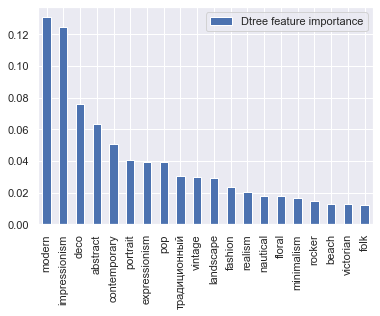

In [231]:
style_dtree_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

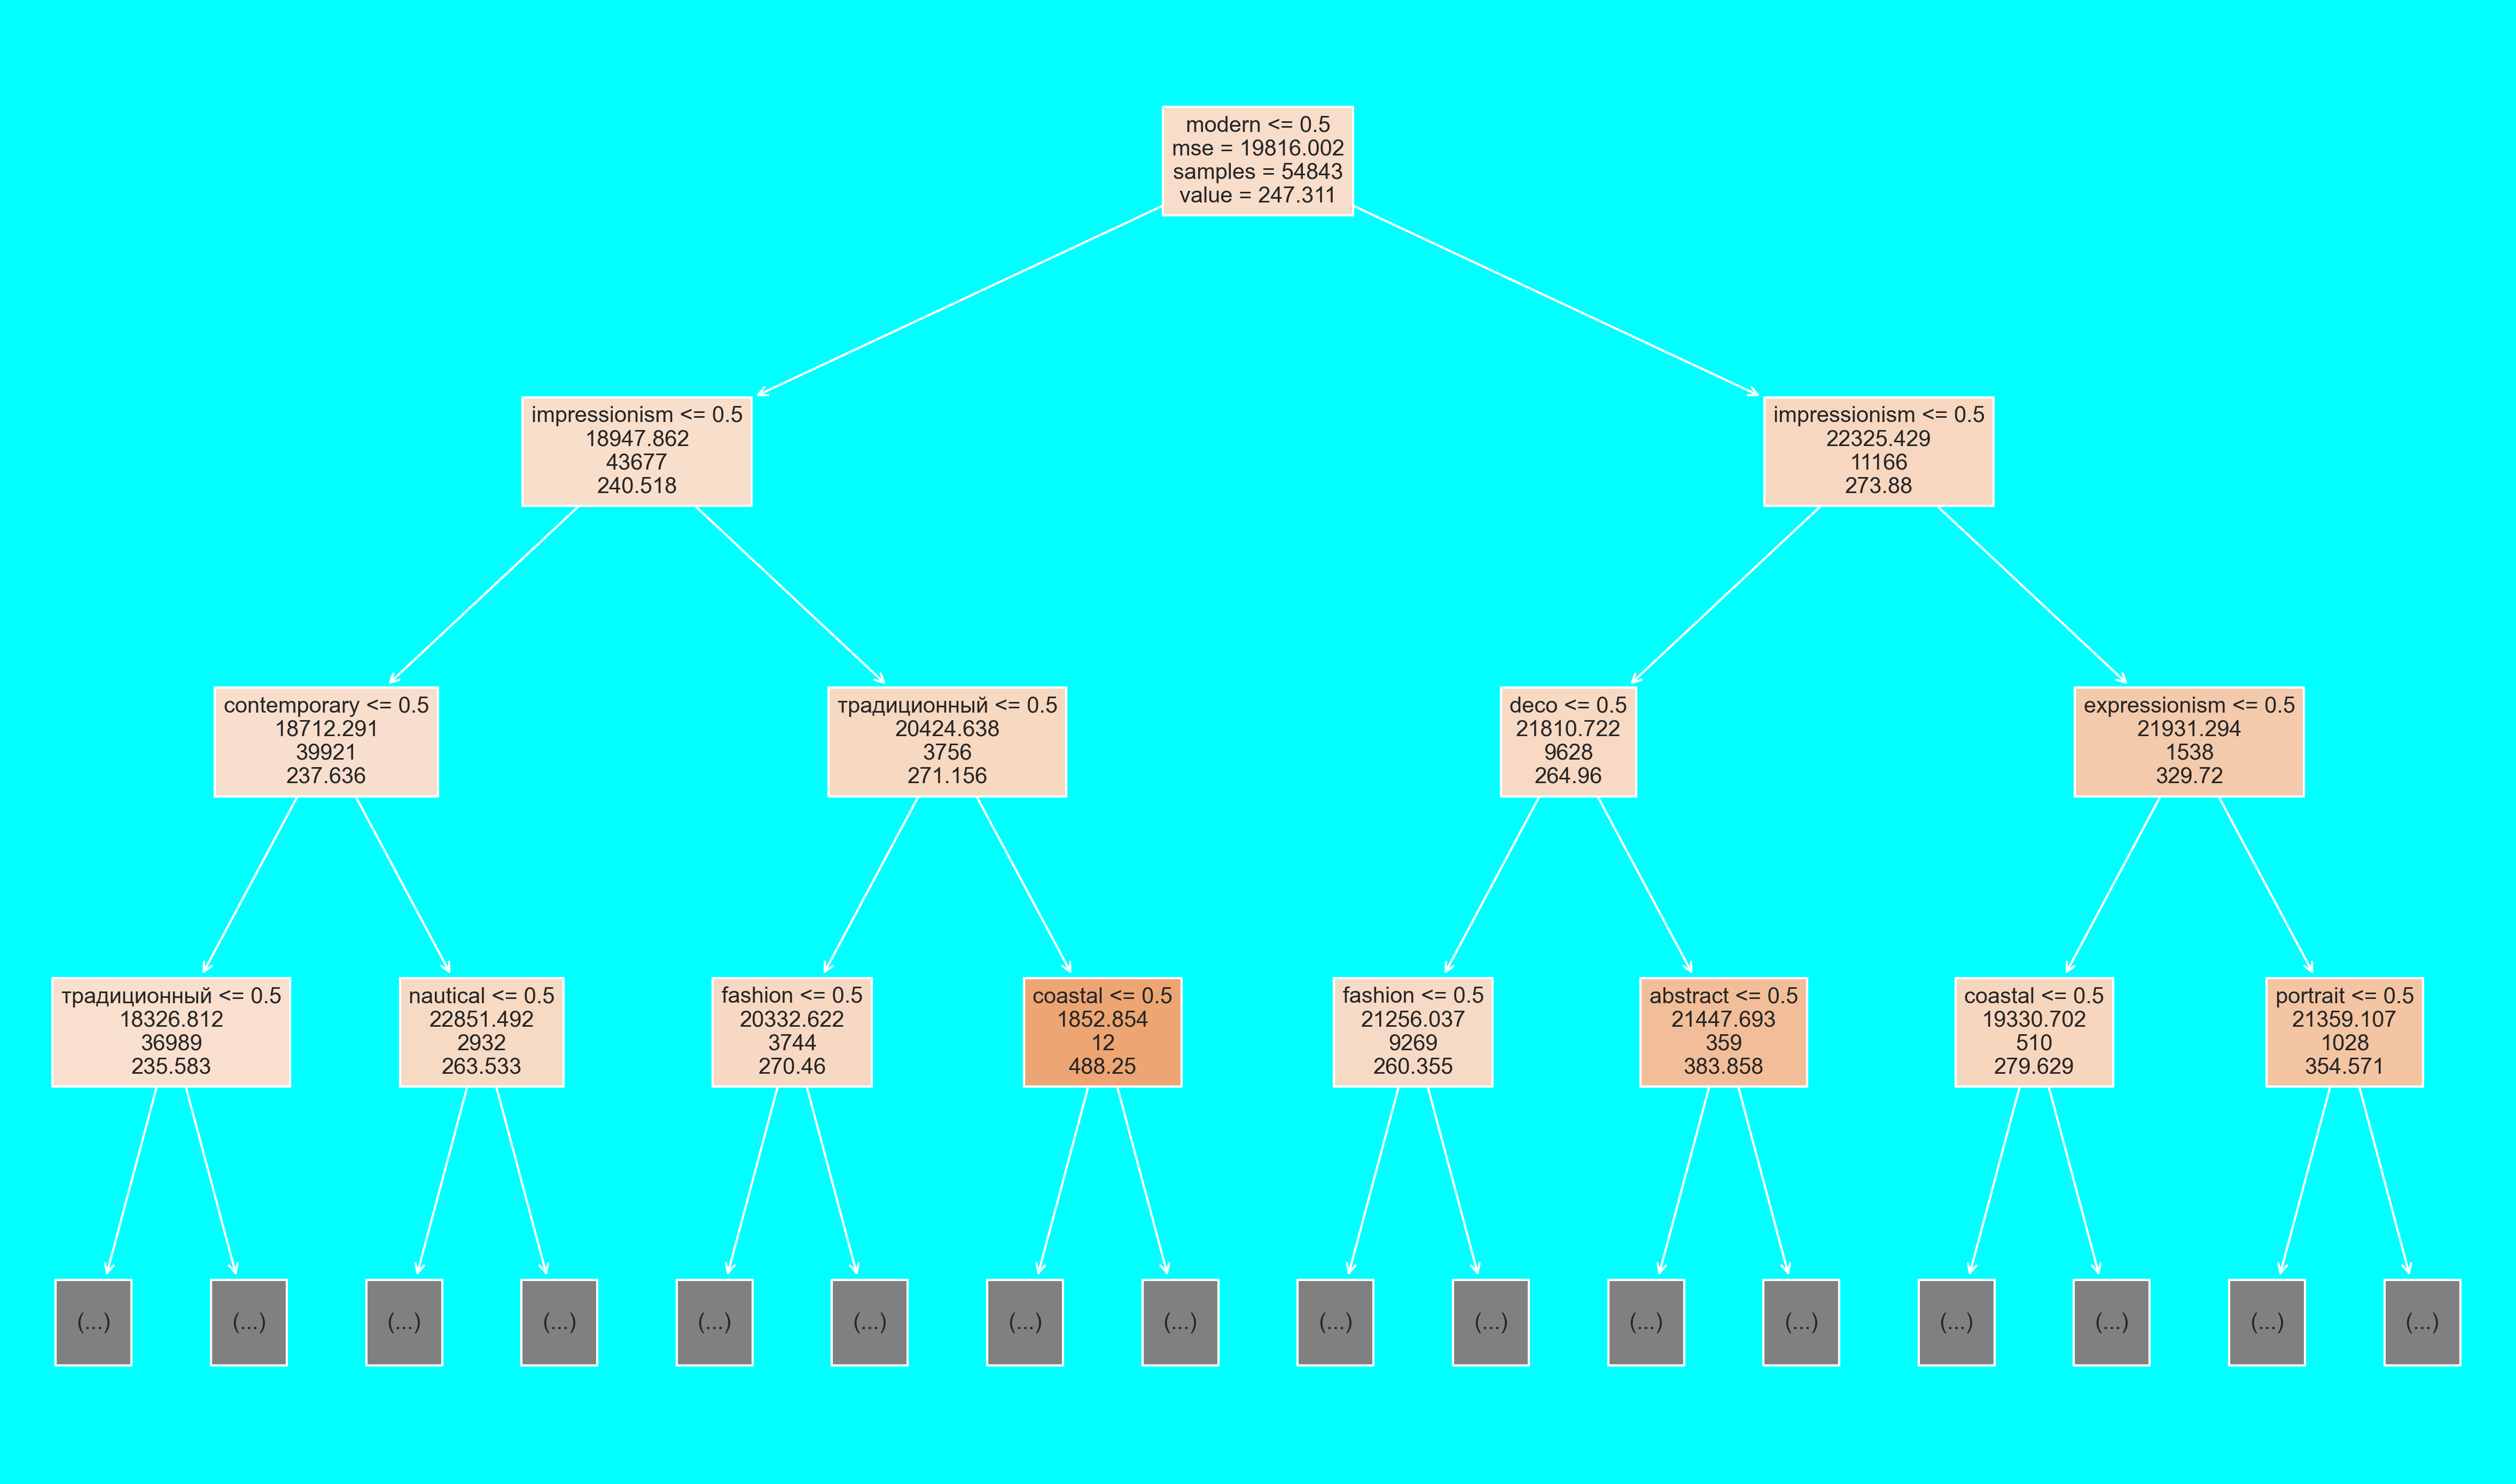

In [232]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(style_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_style_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_style_no_tfidf.png')

### 4c) Ridge regression of style tags only, after Tf-Idf vectorization (up to bigrams) and optional dimensionality reduction

In [233]:
from sklearn.feature_extraction.text import TfidfTransformer #TfidfVectorizer

In [234]:
from sklearn.linear_model import Ridge

stlye_ridge_w_tfidf_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('tfid', TfidfTransformer()), 
    ('ridge',Ridge(alpha=10))
])

In [235]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_w_tfidf_CVmodel = GridSearchCV(stlye_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [236]:
#Train the model
style_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('tfid', TfidfTransformer()),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [237]:
style_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 2.636650898730358}

In [238]:
#Predict prices on training set:
prices_train_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [239]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.03761413160582139

In [240]:
#Predict prices on test set:
prices_test_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [241]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.037744164527843904

In [242]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized style tags with Tf-Idf')

Ridge regression model using vectorized style tags with Tf-Idf:
Training R^2: 0.03761413160582139
Testing R^2: 0.037744164527843904
Training RMSE: USD 138.0964907195473
Testing RMSE: USD 139.43665079368142
Training MAE: USD 111.85256147427206
Testing MAE: USD 113.09770394322598


### A different method of implementing Tf-Idf - instead of going through the DictVectorizer - is to use more traditional NLP techniques with TfIdfVectorizer, that enables to also use n-grams (i.e. sequences of words in addition to individual words) 
#### The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'style tags' column as follows (essentially joining the strings in the list)

In [243]:
from sklearn.base import BaseEstimator, TransformerMixin
class TagsEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
        return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [244]:
all_paintings_df['style_tags_new'].iloc[0]

"['contemporary', 'expressionism', 'modern', 'abstract']"

In [245]:
all_paintings_df['style_tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0        contemporary expressionism modern abstract
1        contemporary expressionism modern abstract
2              contemporary modern abstract fantasy
3           contemporary abstract whimsical fantasy
4                                 modern boho beach
                            ...                    
68549                                     landscape
68550                          modern abstract deco
68551                         vintage expressionism
68552                                 impressionism
68553                                         beach
Name: style_tags_new, Length: 68554, dtype: object

In [246]:
#A TfIdfVectorizer should then follow, where I can even try to count n-grams of 2 words

In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_tags_encoding = Pipeline([
    ('to single string',TagsEncoder()),
    ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
])

In [248]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tags_tranform = ColumnTransformer([
    ('style tags tfidf', pipe_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [249]:
#I first fit_transform the training data by itself to extract the feature names to later
#retrieve them for interpreting the results
style_tags_tranform.fit_transform(paintings_df_train)

<54843x1699 sparse matrix of type '<class 'numpy.float64'>'
	with 157681 stored elements in Compressed Sparse Row format>

In [250]:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()[:10]

['abstract',
 'abstract african',
 'abstract american',
 'abstract asian',
 'abstract automobilia',
 'abstract beach',
 'abstract boho',
 'abstract century',
 'abstract chic',
 'abstract coastal']

In [251]:
#the inverse frequencies can be extracted as follows:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].idf_

array([ 1.96307039,  9.71502349,  6.67580611, ...,  9.71502349,
       11.21910089, 10.81363578])

In [252]:
#Now put everything in a pipeline with Ridge Regression

In [253]:
from sklearn.linear_model import Ridge

style_tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [254]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
style_tags_ridge_w_tfidf_CVmodel = GridSearchCV(style_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [255]:
#Train the model
style_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   55.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [256]:
style_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 5.0}

In [257]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_style_ridge_tfidf = style_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_ridge_reg_coeff_df = pd.DataFrame(style_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_style_ridge_tfidf,columns=['Regression coefficients'])
style_ridge_reg_coeff_df = style_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_reg_coeff_df

Regression coefficients
традиционный                          196.117119
african photorealism                  187.186028
abstract resort                       180.504476
minimalism floral                     177.256276
retro rocker                          174.042762
...                                          ...
coastal fashion                       -90.990029
woodland realism                      -94.049577
asian realism                         -94.626657
landscape mediterranean              -103.619955
tribal asian                         -133.803200

[1699 rows x 1 columns]

In [258]:
#Predict prices on training set:
prices_train_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [259]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.07170079885731373

In [260]:
#Predict prices on test set:
prices_test_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [261]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.057331944938033286

In [262]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.07170079885731373
Testing R^2: 0.057331944938033286
Training RMSE: USD 135.6288290389163
Testing RMSE: USD 138.01016050066994
Training MAE: USD 109.27017732087722
Testing MAE: USD 111.44309514738262


#### Adding optional dimensionality reduction before computing the regressor

In [263]:
from sklearn.decomposition import TruncatedSVD

style_tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [264]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,20,6), 'SVD__n_components': range(2,142,4)} 
#style_tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(style_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
style_tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(style_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [265]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

style_tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/style_tags_SVD_ridge_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(style_tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        style_tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded pickle file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(style_tags_ridge_w_tfidf_SVD_CVmodel, f, recurse=True) 
        print('Saved pickle file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.')

Loaded pickle file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.


In [266]:
style_tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 110, 'ridge__alpha': 10.0}

In [267]:
#Predict prices on training set:
prices_train_pred = style_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [268]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.04027858879215085

In [269]:
#Predict prices on test set:
prices_test_pred = style_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [270]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.04072116450382246

In [271]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized style tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized style tags with Tf-Idf followed by SVD:
Training R^2: 0.04027858879215085
Testing R^2: 0.04072116450382246
Training RMSE: USD 137.90519155875825
Testing RMSE: USD 139.22079111958567
Training MAE: USD 111.56976107258386
Testing MAE: USD 112.90844815047082


In [272]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [273]:
style_feature_names = style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [274]:
# Get Singular values and Components 
Sigma = style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([92.71376264, 72.05133587, 62.30006135, 54.50276513, 41.38687466,
       40.36503422, 40.07906089, 39.10593646, 34.59701362, 29.00301032,
       27.22751847, 26.65796414, 26.5806961 , 24.52625   , 24.39656156,
       22.88138414, 22.15481164, 21.85886934, 21.23629174, 20.8750799 ,
       20.47643269, 20.23180755, 20.18290954, 19.0791865 , 18.80935837,
       18.73777338, 18.36409483, 18.21037627, 17.8273154 , 17.76145089,
       16.6290827 , 16.46845906, 16.23416499, 16.02066584, 15.87412914,
       15.69770635, 15.32801014, 14.88677017, 14.63634107, 14.43138975,
       13.92767535, 13.72420117, 13.36869967, 13.13101659, 12.98638217,
       12.53349054, 12.24088431, 12.09355093, 12.0544645 , 11.93037891,
       11.8090794 , 11.57792555, 11.54467804, 11.42164381, 11.40916133,
       11.23845876, 11.10938482, 11.04510282, 10.89028059, 10.73437681,
       10.60618564, 10.58281041, 10.5046778 , 10.4643146 ,  9.94055605,
        9.926174  ,  9.81020241,  9.74855985,  9.72807656,  9.68

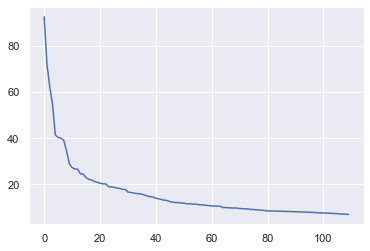

In [275]:
plt.plot(Sigma)

In [276]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

Topic 0:  ['abstract(0.97)', 'modern(0.15)', 'modern abstract(0.15)']
Topic 1:  ['landscape(0.99)', 'abstract(-0.08)', 'impressionism(0.07)']
Topic 2:  ['portrait(1.0)', 'abstract portrait(0.04)', 'modern(0.03)']
Topic 3:  ['modern(0.73)', 'modern abstract(0.52)', 'contemporary(0.28)']
Topic 4:  ['impressionism(0.54)', 'contemporary(0.51)', 'floral(0.32)']
Topic 5:  ['beach(0.93)', 'contemporary(-0.24)', 'contemporary abstract(-0.14)']
Topic 6:  ['floral(0.78)', 'contemporary(-0.43)', 'contemporary abstract(-0.27)']
Topic 7:  ['impressionism(0.7)', 'floral(-0.5)', 'contemporary(-0.3)']
Topic 8:  ['vintage(0.97)', 'vintage landscape(0.1)', 'vintage portrait(0.09)']
Topic 9:  ['expressionism(0.7)', 'expressionism abstract(0.42)', 'modern abstract(-0.32)']
Topic 10:  ['modern(0.47)', 'modern abstract(-0.47)', 'contemporary modern(-0.43)']
Topic 11:  ['realism(0.94)', 'fantasy(0.27)', 'portrait realism(0.16)']
Topic 12:  ['fantasy(0.95)', 'realism(-0.27)', 'abstract fantasy(0.12)']
Topic 1

In [277]:
#Which are the largest regression coefficients in the regression model?
feature_names_style_ridge_tfidf = style_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_ridge_SVD_reg_coeff_df = pd.DataFrame(style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
style_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_style_topics)
style_ridge_SVD_reg_coeff_df = style_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients  \
101                90.207009   
82                 70.147384   
71                 66.956700   
77                 61.501255   
7                  59.647428   
65                 56.813730   
59                 55.471866   
54                 54.459484   
28                 51.867000   
90                 46.377174   

                                                 Topic  
101  [vintage modern(0.71), century vintage(-0.33),...  
82   [abstract deco(0.48), minimalism abstract(-0.4...  
71   [modern landscape(0.75), modern portrait(-0.29...  
77   [modern portrait(0.49), modern expressionism(0...  
7    [impressionism(0.7), floral(-0.5), contemporar...  
65   [floral landscape(0.88), floral vintage(-0.23)...  
59   [contemporary landscape(0.59), abstract modern...  
54   [landscape modern(0.46), abstract landscape(0....  
28   [folk(0.72), contemporary modern(-0.31), moder...  
90   [impressionism vintage(0.56), vintage modern(0...

In [278]:
style_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients                                              Topic
23               -55.054389  [rustic(0.91), rustic landscape(0.2), traditio...
80               -56.647439  [abstract deco(-0.61), deco(0.34), minimalism ...
40               -61.321968  [woodland(0.95), landscape woodland(0.15), cot...
33               -67.610839      [boho(0.87), abstract boho(0.36), chic(0.13)]
84               -70.479405  [impressionism vintage(0.52), impressionism ex...
96               -72.973836  [hippie(0.8), abstract boho(-0.33), boho hippi...
31               -77.132996  [landscape contemporary(0.6), contemporary mod...
26               -84.306709  [modern contemporary(0.64), expressionism abst...
29              -101.461175  [folk(0.62), contemporary modern(0.33), modern...
46              -106.345881  [spooky(0.91), goth(0.3), vintage portrait(-0....

In [279]:
#In conclusion, for Ridge Regression of style tags, using Tf-Idf with bigrams improves the performance a tiny bit 
#but it comes at the cost of increasing a lot the number of features and reducing interpretability
#Dimensionality-reduction doesn't really help with these aspects, so the best seems to be to 
#just use the vectorized tags - without tf-idf, bigrams, etc. 
#Let's now see whether that is true using tree-based models

### 4d) Decision tree of style tags only, after Tf-Idf vectorization using up to bigrams, and with optional dimensionality reduction

In [280]:
from sklearn.pipeline import Pipeline

style_dtree_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15,min_samples_leaf=10)),
])

In [281]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} #np.linspace(0,10,1)} 
style_dtree_w_tfidf_CVmodel = GridSearchCV(style_dtree_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [282]:
style_dtree_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   59.4s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:  3.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'style_tags_new')])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=15,
                                                              min_samples_leaf=10))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 51, 2)},
             verbose=1)

In [283]:
style_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']

14

In [284]:
#Predict prices on training set:
prices_train_pred = style_dtree_w_tfidf_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
style_dtree_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.06691709352107511

In [285]:
#Predict prices on test set:
prices_test_pred = style_dtree_w_tfidf_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
style_dtree_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.05791376904281631

In [286]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only style tags, after Tf-Idf')


Decision Tree model using only style tags, after Tf-Idf:
Training R^2: 0.06691709352107511
Testing R^2: 0.05791376904281631
Training RMSE: USD 135.97784078020007
Testing RMSE: USD 137.9675633045501
Training MAE: USD 109.02871981055964
Testing MAE: USD 110.77588275106098


In [287]:
#What are the style words or word combos that are used most by the tree regressor?
feature_names_style_dtree_w_tfidf = style_dtree_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_dtree_w_tfidf_features_imp_df = pd.DataFrame(style_dtree_w_tfidf_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_style_dtree_w_tfidf,columns=['Dtree feature importance'])
style_dtree_w_tfidf_features_imp_df = style_dtree_w_tfidf_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_w_tfidf_features_imp_df.iloc[:20]

Dtree feature importance
abstract contemporary                  0.145414
modern                                 0.111852
abstract deco                          0.080561
impressionism                          0.077451
contemporary                           0.058830
expressionism                          0.048661
pop                                    0.043763
landscape                              0.027018
традиционный                           0.026683
minimalism floral                      0.026395
abstract                               0.022681
vintage abstract                       0.020808
realism                                0.020237
rocker                                 0.018678
modern expressionism                   0.017808
contemporary abstract                  0.017661
fashion                                0.015535
abstract resort                        0.013283
vintage modern                         0.012899
floral                                 0.011054

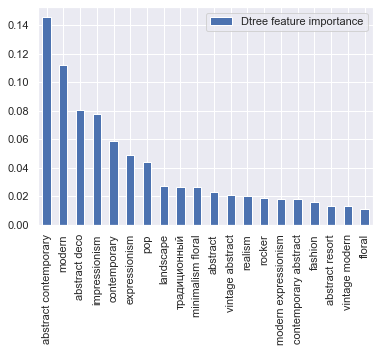

In [288]:
style_dtree_w_tfidf_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

In [289]:
#what if I do dimensionality reduction before computing the regressor?

In [290]:
from sklearn.decomposition import TruncatedSVD

style_dtree_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree', DecisionTreeRegressor(max_depth=10))
])

In [291]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,12,2), 'SVD__n_components': range(2,42,2)} 
#style_dtree_w_tfidf_SVD_CVmodel = RandomizedSearchCV(style_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
style_dtree_w_tfidf_SVD_CVmodel = GridSearchCV(style_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [292]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

style_tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/style_tags_SVD_dtree_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(style_tags_SVD_dtree_CVmodel_filename, 'rb') as f:
        style_dtree_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded pickle file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_dtree_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_tags_SVD_dtree_CVmodel_filename, 'wb') as f:
        dump(style_dtree_w_tfidf_SVD_CVmodel, f, recurse=True) 
        print('Saved pickle file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.')

Loaded pickle file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.


In [293]:
style_dtree_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 36, 'dtree__max_depth': 6}

In [294]:
#Predict prices on training set:
prices_train_pred = style_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [295]:
#And return the R2 score as follows:
style_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.04139401559840694

In [296]:
#Predict prices on test set:
prices_test_pred = style_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [297]:
#And return the R2 score as follows:
style_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.039709972339892485

In [298]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using vectorized tags with Tf-Idf followed by SVD')

Decision tree model using vectorized tags with Tf-Idf followed by SVD:
Training R^2: 0.04139401559840694
Testing R^2: 0.039709972339892485
Training RMSE: USD 137.82502878107974
Testing RMSE: USD 139.2941492965779
Training MAE: USD 111.38156128037063
Testing MAE: USD 112.67981019521831


In [299]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [300]:
style_feature_names = style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [301]:
# Get Singular values and Components 
Sigma = style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([92.71376264, 72.05133587, 62.30006135, 54.50276513, 41.38687466,
       40.36503422, 40.07906089, 39.10593646, 34.59701361, 29.00301023,
       27.22751799, 26.65796281, 26.58069413, 24.52624832, 24.39655855,
       22.88137718, 22.15478205, 21.85884552, 21.23615053, 20.87493634,
       20.47632462, 20.23154487, 20.1826106 , 19.0788842 , 18.8087933 ,
       18.73647541, 18.36132973, 18.20833907, 17.82552304, 17.76024293,
       16.61384919, 16.46188452, 16.21562795, 16.00042521, 15.84301495,
       15.68240301])

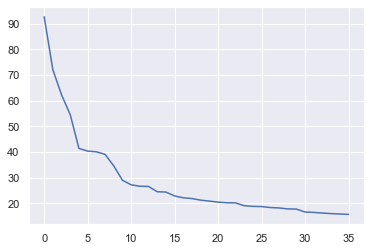

In [302]:
plt.plot(Sigma)

In [303]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

Topic 0:  ['abstract(0.97)', 'modern(0.15)', 'modern abstract(0.15)']
Topic 1:  ['landscape(0.99)', 'abstract(-0.08)', 'impressionism(0.07)']
Topic 2:  ['portrait(1.0)', 'abstract portrait(0.04)', 'modern(0.03)']
Topic 3:  ['modern(0.73)', 'modern abstract(0.52)', 'contemporary(0.28)']
Topic 4:  ['impressionism(0.54)', 'contemporary(0.51)', 'floral(0.32)']
Topic 5:  ['beach(0.93)', 'contemporary(-0.24)', 'contemporary abstract(-0.14)']
Topic 6:  ['floral(0.78)', 'contemporary(-0.43)', 'contemporary abstract(-0.27)']
Topic 7:  ['impressionism(0.7)', 'floral(-0.5)', 'contemporary(-0.3)']
Topic 8:  ['vintage(0.97)', 'vintage landscape(0.1)', 'vintage portrait(0.09)']
Topic 9:  ['expressionism(0.7)', 'expressionism abstract(0.42)', 'modern abstract(-0.32)']
Topic 10:  ['modern(0.47)', 'modern abstract(-0.47)', 'contemporary modern(-0.43)']
Topic 11:  ['realism(0.94)', 'fantasy(0.27)', 'portrait realism(0.16)']
Topic 12:  ['fantasy(0.95)', 'realism(-0.27)', 'abstract fantasy(0.12)']
Topic 1

In [304]:
#Which are the most predictive 'topics' in the decision tree?

In [305]:
#What are the style words or word combos that are used most by the tree regressor?
style_dtree_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
style_dtree_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_dtree_w_tfidf_SVD_features_imp_df = style_dtree_w_tfidf_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_w_tfidf_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
3                   0.310279   
26                  0.156200   
13                  0.064964   
25                  0.063841   
21                  0.055372   
7                   0.045976   
27                  0.038806   
33                  0.027759   
34                  0.027598   
23                  0.026391   
20                  0.024382   
18                  0.022758   
6                   0.020508   
0                   0.019989   
35                  0.014212   
12                  0.013787   
32                  0.013475   
19                  0.011083   
24                  0.007860   
15                  0.007280   

                                                Topic  
3   [modern(0.73), modern abstract(0.52), contempo...  
26  [modern contemporary(0.64), expressionism abst...  
13  [pop(0.97), abstract pop(0.19), landscape abst...  
25  [deco(0.82), abstract deco(0.48), modern conte...  
21  [nautical(0.63), impressionism landscape(-0.5)...  
7   [impressionism(0.7), floral(-0.5), contemporar...  
27  [traditional(0.91), landscape traditional(0.19...  
33      [boho(0.87), abstract boho(0.36), chic(0.13)]  
34  [abstract portrait(0.99), impressionism abstra...  
23  [rustic(0.91), rustic landscape(0.2), traditio...  
20  [whimsical(0.97), abstract whimsical(0.15), am...  
18  [minimalism(0.85), minimalism modern(0.37), mi...  
6   [floral(0.78), contemporary(-0.43), contempora...  
0   [abstract(0.97), modern(0.15), modern abstract...  
35  [western(0.93), landscape western(0.2), africa...  
12  [fantasy(0.95), realism(-0.27), abstract fanta...  
32  [fashion(0.89), landscape contemporary(-0.25),...  
19  [american(0.88), african(0.36), african americ...  
24  [century(0.84), modern contemporary(-0.26), ce...  
15  [country(0.9), landscape country(0.37), rustic...

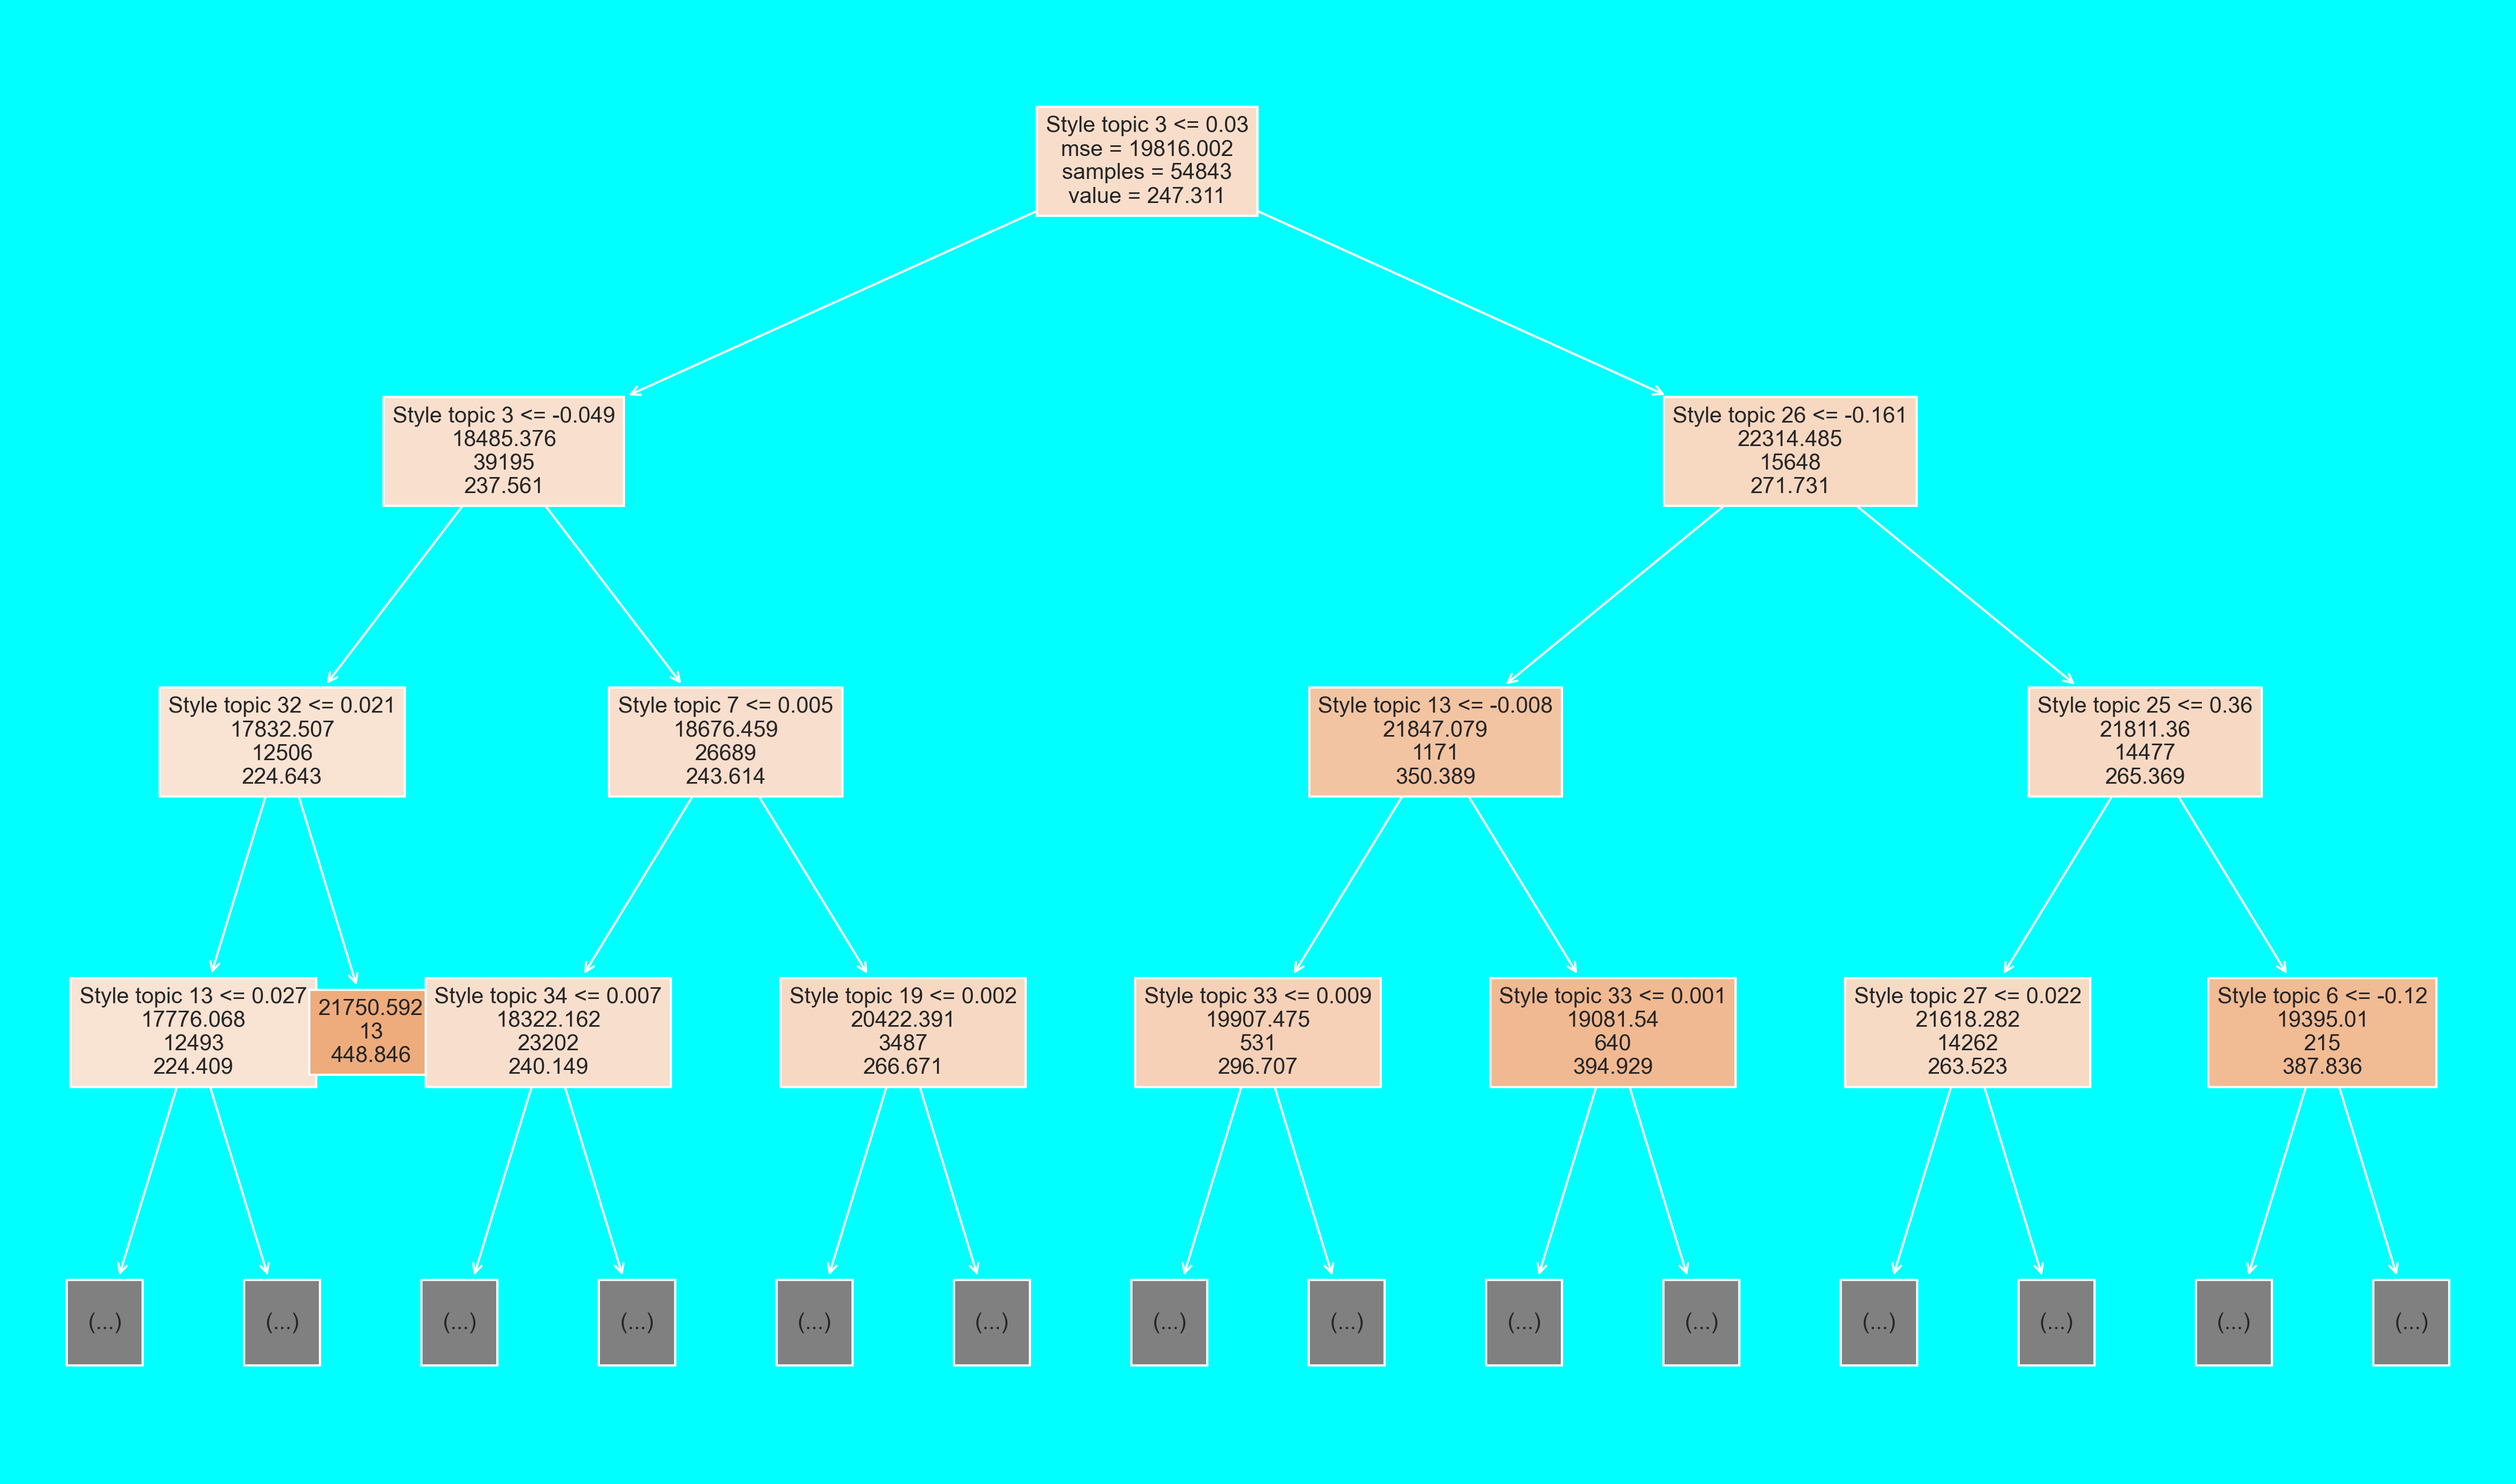

In [306]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_style_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_style_tags_After_tfidf_SVD.png')

#### Model 4e) Random Forest on Style Tags (vectorized, but without Tf-Idf vectorization or SVD reduction)

In [307]:
from sklearn.ensemble import RandomForestRegressor

In [308]:
style_rforest_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=style_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [309]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

style_rforest_pipe_filename = './Git_exclude/models/style_rforest_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(style_rforest_pipe_filename, 'rb') as f:
        style_rforest_pipe = load(f)
        print('Loaded pickle file with random forest model for style tags (without Tf-Idf).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_rforest_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_rforest_pipe_filename, 'wb') as f:
        dump(style_rforest_pipe, f, recurse=True) 
        print('Saved pickle file with random forest model for style tags (without Tf-Idf).')

Loaded pickle file with random forest model for style tags (without Tf-Idf).


In [310]:
#Predict prices on training set:
prices_train_pred = style_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_rforest_pipe.score(paintings_df_train,prices_train)

0.06666272856166411

In [311]:
#Predict prices on test set:
prices_test_pred = style_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_rforest_pipe.score(paintings_df_test,prices_test)

0.05599689027228538

In [312]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using style tags (without Tf-Idf)')


Random Forest model using style tags (without Tf-Idf):
Training R^2: 0.06666272856166411
Testing R^2: 0.05599689027228516
Training RMSE: USD 135.99637377485632
Testing RMSE: USD 138.10785444362477
Training MAE: USD 110.10254647823982
Testing MAE: USD 111.90802631580422


In [313]:
style_rforest_pipe

Pipeline(steps=[('style tags vectorization',
                 ColumnTransformer(transformers=[('style tags vectorizer',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictEncoder()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'style_tags_new')])),
                ('rforest',
                 RandomForestRegressor(max_depth=13, max_features='sqrt',
                                       max_samples=0.8, n_jobs=2,
                                       random_state=1))])

In [314]:
feature_names_style_rforest = style_rforest_pipe['style tags vectorization'].named_transformers_['style tags vectorizer'][-1].get_feature_names()

In [315]:
feature_names_style_rforest

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

In [316]:
style_rforest_features_imp_df = pd.DataFrame(style_rforest_pipe['rforest'].feature_importances_,feature_names_style_rforest,columns=['Rforest feature importance'])
style_rforest_features_imp_df = style_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
style_rforest_features_imp_df

Rforest feature importance
impressionism                    0.124170
modern                           0.120142
contemporary                     0.078183
expressionism                    0.062050
deco                             0.060826
...                                   ...
kitsch                           0.000750
edwardian                        0.000627
military                         0.000519
burlesque                        0.000271
automobilia                      0.000237

[69 rows x 1 columns]

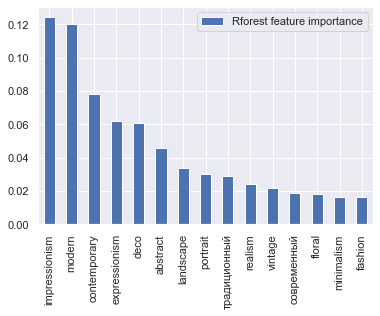

In [317]:
style_rforest_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 4f) Random Forest on Style Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [318]:
from sklearn.ensemble import RandomForestRegressor

In [319]:
from sklearn.decomposition import TruncatedSVD

style_rforest_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=30)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [320]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

style_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/style_rforest_w_tfidf_SVD_pipe.pickle'


#If the model file already exists, I load it:
try:
    with open(style_rforest_w_tfidf_SVD_pipe_filename, 'rb') as f:
        style_rforest_w_tfidf_SVD_pipe = load(f)
        print('Loaded pickle file with random forest model for style tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_rforest_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_rforest_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(style_rforest_w_tfidf_SVD_pipe, f, recurse=True) 
        print('Saved pickle file with random forest model for style tags (after Tf-Idf and SVD).')

Loaded pickle file with random forest model for style tags (after Tf-Idf and SVD).


In [321]:
#Predict prices on training set:
prices_train_pred = style_rforest_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_rforest_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.05975391434543209

In [322]:
#Predict prices on test set:
prices_test_pred = style_rforest_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_rforest_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.05883669777992384

In [323]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using style tags (after Tf-Idf and SVD reduction)')


Random Forest model using style tags (after Tf-Idf and SVD reduction):
Training R^2: 0.05975391434543209
Testing R^2: 0.05883669777992384
Training RMSE: USD 136.49878665948566
Testing RMSE: USD 137.8999657607804
Training MAE: USD 110.39382920890638
Testing MAE: USD 111.60393502707916


In [324]:
#what are the main features used for decision?
style_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_

array([0.02656195, 0.02155367, 0.02049749, 0.07636925, 0.02616019,
       0.02089953, 0.02482119, 0.06672033, 0.02875319, 0.04023844,
       0.05195261, 0.02487505, 0.03653364, 0.02772886, 0.02740262,
       0.02619401, 0.01880634, 0.01557948, 0.0394113 , 0.02070469,
       0.02188809, 0.01893436, 0.03005605, 0.01683279, 0.02158101,
       0.06816382, 0.04863894, 0.05053846, 0.03465629, 0.04694635])

In [325]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_rforest_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    #print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

In [326]:
#What are the style words or word combos that are used most by the random forest regressor?
style_rforest_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
style_rforest_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_rforest_w_tfidf_SVD_features_imp_df = style_rforest_w_tfidf_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
style_rforest_w_tfidf_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
3                     0.076369   
25                    0.068164   
7                     0.066720   
10                    0.051953   
27                    0.050538   
26                    0.048639   
29                    0.046946   
9                     0.040238   
18                    0.039411   
12                    0.036534   
28                    0.034656   
22                    0.030056   
8                     0.028753   
13                    0.027729   
14                    0.027403   
0                     0.026562   
15                    0.026194   
4                     0.026160   
11                    0.024875   
6                     0.024821   

                                                Topic  
3   [modern(0.73), modern abstract(0.52), contempo...  
25  [deco(0.82), abstract deco(0.48), modern conte...  
7   [impressionism(0.7), floral(-0.5), contemporar...  
10  [modern(0.47), modern abstract(-0.47), contemp...  
27  [traditional(0.91), landscape traditional(0.19...  
26  [modern contemporary(0.63), expressionism abst...  
29  [folk(0.56), contemporary modern(0.35), modern...  
9   [expressionism(0.7), expressionism abstract(0....  
18  [minimalism(0.85), minimalism modern(0.37), mi...  
12  [fantasy(0.95), realism(-0.27), abstract fanta...  
28  [folk(0.78), contemporary modern(-0.27), moder...  
22  [impressionism landscape(0.69), nautical(0.5),...  
8   [vintage(0.97), vintage landscape(0.1), vintag...  
13  [pop(0.97), abstract pop(0.19), landscape abst...  
14  [landscape abstract(0.94), contemporary abstra...  
0   [abstract(0.97), modern(0.15), modern abstract...  
15  [country(0.9), landscape country(0.37), rustic...  
4   [impressionism(0.54), contemporary(0.51), flor...  
11  [realism(0.94), fantasy(0.27), portrait realis...  
6   [floral(0.78), contemporary(-0.43), contempora...

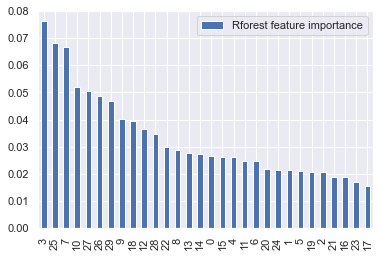

In [327]:
style_rforest_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 4g) Gradient Boosted Trees on Style Tags (vectorized, without Tf-Idf and SVD reduction)

In [328]:
from sklearn.ensemble import GradientBoostingRegressor

In [329]:
style_gboost_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1,min_samples_leaf=10))
])

In [330]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

style_gboost_pipe_filename = './Git_exclude/models/style_gboost_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(style_gboost_pipe_filename, 'rb') as f:
        style_gboost_pipe = load(f)
        print('Loaded pickle file with gradient boosting model for style tags (without Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_gboost_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_gboost_pipe_filename, 'wb') as f:
        dump(style_gboost_pipe, f, recurse=True) 
        print('Saved pickle file with gradient boosting model for style tags (without Tf-Idf and SVD).')

Loaded pickle file with gradient boosting model for style tags (without Tf-Idf and SVD).


In [331]:
#Predict prices on training set:
prices_train_pred = style_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_gboost_pipe.score(paintings_df_train,prices_train)

0.0530967803309621

In [332]:
#Predict prices on test set:
prices_test_pred = style_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_gboost_pipe.score(paintings_df_test,prices_test)

0.05273622286061097

In [333]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using style tags (without Tf-Idf and SVD reduction)')


Gradient Boosting model using style tags (without Tf-Idf and SVD reduction):
Training R^2: 0.0530967803309621
Testing R^2: 0.05273622286061097
Training RMSE: USD 136.9811539724073
Testing RMSE: USD 138.34616699873072
Training MAE: USD 110.90445055070833
Testing MAE: USD 112.1239908639524


In [334]:
#what are the main features used for decision?
style_gboost_pipe['gboost'].feature_importances_

array([0.02909888, 0.00697048, 0.00392049, 0.00711418, 0.00210224,
       0.        , 0.00928004, 0.00474412, 0.00746759, 0.00170136,
       0.00756195, 0.00245787, 0.00897467, 0.06075636, 0.00409228,
       0.0006012 , 0.02181525, 0.07934911, 0.        , 0.04609326,
       0.00774127, 0.02119344, 0.01335539, 0.00458839, 0.005155  ,
       0.00237456, 0.00192867, 0.00136115, 0.00185815, 0.13423088,
       0.00512709, 0.00149937, 0.00033939, 0.02117819, 0.00535701,
       0.00575218, 0.00175259, 0.01468309, 0.00334133, 0.12301708,
       0.01369798, 0.01200706, 0.01944849, 0.00181415, 0.01179098,
       0.01133168, 0.03446103, 0.000859  , 0.02745413, 0.00394348,
       0.0039989 , 0.01575697, 0.00374165, 0.02086752, 0.00586042,
       0.0015116 , 0.01052525, 0.00700612, 0.00060256, 0.00288018,
       0.00180278, 0.01323381, 0.02957989, 0.00373051, 0.00526494,
       0.01151183, 0.00718835, 0.00326338, 0.03492977])

In [335]:
feature_names_style_gboost = style_gboost_pipe['style tags vectorization'].named_transformers_['style tags vectorizer'][-1].get_feature_names()

In [336]:
feature_names_style_gboost

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

In [337]:
style_gboost_features_imp_df = pd.DataFrame(style_gboost_pipe['gboost'].feature_importances_,feature_names_style_gboost,columns=['Gboost feature importance'])
style_gboost_features_imp_df = style_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
style_gboost_features_imp_df

Gboost feature importance
impressionism                   0.134231
modern                          0.123017
deco                            0.079349
contemporary                    0.060756
expressionism                   0.046093
...                                  ...
steampunk                       0.000603
country                         0.000601
kitsch                          0.000339
automobilia                     0.000000
edwardian                       0.000000

[69 rows x 1 columns]

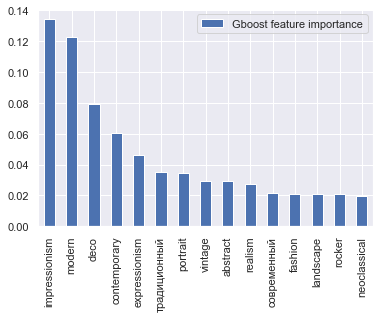

In [338]:
style_gboost_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 4h) Gradient Boosted Trees on Style Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [339]:
from sklearn.ensemble import GradientBoostingRegressor

In [340]:
from sklearn.decomposition import TruncatedSVD

style_gboost_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=30)),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1,min_samples_leaf=10))
])

In [341]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

style_gboost_w_tfidf_SVD_pipe_filename = './Git_exclude/models/style_gboost_w_tfidf_SVD_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(style_gboost_w_tfidf_SVD_pipe_filename, 'rb') as f:
        style_gboost_w_tfidf_SVD_pipe = load(f)
        print('Loaded pickle file with gradient boosting model for style tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_gboost_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_gboost_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(style_gboost_w_tfidf_SVD_pipe, f, recurse=True) 
        print('Saved pickle file with gradient boosting model for style tags (after Tf-Idf and SVD).')

Loaded pickle file with gradient boosting model for style tags (after Tf-Idf and SVD).


In [342]:
#Predict prices on training set:
prices_train_pred = style_gboost_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_gboost_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.06064360545595737

In [343]:
#Predict prices on test set:
prices_test_pred = style_gboost_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_gboost_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.05978260966806226

In [344]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using style tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using style tags (after Tf-Idf and SVD reduction):
Training R^2: 0.06064360545595737
Testing R^2: 0.05978260966806226
Training RMSE: USD 136.43419160263494
Testing RMSE: USD 137.830650474051
Training MAE: USD 110.37624849037783
Testing MAE: USD 111.5990781720319


In [345]:
#what are the main features used for decision?
style_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_

array([0.0423274 , 0.01177199, 0.01342351, 0.12925688, 0.00838084,
       0.01990417, 0.01357001, 0.05467305, 0.02818178, 0.03857012,
       0.03822802, 0.0176636 , 0.0371523 , 0.0509471 , 0.02115733,
       0.02458908, 0.01131358, 0.01379839, 0.04042958, 0.03272556,
       0.03936714, 0.01025155, 0.03527261, 0.0150102 , 0.03249257,
       0.07014796, 0.07578225, 0.01650237, 0.03120649, 0.02590256])

In [346]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_gboost_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    #print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

In [347]:
#What are the style words or word combos that are used most by the random forest regressor?
style_gboost_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
style_gboost_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_gboost_w_tfidf_SVD_features_imp_df = style_gboost_w_tfidf_SVD_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
style_gboost_w_tfidf_SVD_features_imp_df.iloc[:20]

Gboost feature importance  \
3                    0.129257   
26                   0.075782   
25                   0.070148   
7                    0.054673   
13                   0.050947   
0                    0.042327   
18                   0.040430   
20                   0.039367   
9                    0.038570   
10                   0.038228   
12                   0.037152   
22                   0.035273   
19                   0.032726   
24                   0.032493   
28                   0.031206   
8                    0.028182   
29                   0.025903   
15                   0.024589   
14                   0.021157   
5                    0.019904   

                                                Topic  
3   [modern(0.73), modern abstract(0.52), contempo...  
26  [modern contemporary(0.63), expressionism abst...  
25  [deco(0.81), abstract deco(0.47), modern conte...  
7   [impressionism(0.7), floral(-0.5), contemporar...  
13  [pop(0.97), abstract pop(0.19), landscape abst...  
0   [abstract(0.97), modern(0.15), modern abstract...  
18  [minimalism(0.85), minimalism modern(0.37), mi...  
20  [whimsical(0.97), abstract whimsical(0.15), am...  
9   [expressionism(0.7), expressionism abstract(0....  
10  [modern(0.47), modern abstract(-0.47), contemp...  
12  [fantasy(0.95), realism(-0.27), abstract fanta...  
22  [impressionism landscape(0.69), nautical(0.5),...  
19  [american(0.88), african(0.36), african americ...  
24  [century(0.83), modern contemporary(-0.26), ce...  
28  [folk(0.78), contemporary modern(-0.27), moder...  
8   [vintage(0.97), vintage landscape(0.1), vintag...  
29  [folk(0.55), contemporary modern(0.36), modern...  
15  [country(0.9), landscape country(0.37), rustic...  
14  [landscape abstract(0.94), contemporary abstra...  
5   [beach(0.93), contemporary(-0.24), contemporar...

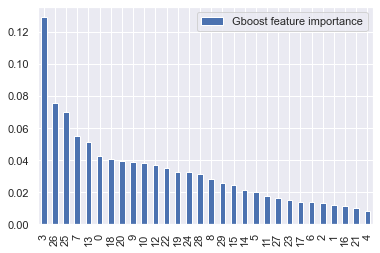

In [348]:
style_gboost_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 5) Models using only the 'materials' tags (note that these include some color information as well)

In [349]:
all_paintings_df['materials_tags_new'].iloc[1]

"['acrylic', 'mixed', 'canvas', 'love', 'board', 'media', 'red']"

In [350]:
all_paintings_df['materials_tags_new'].value_counts()

['stretched', 'canvas']                                                                                                                    3629
['acrylic', 'stretched', 'canvas']                                                                                                         2364
['paper', 'watercolor']                                                                                                                    2255
['stretched', 'oil', 'canvas']                                                                                                             2185
['acrylic', 'canvas']                                                                                                                      1640
                                                                                                                                           ... 
['knife', 'palette', 'oil', 'canvas', 'linen', 'stretched']                                                                             

In [351]:
#As for style, I start by using the 'DictVectorizer' provided by scikit-learn. 
#However, before I can use 'DictVectorizer' I need to convert my list of strings into array of dictionaries.
#I do that with a 'DictEncoder' already defined earlier:

In [352]:
# #Recall: 

# from sklearn.base import BaseEstimator, TransformerMixin
# class DictEncoder(BaseEstimator, TransformerMixin):
#     @staticmethod
#     def stringlist_to_dict(stringlist):
#         dict = {}
#         for string in stringlist:
#             dict[string]=1
#         return dict
      
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series of strings representing lists of strings. Return a pandas series of dictionaries
#         return X.apply(eval).apply(stringlist_to_dict)

In [353]:
all_paintings_df['materials_tags_new'].apply(eval).apply(stringlist_to_dict)

0        {'acrylic': 1, 'mixed': 1, 'yellow': 1, 'canva...
1        {'acrylic': 1, 'mixed': 1, 'canvas': 1, 'love'...
2          {'green': 1, 'red': 1, 'canvas': 1, 'board': 1}
3        {'acrylic': 1, 'panel': 1, 'ink': 1, 'acrylics...
4                    {'water': 1, 'canvas': 1, 'board': 1}
                               ...                        
68549    {'white': 1, 'yellow': 1, 'purple': 1, 'canvas...
68550          {'acrylic': 1, 'stretched': 1, 'canvas': 1}
68551                              {'oil': 1, 'canvas': 1}
68552              {'acrylic': 1, 'canvas': 1, 'board': 1}
68553    {'oil': 1, 'canvas': 1, 'stretched': 1, 'water...
Name: materials_tags_new, Length: 68554, dtype: object

In [354]:
from sklearn.feature_extraction import DictVectorizer

pipe_materials_tags_encoding = Pipeline([
    ('to dict series',DictEncoder()),
    ('to binary vectors',DictVectorizer())
])

In [355]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
materials_tranform = ColumnTransformer([
    ('materials tags vectorizer', pipe_materials_tags_encoding, 'materials_tags_new'),
], remainder='drop')

In [356]:
#Let's test this in isolation, which will also enable me to extract the name of the style tags in the order in which they'll appear 
#in the regression models
materials_tranform.fit_transform(paintings_df_train)

<54843x100 sparse matrix of type '<class 'numpy.float64'>'
	with 199927 stored elements in Compressed Sparse Row format>

In [357]:
materials_vectorizer_feature_names = materials_tranform.named_transformers_['materials tags vectorizer'][-1].feature_names_

In [358]:
materials_vectorizer_feature_names

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue',
 'board',
 'brush',
 'brushes',
 'canvas',
 'cardboard',
 'charcoal',
 'clear',
 'cold',
 'collage',
 'cotton',
 'epoxy',
 'fabric',
 'fine',
 'finish',
 'floetrol',
 'frame',
 'framed',
 'gel',
 'gesso',
 'glass',
 'glitter',
 'gloss',
 'gold',
 'golden',
 'gouache',
 'grade',
 'graphite',
 'green',
 'hand',
 'hang',
 'hanger',
 'hanging',
 'hardboard',
 'hardware',
 'heavy',
 'ink',
 'knife',
 'lb',
 'leaf',
 'linen',
 'liquitex',
 'love',
 'marker',
 'mat',
 'matte',
 'media',
 'metal',
 'metallic',
 'mixed',
 'newton',
 'oil',
 'oils',
 'painted',
 'palette',
 'panel',
 'paper',
 'paste',
 'pastel',
 'pen',
 'pencil',
 'pigment',
 'pigments',
 'premium',
 'press',
 'pressed',
 'print',
 'protective',
 'purple',
 'red',
 'resin',
 'satin',
 'spray',
 'stretched',
 'stretcher',
 'texture',
 'thick',
 'unframed',
 'uv',
 'varnish',
 'water',
 'watercolor',
 'watercolors',
 'whit

### 5a) Ridge regression of materials tags only, after vectorization

Since there are a large number of features, one for each possible materials tag (there are 100), cross validation is critical to prevent overfitting.

In [359]:
from sklearn.linear_model import Ridge

materials_ridge_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('ridge',Ridge(alpha=10))
])

In [360]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
materials_ridge_CVmodel = GridSearchCV(materials_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [361]:
#Train the model
materials_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('materials tags vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'materials_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [362]:
materials_ridge_CVmodel.best_params_

{'ridge__alpha': 18.329807108324356}

In [363]:
#Predict prices on training set:
prices_train_pred = materials_ridge_CVmodel.predict(paintings_df_train)

In [364]:
#And return the R2 score as follows:
materials_ridge_CVmodel.score(paintings_df_train,prices_train)

0.056525382069379626

In [365]:
#Predict prices on test set:
prices_test_pred = materials_ridge_CVmodel.predict(paintings_df_test)

In [366]:
#And return the R2 score as follows:
materials_ridge_CVmodel.score(paintings_df_test,prices_test)

0.06297137176154055

In [367]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using the vectorized materials tags')

Ridge regression model using the vectorized materials tags:
Training R^2: 0.056525382069379626
Testing R^2: 0.06297137176154055
Training RMSE: USD 136.73293444917164
Testing RMSE: USD 137.59672455335598
Training MAE: USD 109.97189236633368
Testing MAE: USD 110.60108358787446


In [368]:
#Which are the largest regression coefficients in the regression model?
materials_ridge_reg_coeff_df = pd.DataFrame(materials_ridge_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
materials_ridge_reg_coeff_df['Feature']=pd.Series(materials_vectorizer_feature_names)
materials_ridge_reg_coeff_df = materials_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
materials_ridge_reg_coeff_df.set_index(['Feature'])


Regression coefficients
Feature                            
protective                61.999041
winsor                    55.822758
lb                        53.859490
satin                     47.479019
oil                       40.617917
...                             ...
pastel                   -24.774744
print                    -28.899743
metallic                 -33.116327
floetrol                 -37.465497
140                      -42.708482

[100 rows x 1 columns]

### 5b) Decision tree of materials tags only, after vectorization

In [369]:
from sklearn.pipeline import Pipeline

materials_dtree_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15,min_samples_leaf=10)),
])

In [370]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} 
materials_dtree_CVmodel = GridSearchCV(materials_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [371]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

materials_dtree_CVmodel_filename = './Git_exclude/models/materials_dtree_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(materials_dtree_CVmodel_filename, 'rb') as f:
        materials_dtree_CVmodel = load(f)
        print('Loaded pickle file with decision tree model for materials tags (vectorized but without tf-idf.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(materials_dtree_CVmodel_filename, 'wb') as f:
        dump(materials_dtree_CVmodel, f, recurse=True) 
        print('Saved pickle file with decision tree model for materials tags (vectorized but without tf-idf).')



Loaded pickle file with decision tree model for materials tags (vectorized but without tf-idf.


In [372]:
materials_dtree_CVmodel.best_params_['dtree__max_depth']

8

In [373]:
#Predict prices on training set:
prices_train_pred = materials_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
materials_dtree_CVmodel.score(paintings_df_train,prices_train)

0.0788190006538726

In [374]:
#Predict prices on test set:
prices_test_pred = materials_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
materials_dtree_CVmodel.score(paintings_df_test,prices_test)

0.06434197241243311

In [375]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only materials tags')


Decision Tree model using only materials tags:
Training R^2: 0.0788190006538726
Testing R^2: 0.06434197241243311
Training RMSE: USD 135.1078271679937
Testing RMSE: USD 137.49605571134614
Training MAE: USD 107.98280813746474
Testing MAE: USD 109.94917803291867


In [376]:
feature_names_materials_dtree = materials_dtree_CVmodel.best_estimator_['materials tags vectorization'].named_transformers_['materials tags vectorizer']['to binary vectors'].get_feature_names()

materials_dtree_features_imp_df = pd.DataFrame(materials_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_materials_dtree,columns=['Dtree feature importance'])
materials_dtree_features_imp_df = materials_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
materials_dtree_features_imp_df.iloc[:20]

Dtree feature importance
oil                         0.363721
paper                       0.065685
acrylic                     0.054206
brush                       0.042879
painted                     0.026994
canvas                      0.026464
protective                  0.023199
texture                     0.023085
black                       0.020451
watercolor                  0.019141
unframed                    0.019049
varnish                     0.018086
fine                        0.016464
media                       0.014807
hand                        0.014417
love                        0.013802
pencil                      0.013635
frame                       0.013571
white                       0.011691
satin                       0.010245

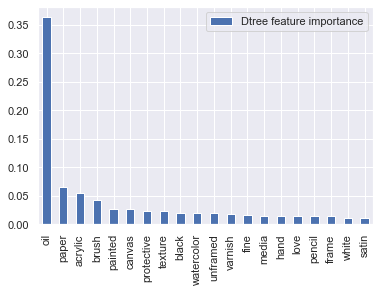

In [377]:
materials_dtree_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

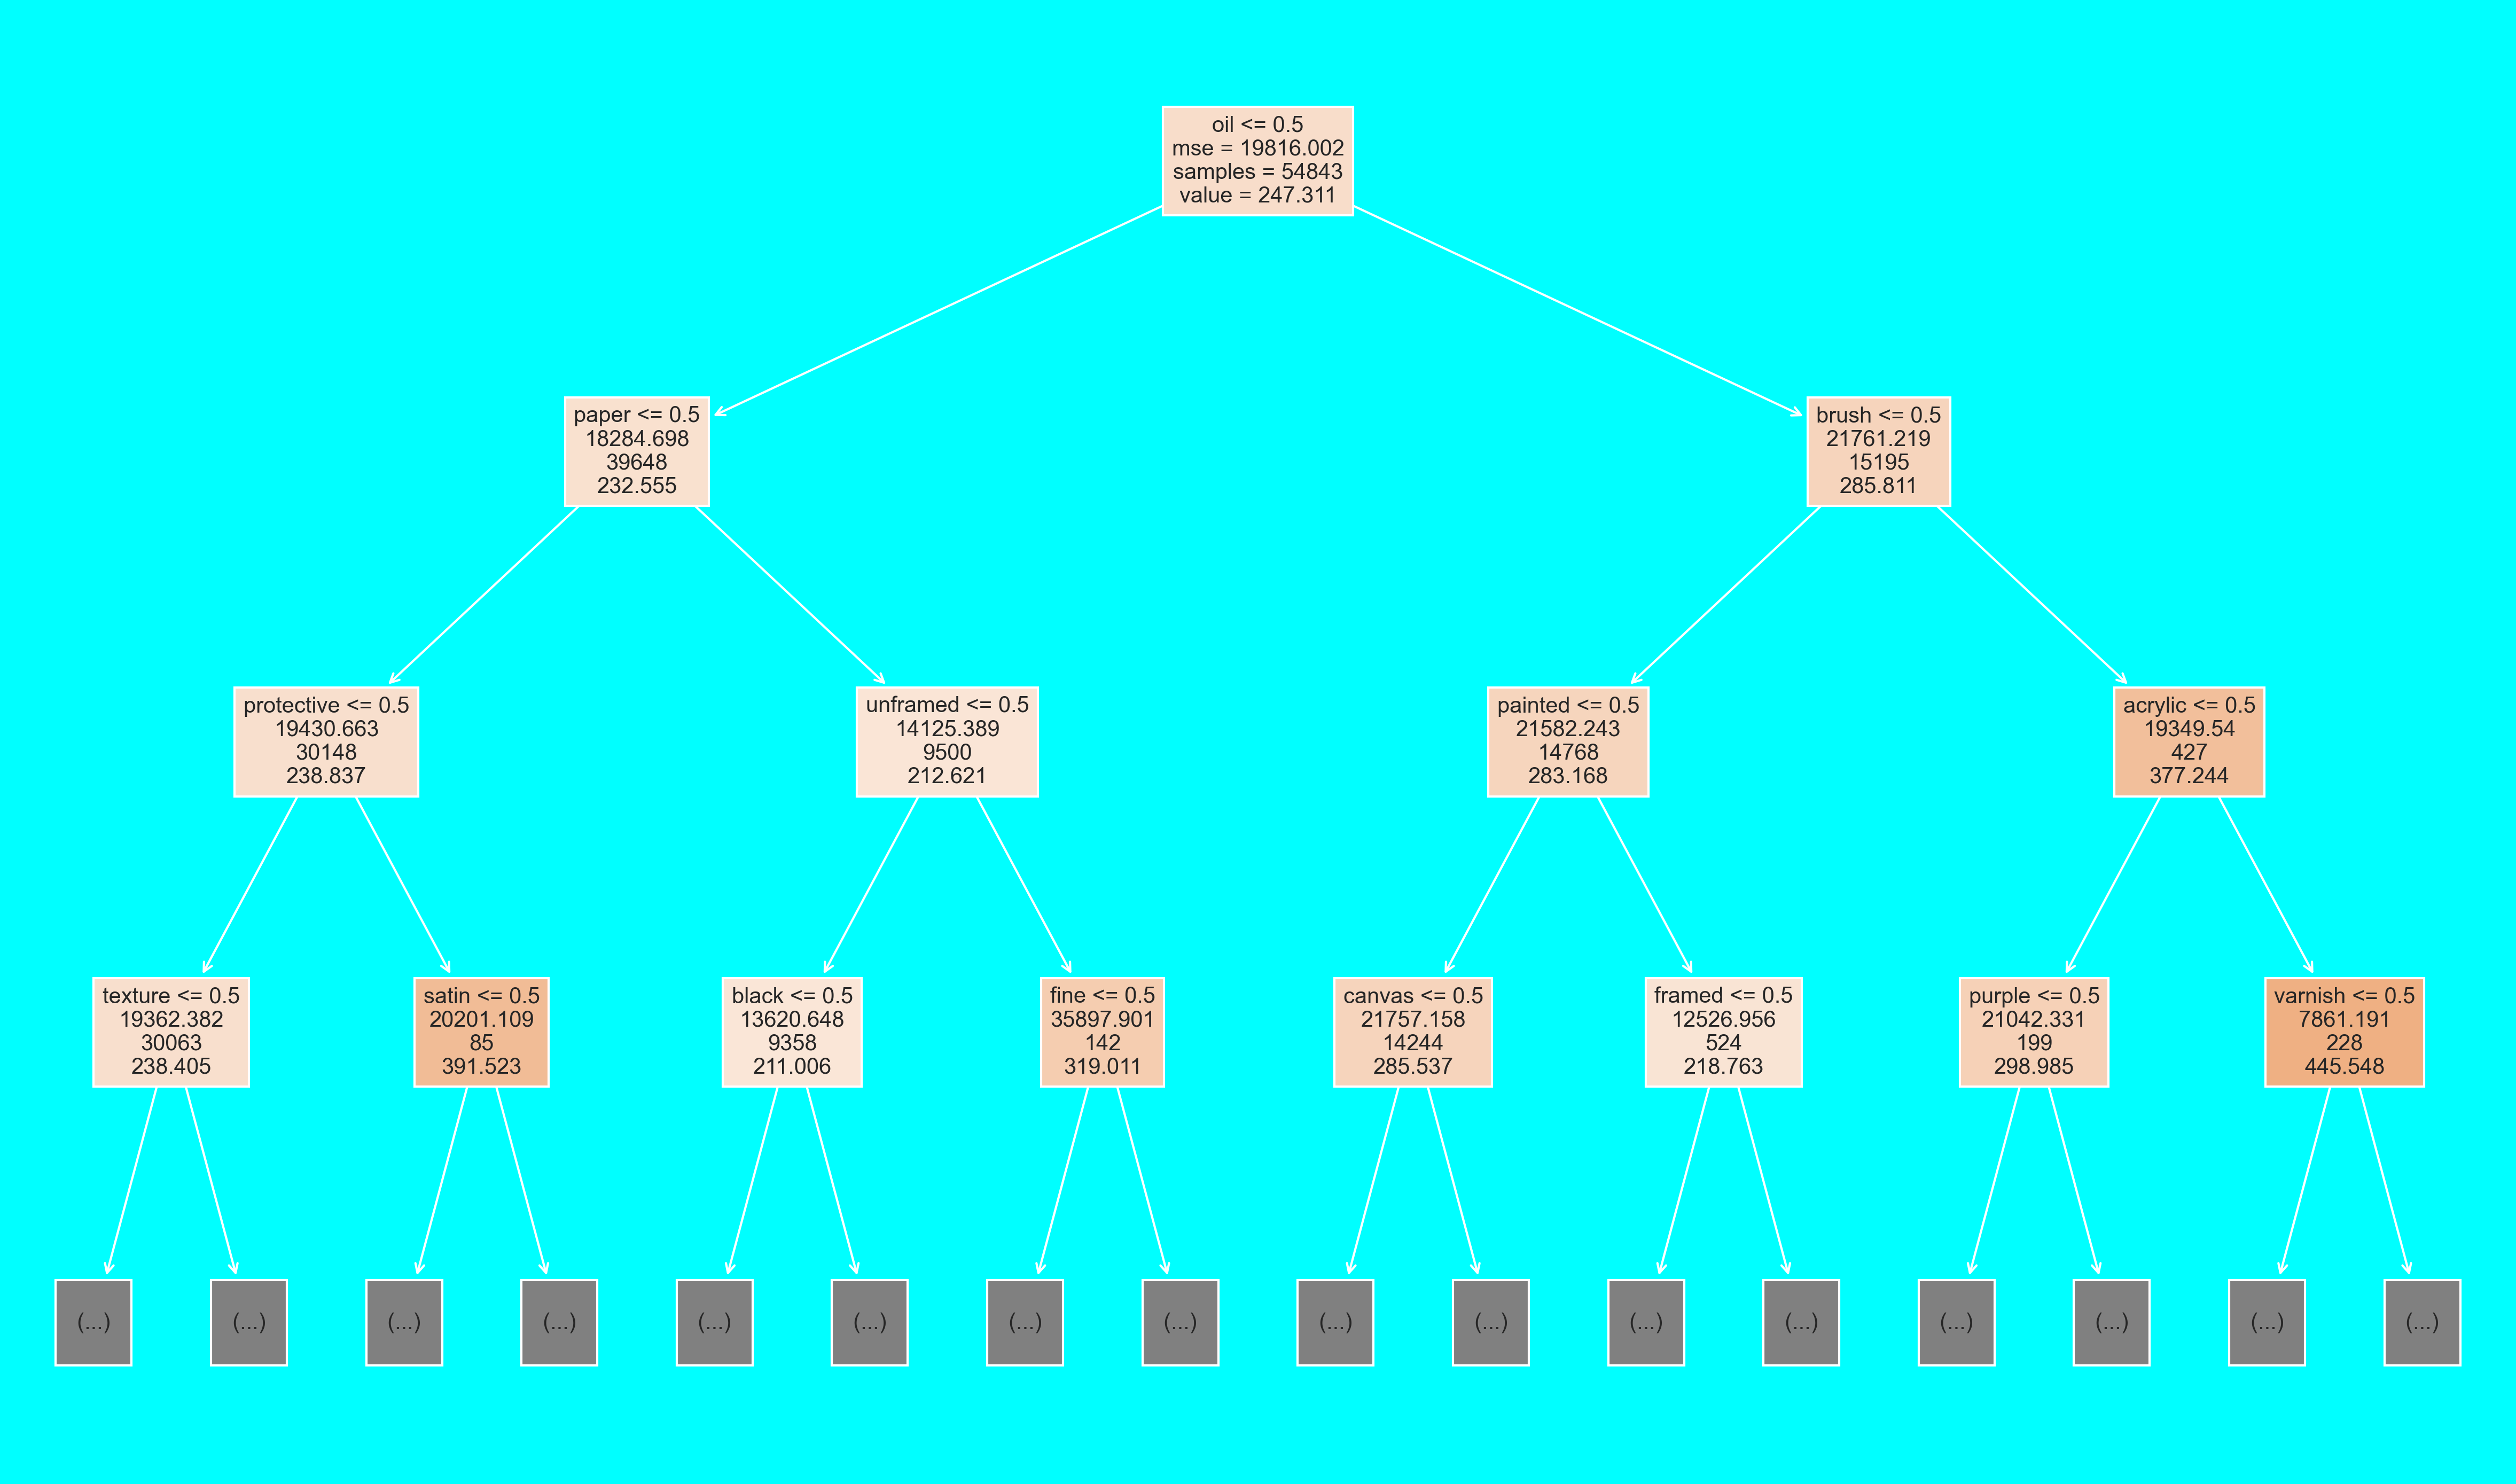

In [378]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(materials_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_materials_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_materials_no_tfidf.png')

### 5c) Ridge regression of materials tags only, after Tf-Idf vectorization (up to bigrams) and optional dimensionality reduction

In [379]:
from sklearn.feature_extraction.text import TfidfTransformer #TfidfVectorizer

In [380]:
from sklearn.linear_model import Ridge

materials_ridge_w_tfidf_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('tfid', TfidfTransformer()), 
    ('ridge',Ridge(alpha=10))
])

In [381]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
materials_ridge_w_tfidf_CVmodel = GridSearchCV(materials_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [382]:
#Train the model
materials_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('materials tags vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'materials_tags_new')])),
                                       ('tfid', TfidfTransformer()),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [383]:
materials_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [384]:
#Predict prices on training set:
prices_train_pred = materials_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [385]:
#And return the R2 score as follows:
materials_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.05431204780088528

In [386]:
#Predict prices on test set:
prices_test_pred = materials_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [387]:
#And return the R2 score as follows:
materials_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.05581389291916605

In [388]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized materials tags with Tf-Idf')

Ridge regression model using vectorized materials tags with Tf-Idf:
Training R^2: 0.05431204780088528
Testing R^2: 0.05581389291916605
Training RMSE: USD 136.89322408513053
Testing RMSE: USD 138.12124007066345
Training MAE: USD 110.10318968207521
Testing MAE: USD 111.09529809906478


### Method of implementing Tf-Idf - instead of going through the DictVectorizer - using TfIdfVectorizer, that enables to also use n-grams (i.e. sequences of words in addition to individual words) 
#### The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'materials tags' column as follows (essentially joining the strings in the list)

In [389]:
# #Recall that this was implemented earlier for the style tags
# from sklearn.base import BaseEstimator, TransformerMixin
# class TagsEncoder(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
#         return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [390]:
all_paintings_df['materials_tags_new'].iloc[0]

"['acrylic', 'mixed', 'yellow', 'canvas', 'board', 'media', 'red']"

In [391]:
all_paintings_df['materials_tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0           acrylic mixed yellow canvas board media red
1             acrylic mixed canvas love board media red
2                                green red canvas board
3            acrylic panel ink acrylics purple blue red
4                                    water canvas board
                              ...                      
68549    white yellow purple canvas stretched green red
68550                          acrylic stretched canvas
68551                                        oil canvas
68552                              acrylic canvas board
68553                        oil canvas stretched water
Name: materials_tags_new, Length: 68554, dtype: object

In [392]:
#Let's count n-grams of up to 2 words

In [393]:
# #Recall that this was implemented earlier for the style tags
# from sklearn.feature_extraction.text import TfidfVectorizer

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

In [394]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
materials_tags_tranform = ColumnTransformer([
    ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
], remainder='drop')

In [395]:
#I first fit_transform the training data by itself to extract the feature names to later
#retrieve them for interpreting the results
materials_tags_tranform.fit_transform(paintings_df_train)

<54843x4181 sparse matrix of type '<class 'numpy.float64'>'
	with 345011 stored elements in Compressed Sparse Row format>

In [396]:
materials_tags_tranform.named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()[:10]

['140',
 '140 acid',
 '140 arches',
 '140 archival',
 '140 blue',
 '140 canvas',
 '140 grade',
 '140 graphite',
 '140 green',
 '140 hand']

In [397]:
#the inverse frequencies can be extracted as follows:
materials_tags_tranform.named_transformers_['materials tags tfidf']['to tfidf n-grams'].idf_

array([ 7.02944615, 11.21910089,  8.32872913, ...,  8.6164112 ,
       11.21910089, 11.21910089])

In [398]:
#Now put everything in a pipeline with Ridge Regression
from sklearn.linear_model import Ridge

materials_tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [399]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
materials_tags_ridge_w_tfidf_CVmodel = GridSearchCV(materials_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [400]:
#Train the model
materials_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   49.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   53.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'materials_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [401]:
materials_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 3.0}

In [402]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_materials_ridge_tfidf = materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

materials_ridge_reg_coeff_df = pd.DataFrame(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_materials_ridge_tfidf,columns=['Regression coefficients'])
materials_ridge_reg_coeff_df = materials_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
materials_ridge_reg_coeff_df

Regression coefficients
unframed paper                 301.299962
acrylic pencil                 243.324323
protective satin               234.272727
wooden oil                     225.164927
brush varnish                  217.926694
...                                   ...
frame palette                 -126.361090
ink aluminum                  -127.045241
board canvas                  -134.909739
palette paper                 -142.247850
hang brush                    -229.545888

[4181 rows x 1 columns]

In [403]:
#Predict prices on training set:
prices_train_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [404]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.12798993283546478

In [405]:
#Predict prices on test set:
prices_test_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [406]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.09128688915352823

In [407]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized materials tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using vectorized materials tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.12798993283546478
Testing R^2: 0.09128688915352823
Training RMSE: USD 131.4524767674482
Testing RMSE: USD 135.50179954912383
Training MAE: USD 104.44686565754135
Testing MAE: USD 107.81091975867474


#### Adding optional dimensionality reduction before computing the regressor

In [408]:
from sklearn.decomposition import TruncatedSVD

materials_tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [409]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,4), 'SVD__n_components': range(2,112,4)} 
#materials_tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(materials_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
materials_tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(materials_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [410]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

materials_tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/materials_tags_SVD_ridge_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(materials_tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        materials_tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded pickle file with ridge regression model for materials tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(materials_tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(materials_tags_ridge_w_tfidf_SVD_CVmodel, f, recurse=True) 
        print('Saved pickle file with ridge regression model for materials tags vectorized with tf-idf and reduced with SVD.')

Loaded pickle file with ridge regression model for materials tags vectorized with tf-idf and reduced with SVD.


In [411]:
materials_tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 110, 'ridge__alpha': 1.0}

In [412]:
#Predict prices on training set:
prices_train_pred = materials_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [413]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.054729794603470494

In [414]:
#Predict prices on test set:
prices_test_pred = materials_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [415]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.05440479881093219

In [416]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized materials tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized materials tags with Tf-Idf followed by SVD:
Training R^2: 0.054729794603470494
Testing R^2: 0.05440479881093219
Training RMSE: USD 136.86298523979457
Testing RMSE: USD 138.2242670395317
Training MAE: USD 110.11450902645653
Testing MAE: USD 111.36664418816859


In [417]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [418]:
materials_feature_names = materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

In [419]:
# Get Singular values and Components 
Sigma = materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([74.62903647, 56.75411002, 56.12456568, 47.3584639 , 38.33607099,
       37.25485855, 34.38751278, 33.2679579 , 31.16833094, 29.05622361,
       27.41667218, 25.71524015, 25.13962701, 22.74444097, 21.96227322,
       21.86542131, 21.20313846, 20.45367509, 20.23193375, 20.03108523,
       19.70925754, 19.55281138, 19.16115206, 18.76394155, 18.07800364,
       17.97066141, 17.91053712, 17.43824136, 17.23589664, 17.07054151,
       16.80637398, 16.77492287, 15.96685797, 15.745643  , 15.5779152 ,
       15.25886285, 14.87089269, 14.7067706 , 14.54338066, 14.40161383,
       14.24800434, 13.93681994, 13.54569256, 13.07793263, 12.57506942,
       12.47904147, 12.21185048, 12.16311953, 12.00429479, 11.96471769,
       11.86775441, 11.70499832, 11.69577367, 11.50986881, 11.42432386,
       11.33367077, 11.32551102, 11.27696657, 11.01750891, 10.97273053,
       10.80269496, 10.74864606, 10.70716722, 10.61564714, 10.58974846,
       10.54786872, 10.47936181, 10.394986  , 10.20813065, 10.16

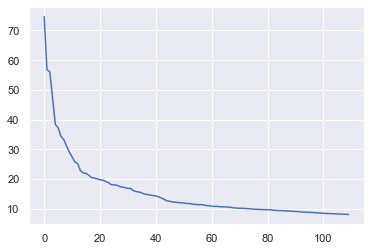

In [420]:
plt.plot(Sigma)

In [421]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

Topic 0:  ['stretched canvas(0.5)', 'canvas(0.49)', 'stretched(0.48)']
Topic 1:  ['oil(0.58)', 'oil canvas(0.49)', 'stretched canvas(-0.45)']
Topic 2:  ['paper(0.65)', 'watercolor(0.55)', 'paper watercolor(0.47)']
Topic 3:  ['acrylic(0.68)', 'acrylic canvas(0.52)', 'stretched canvas(-0.31)']
Topic 4:  ['canvas board(0.58)', 'board(0.56)', 'wood(-0.24)']
Topic 5:  ['wood(0.49)', 'hardboard wood(0.48)', 'hardboard(0.47)']
Topic 6:  ['blue(0.52)', 'blue canvas(0.47)', 'canvas stretched(0.31)']
Topic 7:  ['paper(0.64)', 'watercolor(-0.61)', 'acrylic canvas(-0.26)']
Topic 8:  ['acrylic stretched(0.55)', 'acrylic canvas(-0.52)', 'acrylic(0.36)']
Topic 9:  ['framed(0.5)', 'framed canvas(0.38)', 'oil framed(0.38)']
Topic 10:  ['stretched oil(0.6)', 'oil(-0.42)', 'framed(0.3)']
Topic 11:  ['fine(0.57)', 'canvas fine(0.34)', 'black(0.25)']
Topic 12:  ['fine(0.55)', 'canvas fine(0.39)', 'black(-0.32)']
Topic 13:  ['acrylic stretched(-0.66)', 'acrylic paper(0.37)', 'acrylic(0.32)']
Topic 14:  ['ha

In [422]:
#Which are the largest regression coefficients in the regression model?
feature_names_materials_ridge_tfidf = materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

materials_ridge_SVD_reg_coeff_df = pd.DataFrame(materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
materials_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_materials_topics)
materials_ridge_SVD_reg_coeff_df = materials_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
materials_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients  \
108                73.045544   
44                 69.733577   
35                 63.511081   
83                 62.723596   
56                 62.565586   
1                  59.876869   
38                 58.820047   
60                 58.133298   
57                 58.047711   
54                 56.500194   

                                                 Topic  
108  [spray(0.3), canvas green(0.23), green paper(-...  
44   [brush(0.54), canvas brush(0.5), canvas varnis...  
35   [texture(0.51), texture canvas(0.44), stretche...  
83   [metal(0.57), red canvas(0.29), stretched red(...  
56   [canvas water(-0.53), wrapped(0.45), watercolo...  
1    [oil(0.58), oil canvas(0.49), stretched canvas...  
38   [oil blue(0.44), acrylic blue(-0.41), acrylic ...  
60   [framed paper(-0.32), oil paper(0.3), acrylic ...  
57   [wrapped(0.33), canvas water(0.31), frame oil(...  
54   [wrapped(0.31), frame oil(0.25), stretched red...

In [423]:
materials_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients  \
75                -54.365401   
94                -54.460101   
96                -56.014996   
66                -58.720313   
32                -60.582907   
77                -63.366779   
2                 -70.468340   
16                -79.430474   
36                -84.904977   
106               -96.430407   

                                                 Topic  
75   [gouache(0.49), gouache paper(0.32), unframed(...  
94   [fabric(0.66), paper black(-0.24), brushes(-0.2)]  
96   [fine watercolor(0.34), fabric(-0.3), white oi...  
66   [yellow blue(0.28), oil paper(-0.23), blue can...  
32   [print(0.66), print canvas(0.36), framed paper...  
77   [acrylic purple(-0.34), purple canvas(-0.29), ...  
2    [paper(0.65), watercolor(0.55), paper watercol...  
16      [hand(0.36), oil canvas(-0.34), painted(0.32)]  
36   [wood oil(0.4), canvas fine(0.4), paper fine(-...  
106  [canvas watercolor(0.3), acrylic framed(-0.2),...

### 5d) Decision tree of materials tags only, after Tf-Idf vectorization using up to bigrams, and with optional dimensionality reduction

In [424]:
from sklearn.pipeline import Pipeline

materials_dtree_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15,min_samples_leaf=10)),
])

In [425]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)}  
materials_dtree_w_tfidf_CVmodel = GridSearchCV(materials_dtree_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [426]:
materials_dtree_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:  3.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'materials_tags_new')])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=15,
                                                              min_samples_leaf=10))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 51, 2)},
             verbose=1)

In [427]:
materials_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']

12

In [428]:
#Predict prices on training set:
prices_train_pred = materials_dtree_w_tfidf_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
materials_dtree_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.0977429884522204

In [429]:
#Predict prices on test set:
prices_test_pred = materials_dtree_w_tfidf_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
materials_dtree_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.07747633038177737

In [430]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only materials tags, after Tf-Idf')


Decision Tree model using only materials tags, after Tf-Idf:
Training R^2: 0.0977429884522204
Testing R^2: 0.07747633038177737
Training RMSE: USD 133.71285343236903
Testing RMSE: USD 136.52759024330473
Training MAE: USD 106.4745766867927
Testing MAE: USD 108.66988605167391


In [431]:
#What are the style words or word combos that are used most by the tree regressor?
feature_names_materials_dtree_w_tfidf = materials_dtree_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

materials_dtree_w_tfidf_features_imp_df = pd.DataFrame(materials_dtree_w_tfidf_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_materials_dtree_w_tfidf,columns=['Dtree feature importance'])
materials_dtree_w_tfidf_features_imp_df = materials_dtree_w_tfidf_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
materials_dtree_w_tfidf_features_imp_df.iloc[:20]

Dtree feature importance
oil                               0.296859
paper                             0.064439
canvas                            0.057099
brush varnish                     0.040936
unframed                          0.039094
protective satin                  0.026895
watercolor                        0.024329
stretched                         0.021764
fine                              0.020787
acrylic                           0.020672
texture                           0.020566
wrapped                           0.020286
wooden oil                        0.019214
print canvas                      0.017302
love hanging                      0.016298
archival ink                      0.016204
black                             0.016086
acrylic pencil                    0.012985
white                             0.012589
acrylic oil                       0.011652

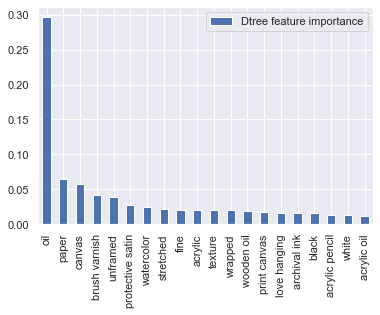

In [432]:
materials_dtree_w_tfidf_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

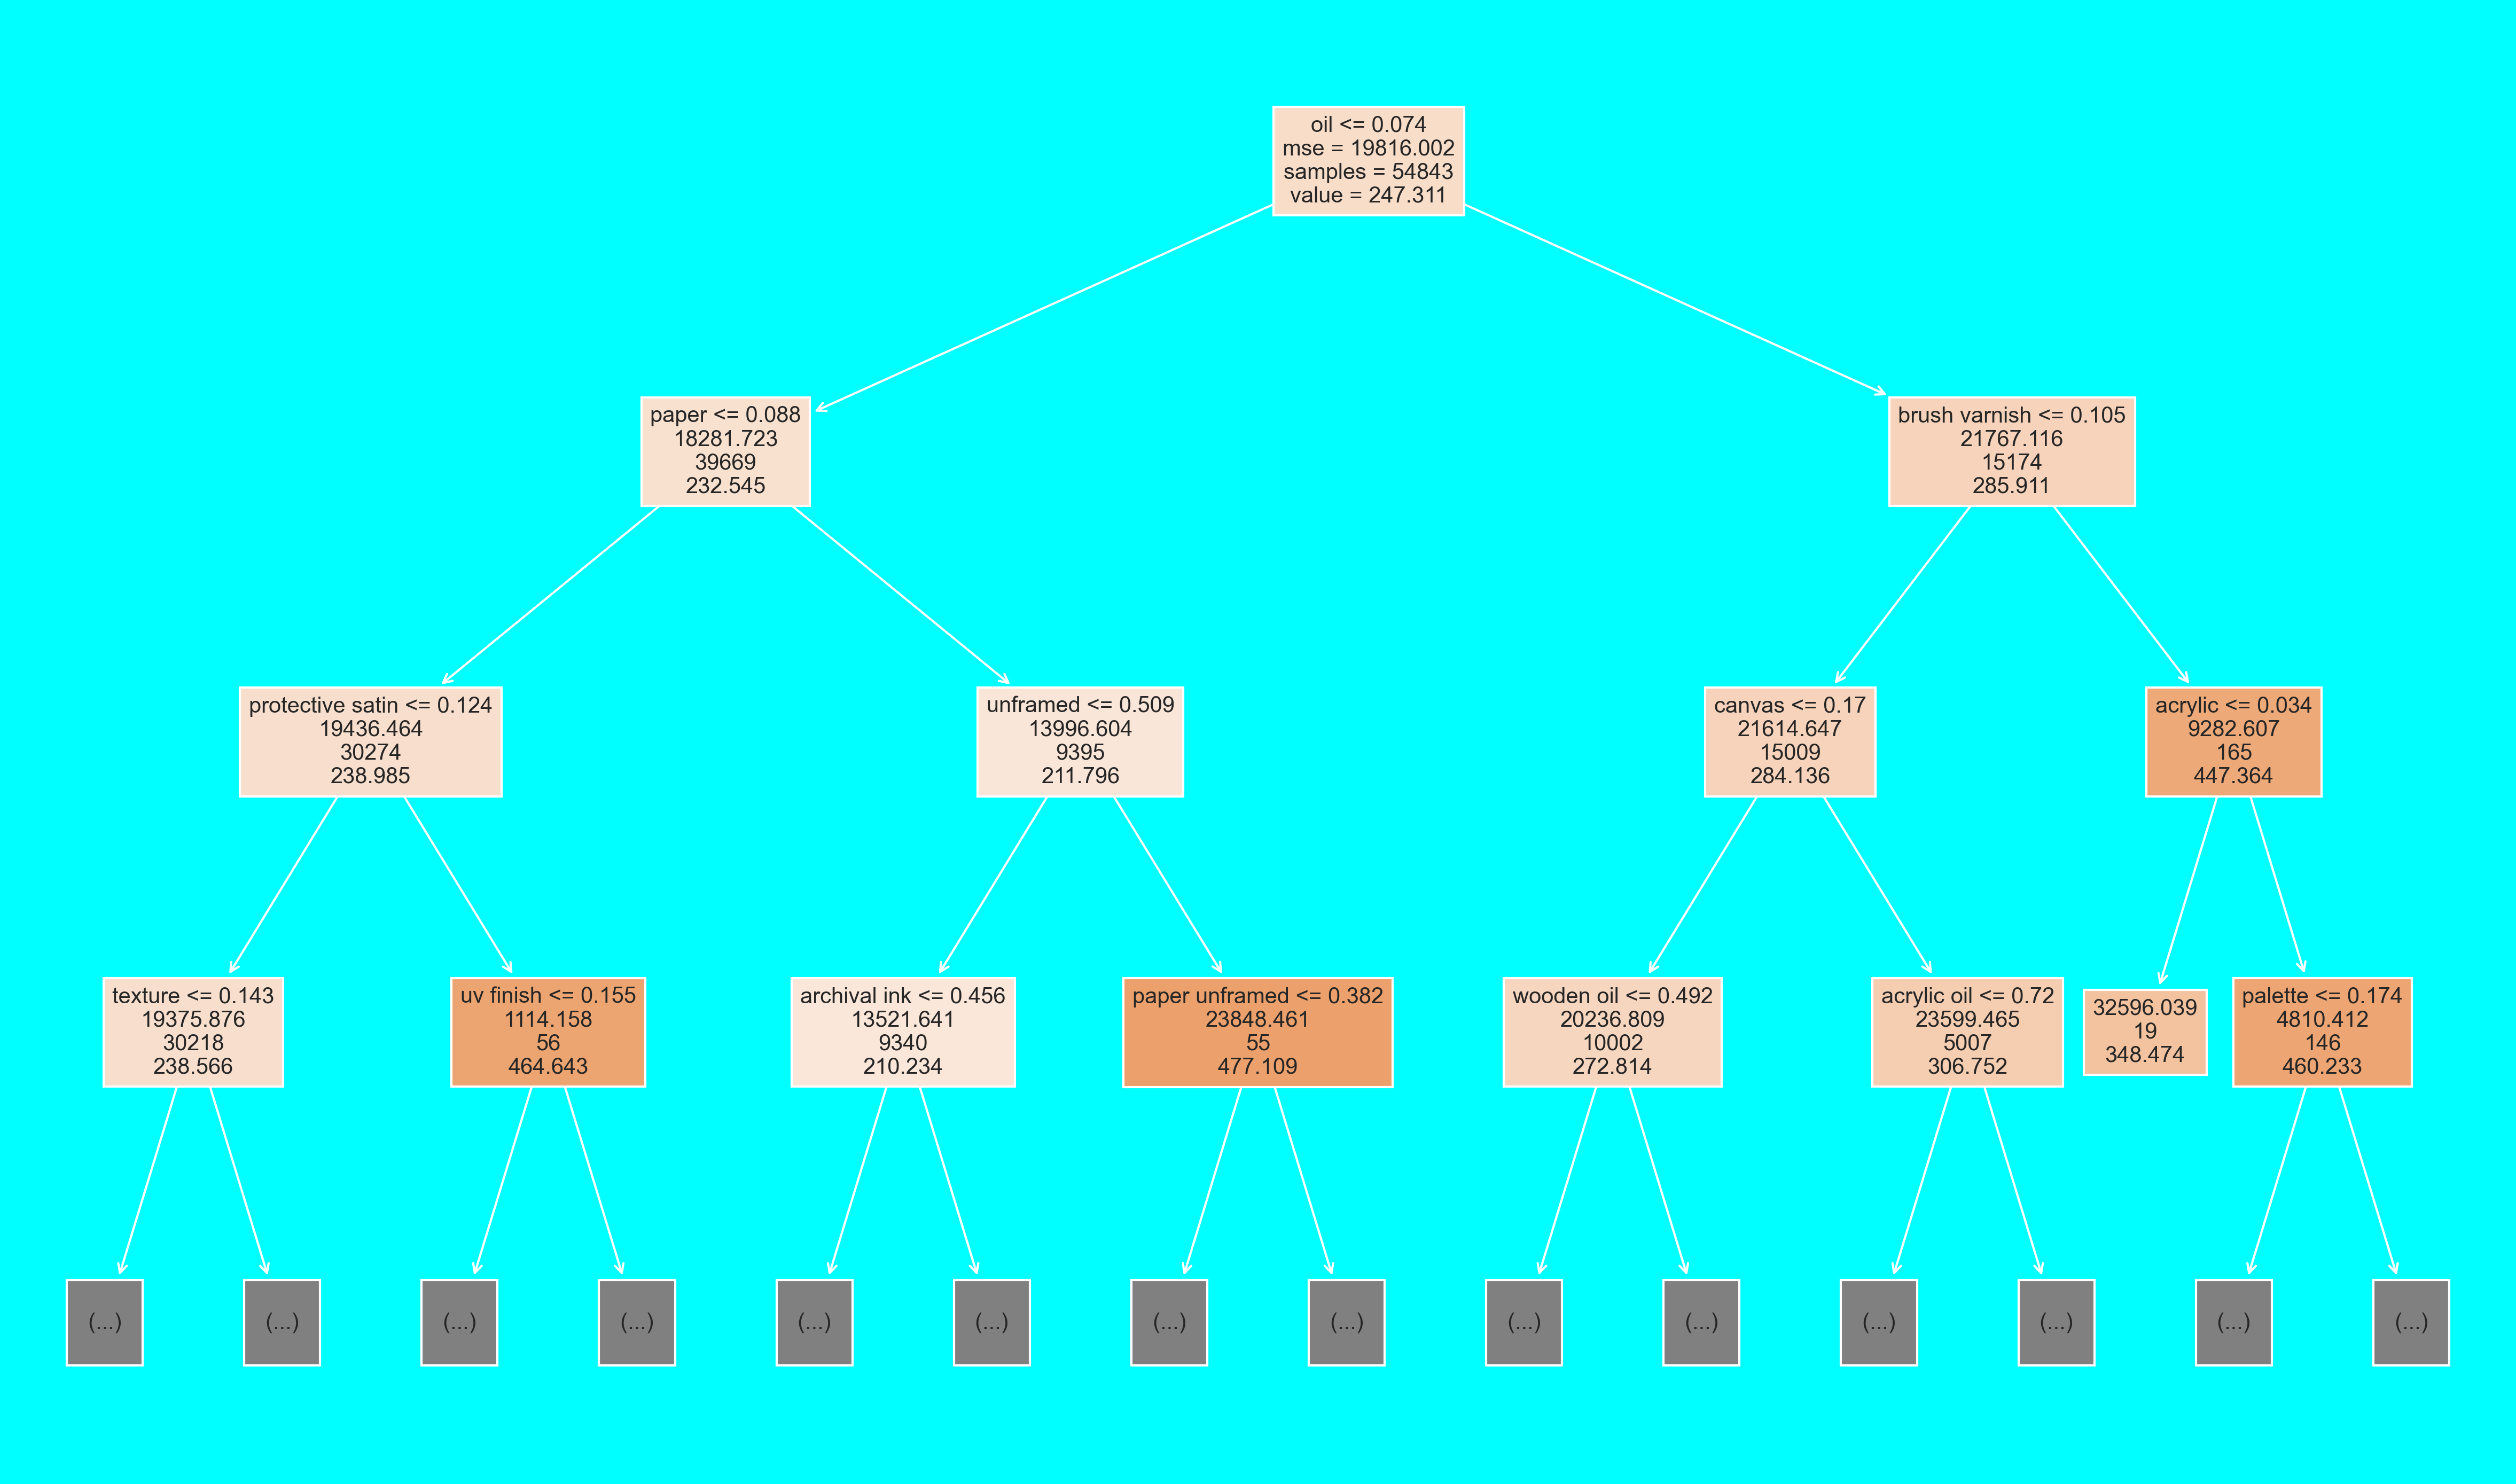

In [433]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(materials_dtree_w_tfidf_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_materials_dtree_w_tfidf)
fig.savefig('./Git_exclude/Figures/decision_tree_materials_tfidf_noSVD.png')

In [434]:
#Let's try with dimensionality reduction before computing the regressor
from sklearn.decomposition import TruncatedSVD

materials_dtree_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree', DecisionTreeRegressor(max_depth=10,min_samples_leaf=10))
])

In [435]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,12,2), 'SVD__n_components': range(2,102,4)} 
#materials_dtree_w_tfidf_SVD_CVmodel = RandomizedSearchCV(materials_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
materials_dtree_w_tfidf_SVD_CVmodel = GridSearchCV(materials_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [436]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

materials_tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/materials_tags_SVD_dtree_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(materials_tags_SVD_dtree_CVmodel_filename, 'rb') as f:
        materials_dtree_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded pickle file with decision tree model for materials tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_dtree_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(materials_tags_SVD_dtree_CVmodel_filename, 'wb') as f:
        dump(materials_dtree_w_tfidf_SVD_CVmodel, f, recurse=True) 
        print('Saved pickle file with decision tree model for materials tags vectorized with tf-idf and reduced with SVD.')

Loaded pickle file with decision tree model for materials tags vectorized with tf-idf and reduced with SVD.


In [437]:
materials_dtree_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 78, 'dtree__max_depth': 6}

In [438]:
#Predict prices on training set:
prices_train_pred = materials_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [439]:
#And return the R2 score as follows:
materials_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.07597213469167374

In [440]:
#Predict prices on test set:
prices_test_pred = materials_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [441]:
#And return the R2 score as follows:
materials_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.06869941413421987

In [442]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using vectorized materials tags with Tf-Idf followed by SVD')

Decision tree model using vectorized materials tags with Tf-Idf followed by SVD:
Training R^2: 0.07597213469167374
Testing R^2: 0.06869941413421987
Training RMSE: USD 135.31643826603835
Testing RMSE: USD 137.17551646913802
Training MAE: USD 108.38768231497298
Testing MAE: USD 109.81853878471148


In [443]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [444]:
materials_feature_names = materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

In [445]:
# Get Singular values and Components 
Sigma = materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([74.62903647, 56.75411002, 56.12456568, 47.3584639 , 38.33607099,
       37.25485855, 34.38751278, 33.2679579 , 31.16833094, 29.05622361,
       27.41667218, 25.71524015, 25.139627  , 22.74444093, 21.96227319,
       21.86542127, 21.20313839, 20.45367488, 20.23193349, 20.031085  ,
       19.70925691, 19.55281109, 19.16115173, 18.76393906, 18.07800034,
       17.97065925, 17.91053426, 17.43823381, 17.23588778, 17.07053378,
       16.80635833, 16.77491471, 15.9668319 , 15.7456054 , 15.5778682 ,
       15.25882711, 14.87070418, 14.70659253, 14.54333399, 14.40136092,
       14.24792271, 13.9364649 , 13.54383849, 13.07668849, 12.57254581,
       12.47529516, 12.2084682 , 12.15635014, 11.99205951, 11.95965061,
       11.85975347, 11.70051158, 11.68959008, 11.50048938, 11.41329392,
       11.32621425, 11.31020084, 11.25937552, 11.00948336, 10.93671345,
       10.76216205, 10.69434889, 10.63651129, 10.55435097, 10.54623646,
       10.51650811, 10.36031073, 10.33699246, 10.1086574 , 10.07

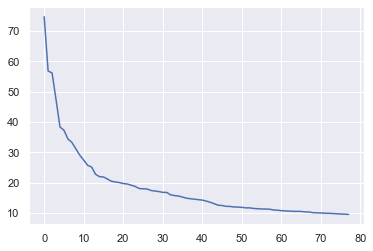

In [446]:
plt.plot(Sigma)

In [447]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

Topic 0:  ['stretched canvas(0.5)', 'canvas(0.49)', 'stretched(0.48)']
Topic 1:  ['oil(0.58)', 'oil canvas(0.49)', 'stretched canvas(-0.45)']
Topic 2:  ['paper(0.65)', 'watercolor(0.55)', 'paper watercolor(0.47)']
Topic 3:  ['acrylic(0.68)', 'acrylic canvas(0.52)', 'stretched canvas(-0.31)']
Topic 4:  ['canvas board(0.58)', 'board(0.56)', 'wood(-0.24)']
Topic 5:  ['wood(0.49)', 'hardboard wood(0.48)', 'hardboard(0.47)']
Topic 6:  ['blue(0.52)', 'blue canvas(0.47)', 'canvas stretched(0.31)']
Topic 7:  ['paper(0.64)', 'watercolor(-0.61)', 'acrylic canvas(-0.26)']
Topic 8:  ['acrylic stretched(0.55)', 'acrylic canvas(-0.52)', 'acrylic(0.36)']
Topic 9:  ['framed(0.5)', 'framed canvas(0.38)', 'oil framed(0.38)']
Topic 10:  ['stretched oil(0.6)', 'oil(-0.42)', 'framed(0.3)']
Topic 11:  ['fine(0.57)', 'canvas fine(0.34)', 'black(0.25)']
Topic 12:  ['fine(0.55)', 'canvas fine(0.39)', 'black(-0.32)']
Topic 13:  ['acrylic stretched(-0.66)', 'acrylic paper(0.37)', 'acrylic(0.32)']
Topic 14:  ['ha

In [448]:
#Which are the most predictive 'topics' in the decision tree?

In [449]:
#What are the style words or word combos that are used most by the tree regressor?
materials_dtree_w_tfidf_SVD_features_imp_df = pd.DataFrame(materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
materials_dtree_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_materials_topics)
materials_dtree_w_tfidf_SVD_features_imp_df = materials_dtree_w_tfidf_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
materials_dtree_w_tfidf_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
2                   0.402871   
0                   0.056467   
10                  0.048773   
18                  0.036070   
72                  0.035704   
57                  0.035582   
76                  0.030811   
35                  0.026990   
44                  0.025226   
5                   0.024445   
19                  0.022881   
3                   0.022080   
8                   0.020268   
49                  0.017344   
56                  0.017306   
14                  0.017206   
43                  0.015658   
45                  0.015475   
4                   0.013645   
54                  0.013149   

                                                Topic  
2   [paper(0.65), watercolor(0.55), paper watercol...  
0   [stretched canvas(0.5), canvas(0.49), stretche...  
10      [stretched oil(0.6), oil(-0.42), framed(0.3)]  
18   [mixed(0.43), media(0.43), acrylic paper(-0.31)]  
72  [unframed(0.32), red canvas(0.22), painted han...  
57  [canvas water(0.42), frame oil(-0.29), waterco...  
76  [wooden(0.38), acrylic purple(0.33), purple ca...  
35  [texture(0.51), texture canvas(0.44), stretche...  
44  [brush(0.54), canvas brush(0.5), canvas varnis...  
5   [wood(0.49), hardboard wood(0.48), hardboard(0...  
19         [knife(0.38), green(-0.38), palette(0.37)]  
3   [acrylic(0.68), acrylic canvas(0.52), stretche...  
8   [acrylic stretched(0.55), acrylic canvas(-0.52...  
49  [hang(0.42), black canvas(-0.3), stretched bla...  
56  [wrapped(0.52), canvas water(-0.44), acrylic w...  
14  [hand(0.38), painted(0.33), canvas stretched(-...  
43  [acrylic oil(0.35), framed paper(0.29), oil fr...  
45  [stretched fine(-0.4), paper fine(0.38), water...  
4      [canvas board(0.58), board(0.56), wood(-0.24)]  
54  [wrapped(0.31), frame oil(0.25), canvas hand(-...

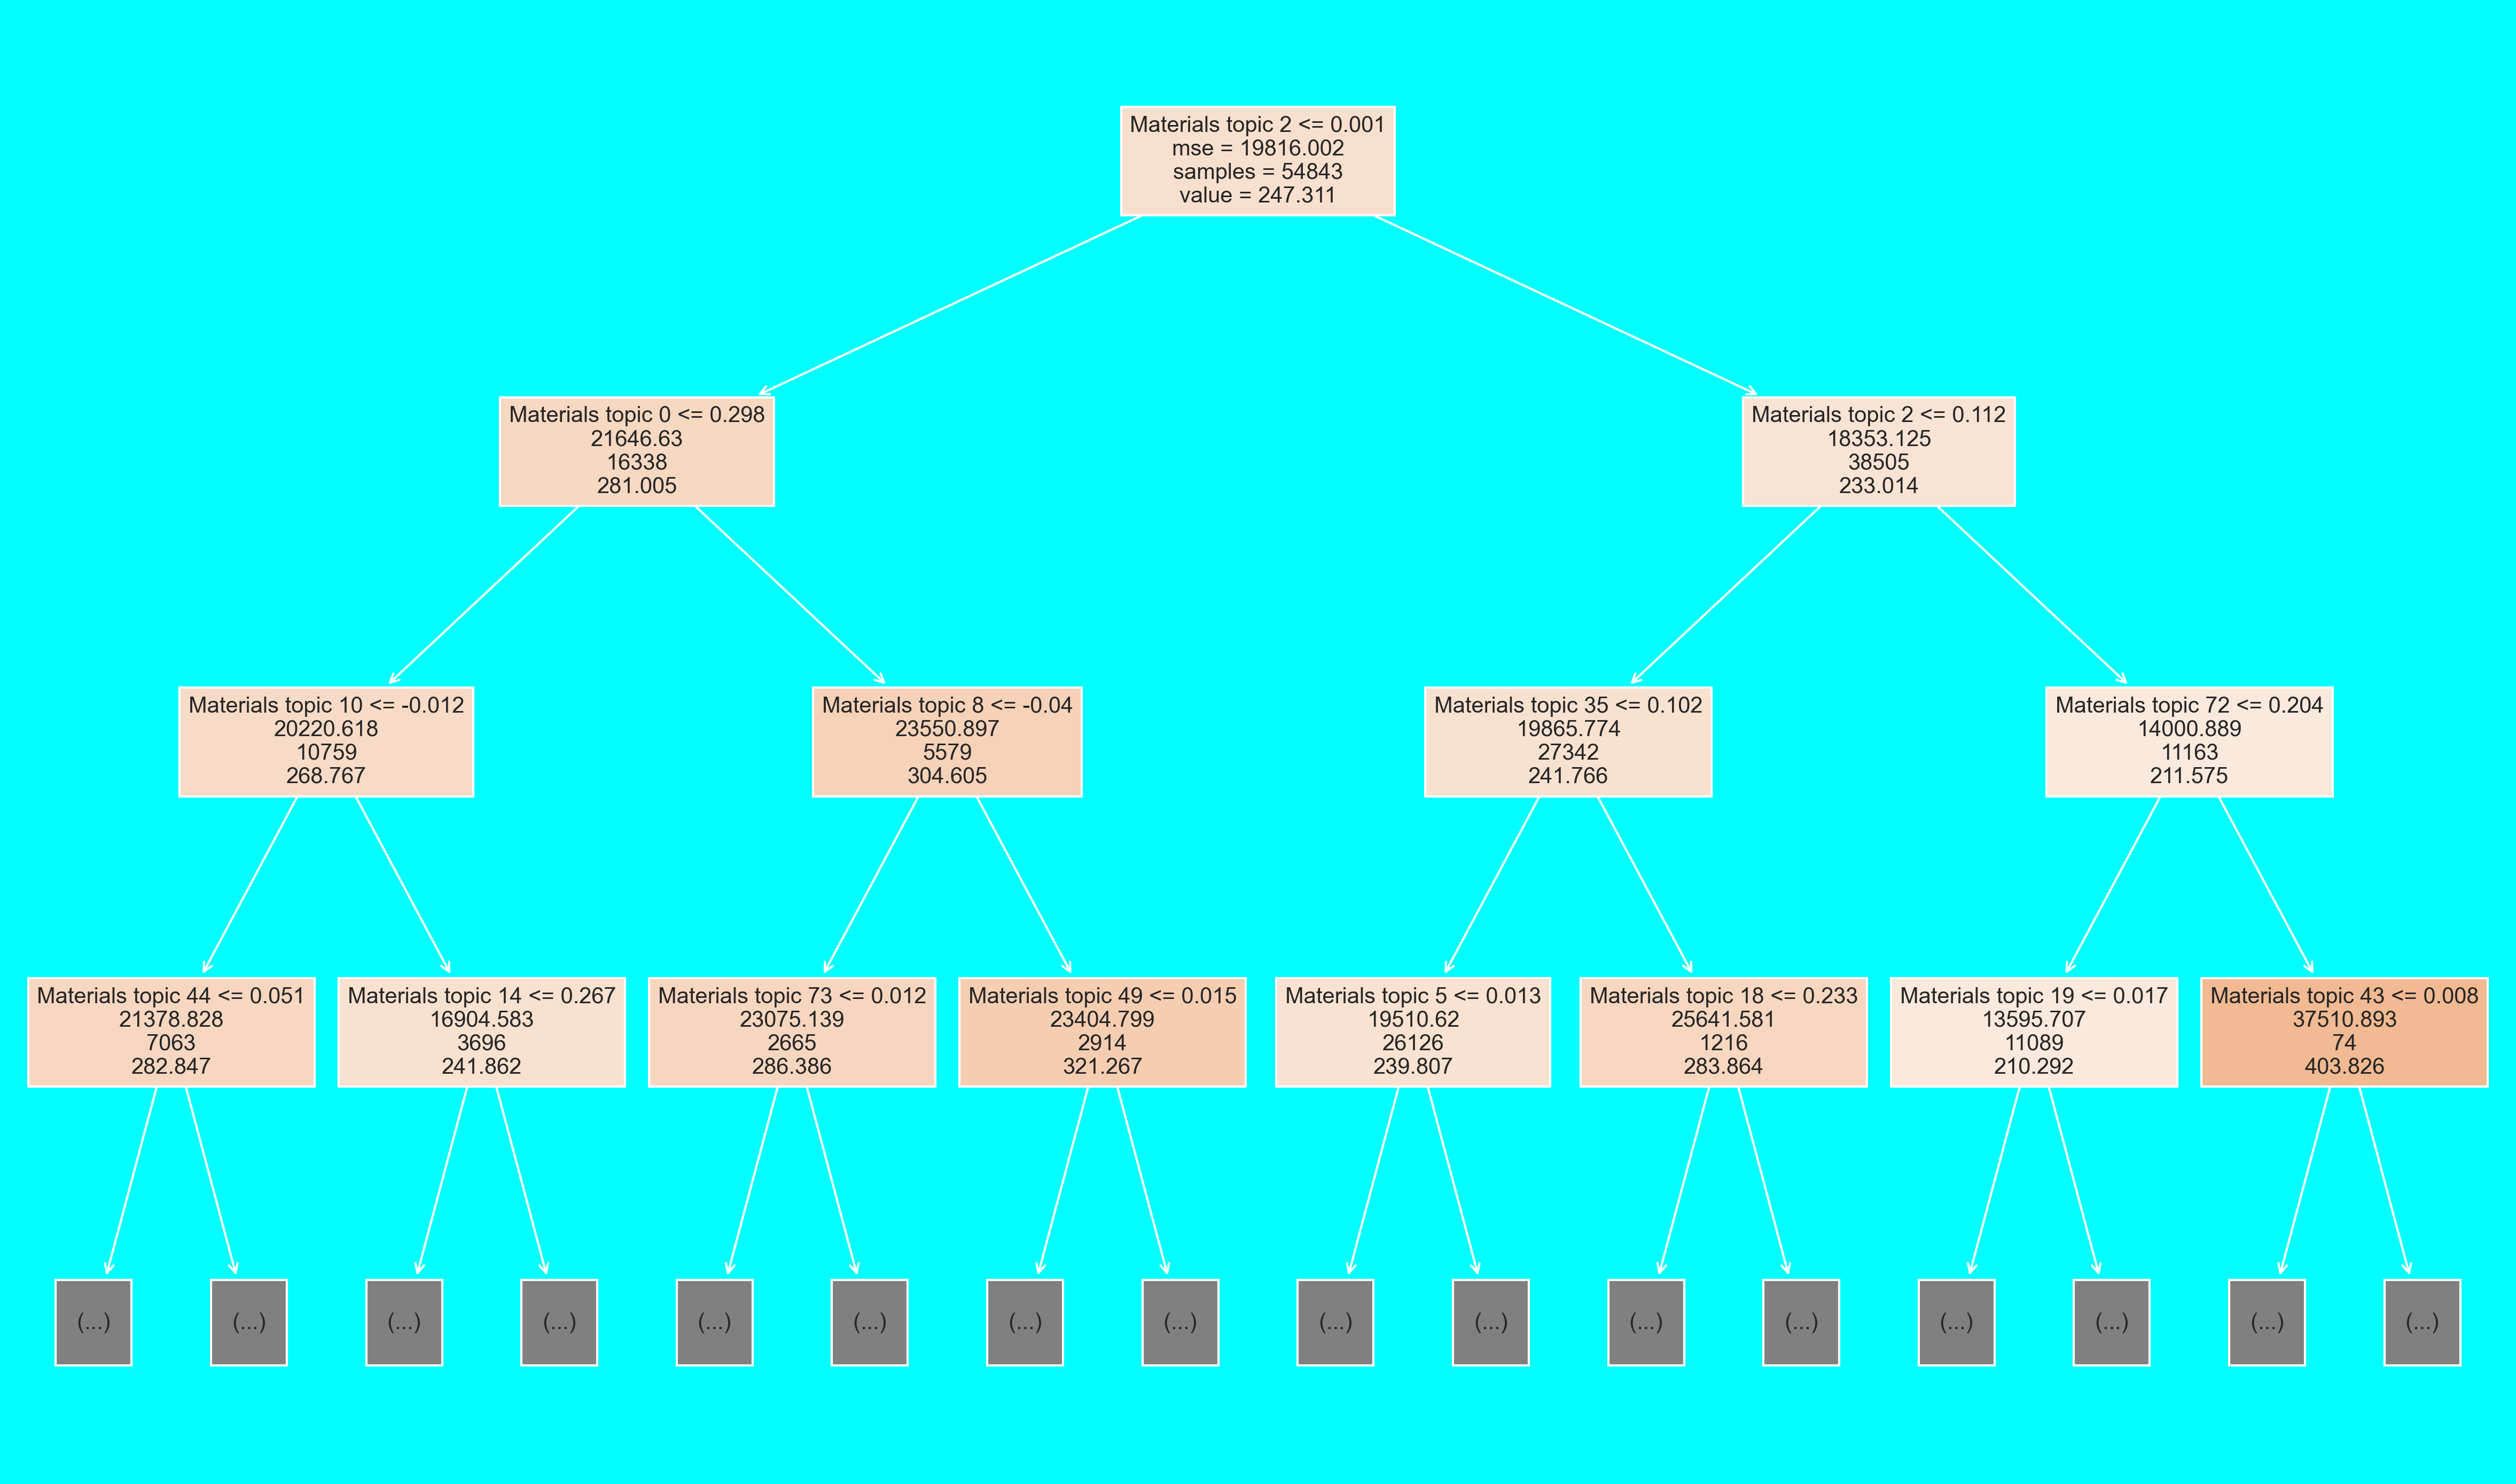

In [450]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_materials_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_materials_tags_after_tfidf_SVD.png')

#### Model 5e) Random Forest on Materials Tags (vectorized, but without Tf-Idf vectorization or SVD reduction)

In [451]:
from sklearn.ensemble import RandomForestRegressor

In [452]:
materials_rforest_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=materials_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [453]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

materials_rforest_pipe_filename = './Git_exclude/models/materials_rforest_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(materials_rforest_pipe_filename, 'rb') as f:
        materials_rforest_pipe = load(f)
        print('Loaded pickle file with random forest model for materials tags (without Tf-Idf).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_rforest_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_rforest_pipe_filename, 'wb') as f:
        dump(materials_rforest_pipe, f, recurse=True) 
        print('Saved pickle file with random forest model for materials tags (without Tf-Idf).')

Loaded pickle file with random forest model for materials tags (without Tf-Idf).


In [454]:
#Predict prices on training set:
prices_train_pred = materials_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_rforest_pipe.score(paintings_df_train,prices_train)

0.07207475722798196

In [455]:
#Predict prices on test set:
prices_test_pred = materials_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_rforest_pipe.score(paintings_df_test,prices_test)

0.07009513780490206

In [456]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using materials tags (without Tf-Idf)')


Random Forest model using materials tags (without Tf-Idf):
Training R^2: 0.07207475722798196
Testing R^2: 0.07009513780490206
Training RMSE: USD 135.6015077588345
Testing RMSE: USD 137.07268667058548
Training MAE: USD 109.50301882997766
Testing MAE: USD 110.69540217760601


In [457]:
feature_names_materials_rforest = materials_rforest_pipe['materials tags vectorization'].named_transformers_['materials tags vectorizer'][-1].get_feature_names()

In [458]:
feature_names_materials_rforest

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue',
 'board',
 'brush',
 'brushes',
 'canvas',
 'cardboard',
 'charcoal',
 'clear',
 'cold',
 'collage',
 'cotton',
 'epoxy',
 'fabric',
 'fine',
 'finish',
 'floetrol',
 'frame',
 'framed',
 'gel',
 'gesso',
 'glass',
 'glitter',
 'gloss',
 'gold',
 'golden',
 'gouache',
 'grade',
 'graphite',
 'green',
 'hand',
 'hang',
 'hanger',
 'hanging',
 'hardboard',
 'hardware',
 'heavy',
 'ink',
 'knife',
 'lb',
 'leaf',
 'linen',
 'liquitex',
 'love',
 'marker',
 'mat',
 'matte',
 'media',
 'metal',
 'metallic',
 'mixed',
 'newton',
 'oil',
 'oils',
 'painted',
 'palette',
 'panel',
 'paper',
 'paste',
 'pastel',
 'pen',
 'pencil',
 'pigment',
 'pigments',
 'premium',
 'press',
 'pressed',
 'print',
 'protective',
 'purple',
 'red',
 'resin',
 'satin',
 'spray',
 'stretched',
 'stretcher',
 'texture',
 'thick',
 'unframed',
 'uv',
 'varnish',
 'water',
 'watercolor',
 'watercolors',
 'whit

In [459]:
materials_rforest_features_imp_df = pd.DataFrame(materials_rforest_pipe['rforest'].feature_importances_,feature_names_materials_rforest,columns=['Rforest feature importance'])
materials_rforest_features_imp_df = materials_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
materials_rforest_features_imp_df

Rforest feature importance
oil                           0.236185
paper                         0.093380
watercolor                    0.057297
canvas                        0.056596
acrylic                       0.041394
...                                ...
aluminum                      0.000827
fabric                        0.000568
premium                       0.000415
140                           0.000390
liquitex                      0.000257

[100 rows x 1 columns]

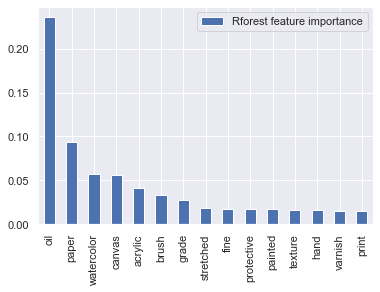

In [460]:
materials_rforest_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 5f) Random Forest on Materials Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [461]:
from sklearn.ensemble import RandomForestRegressor

In [462]:
from sklearn.decomposition import TruncatedSVD

materials_rforest_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [463]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

materials_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/materials_rforest_w_tfidf_SVD_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(materials_rforest_w_tfidf_SVD_pipe_filename, 'rb') as f:
        materials_rforest_w_tfidf_SVD_pipe = load(f)
        print('Loaded pickle file with random forest model for materials tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_rforest_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_rforest_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(materials_rforest_w_tfidf_SVD_pipe, f, recurse=True) 
        print('Saved pickle file with random forest model for materials tags (after Tf-Idf and SVD).')

Loaded pickle file with random forest model for materials tags (after Tf-Idf and SVD).


In [464]:
#Predict prices on training set:
prices_train_pred = materials_rforest_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_rforest_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.08432957823151432

In [465]:
#Predict prices on test set:
prices_test_pred = materials_rforest_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_rforest_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.07443156393662531

In [466]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using materials tags (after Tf-Idf and SVD reduction)')


Random Forest model using materials tags (after Tf-Idf and SVD reduction):
Training R^2: 0.08432957823151432
Testing R^2: 0.07443156393662531
Training RMSE: USD 134.70310814210885
Testing RMSE: USD 136.75270760706803
Training MAE: USD 108.58044228853747
Testing MAE: USD 110.30364165710814


In [467]:
materials_rforest_w_tfidf_SVD_pipe

Pipeline(steps=[('tags tfidf vectorization',
                 ColumnTransformer(transformers=[('materials tags tfidf',
                                                  Pipeline(steps=[('to single '
                                                                   'string',
                                                                   TagsEncoder()),
                                                                  ('to tfidf '
                                                                   'n-grams',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'materials_tags_new')])),
                ('SVD', TruncatedSVD(n_components=40)),
                ('rforest',
                 RandomForestRegressor(max_depth=7, max_features='sqrt',
                                       max_samples=0.8, n_jobs=2,
                                       random_state=1))])

In [468]:
#what are the main features used for decision?
materials_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_

array([0.06493641, 0.10193453, 0.14400777, 0.02863884, 0.03007684,
       0.03077091, 0.01328342, 0.03772719, 0.0136354 , 0.01726254,
       0.05308619, 0.02313888, 0.01819273, 0.01375458, 0.01589861,
       0.01684368, 0.02427131, 0.0127874 , 0.01957177, 0.01233659,
       0.00843366, 0.01415058, 0.01666951, 0.01663169, 0.01369146,
       0.01090081, 0.01324849, 0.00947401, 0.01121313, 0.00830319,
       0.0200067 , 0.0160958 , 0.01617578, 0.01062897, 0.01343669,
       0.03004896, 0.01776978, 0.01772337, 0.0158332 , 0.02740862])

In [469]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_rforest_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    #print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

In [470]:
#What are the style words or word combos that are used most by the random forest regressor?
materials_rforest_w_tfidf_SVD_features_imp_df = pd.DataFrame(materials_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
materials_rforest_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_materials_topics)
materials_rforest_w_tfidf_SVD_features_imp_df = materials_rforest_w_tfidf_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
materials_rforest_w_tfidf_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
2                     0.144008   
1                     0.101935   
0                     0.064936   
10                    0.053086   
7                     0.037727   
5                     0.030771   
4                     0.030077   
35                    0.030049   
3                     0.028639   
39                    0.027409   
16                    0.024271   
11                    0.023139   
30                    0.020007   
18                    0.019572   
12                    0.018193   
36                    0.017770   
37                    0.017723   
9                     0.017263   
15                    0.016844   
22                    0.016670   

                                                Topic  
2   [paper(0.65), watercolor(0.55), paper watercol...  
1   [oil(0.58), oil canvas(0.49), stretched canvas...  
0   [stretched canvas(0.5), canvas(0.49), stretche...  
10      [stretched oil(0.6), oil(-0.42), framed(0.3)]  
7   [paper(0.64), watercolor(-0.61), acrylic canva...  
5   [wood(0.49), hardboard wood(0.48), hardboard(0...  
4      [canvas board(0.58), board(0.56), wood(-0.24)]  
35  [texture(0.52), texture canvas(0.44), stretche...  
3   [acrylic(0.68), acrylic canvas(0.52), stretche...  
39  [varnish(0.47), acrylic oil(0.31), wood oil(0.3)]  
16     [hand(0.36), oil canvas(-0.34), painted(0.32)]  
11       [fine(0.57), canvas fine(0.34), black(0.25)]  
30       [purple(0.65), ink(-0.41), ink paper(-0.32)]  
18   [mixed(0.43), media(0.43), acrylic paper(-0.31)]  
12      [fine(0.55), canvas fine(0.39), black(-0.32)]  
36  [wood oil(0.46), canvas fine(0.31), acrylic oi...  
37  [canvas fine(0.46), panel(0.41), paper fine(-0...  
9   [framed(0.5), framed canvas(0.38), oil framed(...  
15         [oil canvas(-0.4), oil(0.31), black(0.31)]  
22          [frame(0.42), knife(0.28), palette(0.27)]

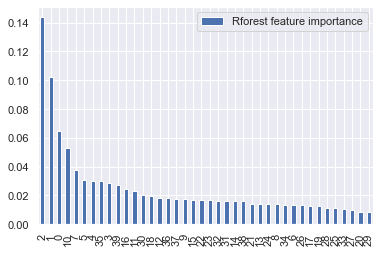

In [471]:
materials_rforest_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 5g) Gradient Boosted Trees on Materials Tags (vectorized, without Tf-Idf and SVD reduction)

In [472]:
from sklearn.ensemble import GradientBoostingRegressor

In [473]:
materials_gboost_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1,min_samples_leaf=10))
])

In [474]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

materials_gboost_pipe_filename = './Git_exclude/models/materials_gboost_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(materials_gboost_pipe_filename, 'rb') as f:
        materials_gboost_pipe = load(f)
        print('Loaded pickle file with gradient boosting model for materials tags (without Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_gboost_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_gboost_pipe_filename, 'wb') as f:
        dump(materials_gboost_pipe, f, recurse=True) 
        print('Saved pickle file with gradient boosting model for materials tags (without Tf-Idf and SVD).')

Loaded pickle file with gradient boosting model for materials tags (without Tf-Idf and SVD).


In [475]:
#Predict prices on training set:
prices_train_pred = materials_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_gboost_pipe.score(paintings_df_train,prices_train)

0.07633845671866346

In [476]:
#Predict prices on test set:
prices_test_pred = materials_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_gboost_pipe.score(paintings_df_test,prices_test)

0.07679394027591291

In [477]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using materials tags (without Tf-Idf and SVD reduction)')


Gradient Boosting model using materials tags (without Tf-Idf and SVD reduction):
Training R^2: 0.07633845671866346
Testing R^2: 0.07679394027591291
Training RMSE: USD 135.2896131519839
Testing RMSE: USD 136.57807559000145
Training MAE: USD 108.8541140582012
Testing MAE: USD 109.85568813008285


In [478]:
#what are the main features used for decision?
materials_gboost_pipe['gboost'].feature_importances_

array([0.00000000e+00, 1.54126634e-03, 3.02614236e-02, 3.29100935e-03,
       0.00000000e+00, 5.30303846e-03, 7.79069837e-03, 3.20621010e-03,
       1.37189085e-02, 6.95488595e-04, 8.73587824e-03, 4.12118415e-02,
       4.40831891e-03, 3.35454439e-02, 4.44921184e-03, 1.25293161e-03,
       1.38964352e-04, 4.95364687e-03, 1.24834014e-03, 2.04495386e-03,
       5.08727968e-03, 4.99426380e-04, 2.49748849e-02, 1.27912514e-03,
       2.32950797e-03, 8.28344777e-03, 8.01988874e-03, 1.20227648e-03,
       5.24445192e-03, 2.41096203e-03, 1.30401183e-03, 2.16429773e-03,
       2.53369464e-03, 7.97342982e-04, 3.26878844e-04, 5.59870729e-03,
       8.05064247e-04, 3.34584225e-03, 1.82362772e-02, 3.71376021e-03,
       4.98156555e-04, 7.68206841e-03, 9.37814690e-04, 4.99713518e-04,
       1.62413558e-03, 4.16368727e-03, 3.05968291e-03, 2.11474559e-03,
       1.08793145e-02, 8.30773666e-03, 4.82639957e-04, 5.94881353e-03,
       6.78480972e-04, 4.64748561e-04, 6.24876817e-04, 7.89716160e-03,
      

In [479]:
feature_names_materials_gboost = materials_gboost_pipe['materials tags vectorization'].named_transformers_['materials tags vectorizer'][-1].get_feature_names()

In [480]:
feature_names_materials_gboost

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue',
 'board',
 'brush',
 'brushes',
 'canvas',
 'cardboard',
 'charcoal',
 'clear',
 'cold',
 'collage',
 'cotton',
 'epoxy',
 'fabric',
 'fine',
 'finish',
 'floetrol',
 'frame',
 'framed',
 'gel',
 'gesso',
 'glass',
 'glitter',
 'gloss',
 'gold',
 'golden',
 'gouache',
 'grade',
 'graphite',
 'green',
 'hand',
 'hang',
 'hanger',
 'hanging',
 'hardboard',
 'hardware',
 'heavy',
 'ink',
 'knife',
 'lb',
 'leaf',
 'linen',
 'liquitex',
 'love',
 'marker',
 'mat',
 'matte',
 'media',
 'metal',
 'metallic',
 'mixed',
 'newton',
 'oil',
 'oils',
 'painted',
 'palette',
 'panel',
 'paper',
 'paste',
 'pastel',
 'pen',
 'pencil',
 'pigment',
 'pigments',
 'premium',
 'press',
 'pressed',
 'print',
 'protective',
 'purple',
 'red',
 'resin',
 'satin',
 'spray',
 'stretched',
 'stretcher',
 'texture',
 'thick',
 'unframed',
 'uv',
 'varnish',
 'water',
 'watercolor',
 'watercolors',
 'whit

In [481]:
materials_gboost_features_imp_df = pd.DataFrame(materials_gboost_pipe['gboost'].feature_importances_,feature_names_materials_gboost,columns=['Gboost feature importance'])
materials_gboost_features_imp_df = materials_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
materials_gboost_features_imp_df

Gboost feature importance
oil                        0.317509
paper                      0.055844
brush                      0.041212
canvas                     0.033545
acrylic                    0.030261
...                             ...
clear                      0.000139
premium                    0.000000
newton                     0.000000
aluminum                   0.000000
140                        0.000000

[100 rows x 1 columns]

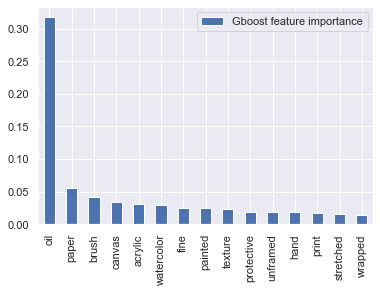

In [482]:
materials_gboost_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 5h) Gradient Boosted Trees on Materials Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [483]:
from sklearn.ensemble import GradientBoostingRegressor

In [484]:
from sklearn.decomposition import TruncatedSVD

materials_gboost_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1,min_samples_leaf=10))
])

In [485]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

materials_gboost_w_tfidf_SVD_pipe_filename = './Git_exclude/models/materials_gboost_w_tfidf_SVD_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(materials_gboost_w_tfidf_SVD_pipe_filename, 'rb') as f:
        materials_gboost_w_tfidf_SVD_pipe = load(f)
        print('Loaded pickle file with gradient boosting model for materials tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_gboost_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_gboost_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(materials_gboost_w_tfidf_SVD_pipe, f, recurse=True) 
        print('Saved pickle file with gradient boosting model for materials tags (after Tf-Idf and SVD).')

Loaded pickle file with gradient boosting model for materials tags (after Tf-Idf and SVD).


In [486]:
#Predict prices on training set:
prices_train_pred = materials_gboost_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_gboost_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.08414960249287429

In [487]:
#Predict prices on test set:
prices_test_pred = materials_gboost_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_gboost_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.07834468071766754

In [488]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using materials tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using materials tags (after Tf-Idf and SVD reduction):
Training R^2: 0.08414960249287429
Testing R^2: 0.07834468071766754
Training RMSE: USD 134.7163454923968
Testing RMSE: USD 136.46331997367588
Training MAE: USD 108.31800082585141
Testing MAE: USD 109.7702298683925


In [489]:
#what are the main features used for decision?
materials_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_

array([0.04833519, 0.01204278, 0.28844959, 0.01362117, 0.0369994 ,
       0.01332824, 0.01430802, 0.01057134, 0.01303274, 0.0150065 ,
       0.0478251 , 0.02650327, 0.01488741, 0.0093398 , 0.01613462,
       0.00895929, 0.02495684, 0.01097782, 0.02440577, 0.016838  ,
       0.00566766, 0.00811659, 0.01533327, 0.0125926 , 0.00658252,
       0.00985638, 0.01433727, 0.01876792, 0.01731187, 0.02467651,
       0.01327907, 0.0114688 , 0.02009624, 0.01337742, 0.01126683,
       0.04870021, 0.0216592 , 0.01687913, 0.01378085, 0.02972677])

In [490]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_gboost_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    #print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

In [491]:
#What are the materials words or word combos that are used most by the gradient boosted trees?
materials_gboost_w_tfidf_SVD_features_imp_df = pd.DataFrame(materials_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
materials_gboost_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_materials_topics)
materials_gboost_w_tfidf_SVD_features_imp_df = materials_gboost_w_tfidf_SVD_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
materials_gboost_w_tfidf_SVD_features_imp_df.iloc[:20]

Gboost feature importance  \
2                    0.288450   
35                   0.048700   
0                    0.048335   
10                   0.047825   
4                    0.036999   
39                   0.029727   
11                   0.026503   
16                   0.024957   
29                   0.024677   
18                   0.024406   
36                   0.021659   
32                   0.020096   
27                   0.018768   
28                   0.017312   
37                   0.016879   
19                   0.016838   
14                   0.016135   
22                   0.015333   
9                    0.015007   
12                   0.014887   

                                                Topic  
2   [paper(0.65), watercolor(0.55), paper watercol...  
35  [texture(0.52), texture canvas(0.44), stretche...  
0   [stretched canvas(0.5), canvas(0.49), stretche...  
10      [stretched oil(0.6), oil(-0.42), framed(0.3)]  
4      [canvas board(0.58), board(0.56), wood(-0.24)]  
39  [varnish(0.44), texture(-0.32), canvas varnish...  
11       [fine(0.57), canvas fine(0.34), black(0.25)]  
16     [hand(0.36), oil canvas(-0.34), painted(0.32)]  
29      [gold(0.67), acrylic gold(0.3), purple(0.27)]  
18   [mixed(0.43), media(0.43), acrylic paper(-0.31)]  
36  [canvas fine(0.42), wood oil(0.38), paper fine...  
32  [print(0.66), print canvas(0.36), framed paper...  
27  [hanging(0.72), canvas hanging(0.58), hanging ...  
28   [white(0.59), black(-0.39), acrylic white(0.35)]  
37  [panel(0.43), canvas fine(0.4), paper fine(-0....  
19         [knife(0.38), green(-0.38), palette(0.37)]  
14  [hand(0.38), painted(0.33), canvas stretched(-...  
22          [frame(0.42), knife(0.28), palette(0.27)]  
9   [framed(0.5), framed canvas(0.38), oil framed(...  
12      [fine(0.55), canvas fine(0.39), black(-0.32)]

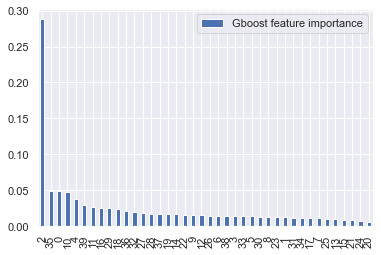

In [492]:
materials_gboost_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 6) Models using the other generic tags that were neither identified as 'style' nor as 'materials' tags

#### Because these 'generic' tags can contain all kinds of words (from a large vocabulary, and there can be many tags on any listing) I certainly need  traditional NLP techniques such as a TfIdfVectorizer (or CountVectorizer + TfIdfTransformer) using n-grams and dimensionality reduction

In [493]:
# # The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'tags' column with the
# #'TagsEncoder' already introduced earlier for some of the style tags models
# from sklearn.base import BaseEstimator, TransformerMixin
# class TagsEncoder(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
#         return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [494]:
all_paintings_df['tags_new'].iloc[0]

"['wall', 'life', 'table', 'outsider', 'chair', 'still', 'art']"

In [495]:
all_paintings_df['tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0                 wall life table outsider chair still art
1        outsider valentine art wall original heart day...
2        children outsider nursery colorful bugs art wa...
3        wall outsider markers creature original painti...
4        room decor cave nursery gifts him wall ocean b...
                               ...                        
68549        blossom county field flower petal pink spring
68550                              fluid painting wall art
68551    idea charleston housewarmings art artism gift ...
68552    grand sioux fighting und forks lover north art...
68553    round art wave sunset ocean seascape original ...
Name: tags_new, Length: 68554, dtype: object

In [496]:
#A TfIdfVectorizer (or CountVectorizer + TfIdfTransformer) should then follow, where I can even try to count n-grams of 2 words.
#But note that I also want to remove generic stopwords that won't contain any informative information

In [497]:
from sklearn.feature_extraction.text import CountVectorizer

#exclude words that I know are not specific to materials
tags_stopwords=['art','artwork','painting','paintings','paint','paintin','paints','painter','painted','illustration','picture','drawing','color','colors','colored','colorful',\
                'and','on','one','of','for','to','in','the','a','an','at','with','by','fi','fe','no','de','up','over','from','big','large','small',\
                'medium','high','mid','low','extra','great','pretty','arts','fine','los','san','etsy',\
                'artist','professional','original','quality','custom','ready','artists','artism','handmade','gallery','present','gift','gifts','free','sale',\
                'long','new','old','affordable','made','unique','home','wall','decor','unique','room','style',\
                'interior', 'design','inch']

In [498]:
#I am going to keep only the (at most) 1000 most common words or bigrams, and require each word/bigram to occur in at least 100 listings
tags_tokenizer = CountVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000)

In [499]:
tokenized_tags = tags_tokenizer.fit_transform(paintings_df_train['tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist)))

In [500]:
tokenized_tags

<54843x668 sparse matrix of type '<class 'numpy.int64'>'
	with 225285 stored elements in Compressed Sparse Row format>

In [501]:
tags_list = tags_tokenizer.get_feature_names()

In [502]:
#check the count of words:
count_list = np.asarray(tokenized_tags.sum(axis=0))

In [503]:
token_counts = dict(zip(tags_list,count_list[0]))

In [504]:
token_counts_sorted = dict(sorted(token_counts.items(), key=lambda item: item[1],reverse=True))

In [505]:
token_counts_sorted

{'nature': 3514,
 'flowers': 3285,
 'ocean': 3256,
 'flower': 2572,
 'pink': 2570,
 'trees': 2299,
 'life': 2230,
 'signed': 2150,
 'woman': 2073,
 'house': 1998,
 'pour': 1787,
 'tree': 1720,
 'still': 1719,
 'orange': 1699,
 'seascape': 1674,
 'fluid': 1663,
 'sunset': 1634,
 'pet': 1588,
 'living': 1565,
 'kind': 1531,
 'animal': 1524,
 'office': 1517,
 'bright': 1425,
 'sky': 1399,
 'dog': 1385,
 'mountain': 1384,
 'rectangle': 1283,
 'sea': 1281,
 'air': 1263,
 'textured': 1232,
 'forest': 1220,
 'plein': 1197,
 'day': 1188,
 'mountains': 1175,
 'antique': 1155,
 'square': 1103,
 'girl': 1071,
 'scene': 1060,
 'decoration': 1054,
 'lake': 1037,
 'christmas': 1006,
 'female': 979,
 'cat': 978,
 'housewarming': 959,
 'geometric': 945,
 'bird': 942,
 'fall': 909,
 'winter': 909,
 'river': 905,
 'farm': 899,
 'beautiful': 887,
 'her': 884,
 'california': 882,
 'garden': 846,
 'bedroom': 835,
 'brown': 833,
 'gray': 830,
 'vibrant': 825,
 'summer': 809,
 'birthday': 807,
 'dark': 807,


In [506]:
#In practice, in the pipeline I am actually going to use those options within a full TfidfVectorizer that also does Tf-Idf transformation

from sklearn.feature_extraction.text import TfidfVectorizer

pipe_tags_encoding_with_stopwords = Pipeline([
    ('to single string',TagsEncoder()),
    ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
])

In [507]:
#now I can run the 'tags_new' column through this Encoder-Vectorizer sequence of steps
tags_tranform = ColumnTransformer([
    ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
], remainder='drop')

In [508]:
#I first fit_transform the training data by itself to extract the feature names to later
#retrieve them for interpreting the results
tags_tranform.fit_transform(paintings_df_train)

<54843x668 sparse matrix of type '<class 'numpy.float64'>'
	with 225285 stored elements in Compressed Sparse Row format>

In [509]:
tags_tranform.named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[:20]

['10',
 '11',
 '11x14',
 '12',
 '14',
 '140lb',
 '16',
 '16x20',
 '18',
 '18x24',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '20',
 '20th',
 '24',
 '30',
 '3d',
 '3d prints']

In [510]:
#the inverse frequencies can be extracted as follows:
tags_tranform.named_transformers_['tags tfidf']['to tfidf n-grams'].idf_[:20]

array([6.92181548, 6.85600227, 6.56038994, 6.48290244, 6.92181548,
       7.12475633, 6.37885858, 5.97207682, 7.20271787, 6.77058451,
       7.10822703, 6.60398037, 6.83084371, 7.02944615, 6.28462696,
       6.665224  , 6.45266256, 7.29712755, 5.73430396, 6.62398104])

### 6a) Ridge regression of generic tags only, after Tf-Idf vectorization using up to bigrams, and dimensionality reduction

In [511]:
#I put the previous NLP pre-processing in a pipeline with Ridge Regression

In [512]:
#Let's first try without dimensionality reduction, just to get a sense of which individual words are weighted most

from sklearn.linear_model import Ridge

tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [513]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
tags_ridge_w_tfidf_CVmodel = GridSearchCV(tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [514]:
#Train the model
tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(max_df=0.8,
                                                                                                          max_features=1000,
                                                                                                          min_df=100,
                                                                                                          ngram_range=(1,
                                                                                                                       2),
                                                                                                          stop_words=['art',
                                                                                                                      'artwork',
                                                                                                                      'painting',
                                                                                                                      'paintings',
                                                                                                                      'paint',
                                                                                                                      'paintin',
                                                                                                                      'paints',
                                                                                                                      'painter',
                                                                                                                      'painted',
                                                                                                                      'illustration',
                                                                                                                      'picture',
                                                                                                                      'drawing',
                                                                                                                      'color',
                                                                                                                      'colors',
                                                                                                                      'colored',
                                                                                                                      'colorful',
                                                                                                                      'and',
                                                                                                                      'on',
                                                                                                                      'one',
         

In [515]:
tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 10.0}

In [516]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_tags_ridge_tfidf = tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_ridge_reg_coeff_df = pd.DataFrame(tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_tags_ridge_tfidf,columns=['Regression coefficients'])
tags_ridge_reg_coeff_df = tags_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_reg_coeff_df

Regression coefficients
oversized                  188.598392
unstretched                186.208876
signed plein               164.904901
30                         156.870761
jackson                    134.340401
...                               ...
11x14                     -103.899916
pour                      -105.866851
10                        -118.613835
8x10                      -130.094579
mini                      -131.525255

[668 rows x 1 columns]

In [517]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [518]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.1083926311669341

In [519]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [520]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.092190075691166

In [521]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using generic tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using generic tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.1083926311669341
Testing R^2: 0.092190075691166
Training RMSE: USD 132.92138212734656
Testing RMSE: USD 135.43444395327467
Training MAE: USD 105.8095693053915
Testing MAE: USD 107.97859726903812


In [522]:
#Now let's add the dimensionality reduction step - which is needed to keep the number of features reasonable

In [523]:
from sklearn.decomposition import TruncatedSVD

tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [524]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,16,4), 'SVD__n_components': range(2,142,4)} 
#tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [525]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/tags_SVD_ridge_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded pickle file with ridge regression model for generic tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(tags_ridge_w_tfidf_SVD_CVmodel, f, recurse=True) 
        print('Saved pickle file with ridge regression model for generic tags vectorized with tf-idf and reduced with SVD.')

Loaded pickle file with ridge regression model for generic tags vectorized with tf-idf and reduced with SVD.


In [526]:
tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 110, 'ridge__alpha': 6.0}

In [527]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [528]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.053995291087935327

In [529]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [530]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.05610546050732845

In [531]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized (generic) tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized (generic) tags with Tf-Idf followed by SVD:
Training R^2: 0.053995291087935327
Testing R^2: 0.05610546050732845
Training RMSE: USD 136.91614825223957
Testing RMSE: USD 138.0999122910954
Training MAE: USD 110.0863801599182
Testing MAE: USD 111.05482964745717


In [532]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [533]:
tags_feature_names = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [534]:
# Get Singular values and Components 
Sigma = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([29.0327357 , 25.17093475, 24.48600709, 23.38725719, 22.98437771,
       22.39197106, 21.69932345, 20.79215531, 20.58278762, 19.90473083,
       19.21511025, 18.8955947 , 18.72783944, 18.65892836, 18.24039132,
       18.08170109, 17.85534527, 17.81034957, 17.36502207, 17.1874974 ,
       17.01302227, 16.82744626, 16.73927407, 16.60392542, 16.4301512 ,
       16.08163673, 16.02344033, 15.94590538, 15.82512178, 15.71219622,
       15.3664614 , 15.21394502, 15.09334214, 14.98366623, 14.81443204,
       14.66548738, 14.56914786, 14.54288929, 14.32546268, 14.30584174,
       14.20301768, 14.15564655, 14.08500693, 14.01006497, 13.95382666,
       13.87265764, 13.84207748, 13.74507038, 13.63958644, 13.56955461,
       13.55131587, 13.45414157, 13.41199445, 13.31924299, 13.26228715,
       13.19646645, 13.192297  , 13.15013581, 13.08293638, 13.03614279,
       13.01664556, 12.92031823, 12.87425851, 12.86290287, 12.81215581,
       12.73095089, 12.62934637, 12.56223492, 12.51071137, 12.49

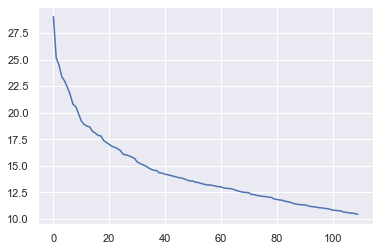

In [535]:
plt.plot(Sigma)

In [536]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

Topic 0:  ['flowers(0.37)', 'nature(0.28)', 'flower(0.27)']
Topic 1:  ['pour(0.43)', 'fluid(0.37)', 'ocean(0.36)']
Topic 2:  ['pour(0.5)', 'fluid(0.44)', 'ocean(-0.28)']
Topic 3:  ['pet(0.53)', 'dog(0.45)', 'animal(0.31)']
Topic 4:  ['ocean(0.46)', 'nature(-0.34)', 'trees(-0.28)']
Topic 5:  ['life(0.42)', 'pink(-0.4)', 'still(0.39)']
Topic 6:  ['woman(0.66)', 'signed(0.27)', 'nature(-0.24)']
Topic 7:  ['signed(0.51)', 'flowers(0.32)', 'life(-0.26)']
Topic 8:  ['pink(0.64)', 'woman(-0.41)', 'signed(0.28)']
Topic 9:  ['office(0.43)', 'living(0.39)', 'pink(-0.32)']
Topic 10:  ['nature(0.56)', 'flowers(-0.35)', 'trees(-0.33)']
Topic 11:  ['flower(0.58)', 'flowers(-0.49)', 'antique(0.44)']
Topic 12:  ['textured(0.5)', 'orange(0.38)', 'house(-0.31)']
Topic 13:  ['antique(-0.55)', 'air(0.4)', 'plein(0.38)']
Topic 14:  ['kind(0.79)', 'textured(-0.35)', 'flower(0.22)']
Topic 15:  ['textured(0.63)', 'orange(-0.6)', 'bright(-0.26)']
Topic 16:  ['house(-0.54)', 'living(0.44)', 'office(0.34)']
Topi

In [537]:
#Which are the largest regression coefficients in the regression model?
feature_names_tags_ridge_tfidf = tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_ridge_SVD_reg_coeff_df = pd.DataFrame(tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
tags_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_tags_topics)
tags_ridge_SVD_reg_coeff_df = tags_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients                                              Topic
16               116.005506         [house(-0.54), living(0.44), office(0.34)]
38               106.768561          [city(0.47), cityscape(0.4), dark(-0.23)]
6                 86.940660         [woman(0.66), signed(0.27), nature(-0.24)]
58                73.858652           [minimal(0.44), bold(0.41), river(0.29)]
5                 69.702064              [life(0.42), pink(-0.4), still(0.39)]
25                69.432030     [trees(0.44), seascape(0.41), mountain(-0.37)]
90                67.018420  [collectibles(0.55), indian(0.3), handpainted(...
67                66.352351  [surrealism(0.54), psychedelic(-0.36), teal(-0...
60                60.663494     [bold(0.39), california(0.38), tropical(-0.3)]
50                57.641189       [forest(0.54), beautiful(0.46), river(0.37)]

In [538]:
tags_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients                                              Topic
74               -50.568977              [fun(0.57), cat(0.33), outsider(0.2)]
88               -54.151334        [16x20(0.47), figurative(-0.41), grey(0.4)]
70               -54.605858            [scene(0.49), horse(-0.38), teal(0.24)]
85               -57.295229    [rectangular(0.35), spring(0.29), poster(0.27)]
63               -63.071191         [bold(0.53), minimal(-0.35), kitchen(0.2)]
14               -66.316598        [kind(0.79), textured(-0.35), flower(0.22)]
1                -71.364065             [pour(0.43), fluid(0.37), ocean(0.36)]
79               -85.659205  [housewarming(0.39), botanical(0.25), outsider...
3               -106.291097               [pet(0.53), dog(0.45), animal(0.31)]
2               -119.849477             [pour(0.5), fluid(0.44), ocean(-0.28)]

### 6b) Decision tree of (generic) tags only, after Tf-Idf vectorization using up to bigrams, and dimensionality reduction

In [539]:
#First, let's try without dimensionality reduction as a baseline
from sklearn.pipeline import Pipeline

tags_dtree_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15,min_samples_leaf=10)),
])

In [540]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} #np.linspace(0,10,1)} 
tags_dtree_w_tfidf_CVmodel = GridSearchCV(tags_dtree_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [541]:
tags_dtree_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:  5.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(max_df=0.8,
                                                                                                          max_features=1000,
                                                                                                          min_df=100,
                                                                                                          ngram_range=(1,
                                                                                                                       2),
                                                                                                          stop_words=['art',
                                                                                                                      'artwork',
                                                                                                                      'painting',
                                                                                                                      'paintings',
                                                                                                                      'paint',
                                                                                                                      'paintin',
                                                                                                                      'paints',
                                                                                                                      'painter',
                                                                                                                      'painted',
                                                                                                                      'illustration',
                                                                                                                      'picture',
                                                                                                                      'drawing',
                                                                                                                      'color',
                                                                                                                      'colors',
                                                                                                                      'colored',
                                                                                                                      'colorful',
                                                                                                                      'and',
                                                                                                                      'on',
                                                                                                                      'one',
         

In [542]:
tags_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']

50

In [543]:
#Predict prices on training set:
prices_train_pred = tags_dtree_w_tfidf_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
tags_dtree_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.15158315071854778

In [544]:
#Predict prices on test set:
prices_test_pred = tags_dtree_w_tfidf_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
tags_dtree_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.0825921294471591

In [545]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only generic tags, after Tf-Idf')


Decision Tree model using only generic tags, after Tf-Idf:
Training R^2: 0.15158315071854778
Testing R^2: 0.0825921294471591
Training RMSE: USD 129.6619851165152
Testing RMSE: USD 136.14851123664494
Training MAE: USD 100.80674738116458
Testing MAE: USD 106.47087156309745


In [546]:
#What are the tags words or word combos that are used most by the tree regressor?
feature_names_tags_dtree_w_tfidf = tags_dtree_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_dtree_w_tfidf_features_imp_df = pd.DataFrame(tags_dtree_w_tfidf_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_tags_dtree_w_tfidf,columns=['Dtree feature importance'])
tags_dtree_w_tfidf_features_imp_df = tags_dtree_w_tfidf_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
tags_dtree_w_tfidf_features_imp_df.iloc[:20]

Dtree feature importance
signed                       0.070176
rectangle                    0.065619
pour                         0.059629
oversized                    0.037135
pet                          0.029333
handpainted                  0.029214
unstretched                  0.025219
living                       0.023469
seascape                     0.021127
fauvism                      0.020547
fluid                        0.019585
1980s                        0.014566
jackson                      0.014310
antique                      0.013781
business                     0.013755
figurative                   0.012087
anniversary                  0.011784
office                       0.011625
listed                       0.010193
emerging                     0.010113

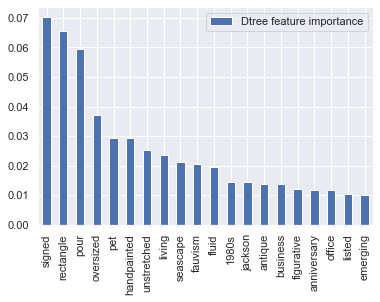

In [547]:
tags_dtree_w_tfidf_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

In [548]:
#Now let's add dimensionality reduction before computing the regressor
from sklearn.decomposition import TruncatedSVD

tags_dtree_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree', DecisionTreeRegressor(max_depth=10,min_samples_leaf=10))
])

In [549]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,12,2), 'SVD__n_components': range(2,82,4)} 
#tags_dtree_w_tfidf_SVD_CVmodel = RandomizedSearchCV(tags_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
tags_dtree_w_tfidf_SVD_CVmodel = GridSearchCV(tags_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [550]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/tags_SVD_dtree_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(tags_SVD_dtree_CVmodel_filename, 'rb') as f:
        tags_dtree_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded pickle file with decision tree model for generic tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_dtree_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(tags_SVD_dtree_CVmodel_filename, 'wb') as f:
        dump(tags_dtree_w_tfidf_SVD_CVmodel, f, recurse=True) 
        print('Saved pickle file with decision tree model for generic tags vectorized with tf-idf and reduced with SVD.')

Loaded pickle file with decision tree model for generic tags vectorized with tf-idf and reduced with SVD.


In [551]:
tags_dtree_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 30, 'dtree__max_depth': 8}

In [552]:
#Predict prices on training set:
prices_train_pred = tags_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [553]:
#And return the R2 score as follows:
tags_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.058161068599425936

In [554]:
#Predict prices on test set:
prices_test_pred = tags_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [555]:
#And return the R2 score as follows:
tags_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.039870594031591655

In [556]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using vectorized (generic) tags with Tf-Idf followed by SVD')

Decision tree model using vectorized (generic) tags with Tf-Idf followed by SVD:
Training R^2: 0.058161068599425936
Testing R^2: 0.039870594031591655
Training RMSE: USD 136.61435720580528
Testing RMSE: USD 139.2824993799313
Training MAE: USD 109.09828401466439
Testing MAE: USD 111.20772445881754


In [557]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [558]:
tags_feature_names = tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [559]:
# Get Singular values and Components 
Sigma = tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([29.03273339, 25.17090612, 24.48596918, 23.38700035, 22.98381381,
       22.3917852 , 21.69876015, 20.79054031, 20.58014321, 19.89649317,
       19.20112827, 18.88958022, 18.70316786, 18.64288678, 18.19929469,
       18.05429053, 17.83245539, 17.76737969, 17.26812687, 17.13751715,
       16.92671   , 16.75235394, 16.56681018, 16.46402433, 16.20283855,
       15.85166221, 15.71951234, 15.67231535, 15.5442757 , 15.38621873])

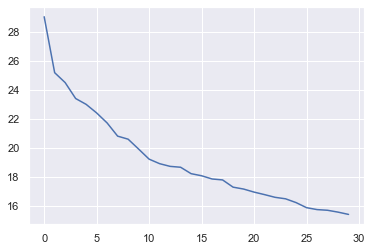

In [560]:
plt.plot(Sigma)

In [561]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

Topic 0:  ['flowers(0.37)', 'nature(0.28)', 'flower(0.27)']
Topic 1:  ['pour(0.43)', 'fluid(0.37)', 'ocean(0.36)']
Topic 2:  ['pour(0.5)', 'fluid(0.44)', 'ocean(-0.28)']
Topic 3:  ['pet(0.53)', 'dog(0.45)', 'animal(0.31)']
Topic 4:  ['ocean(0.46)', 'nature(-0.34)', 'trees(-0.28)']
Topic 5:  ['life(0.42)', 'pink(-0.4)', 'still(0.39)']
Topic 6:  ['woman(0.66)', 'signed(0.27)', 'nature(-0.24)']
Topic 7:  ['signed(0.51)', 'flowers(0.32)', 'life(-0.26)']
Topic 8:  ['pink(0.64)', 'woman(-0.41)', 'signed(0.28)']
Topic 9:  ['office(0.43)', 'living(0.39)', 'pink(-0.32)']
Topic 10:  ['nature(0.55)', 'flowers(-0.36)', 'trees(-0.32)']
Topic 11:  ['flower(0.57)', 'flowers(-0.49)', 'antique(0.45)']
Topic 12:  ['textured(0.48)', 'orange(0.38)', 'house(-0.34)']
Topic 13:  ['antique(0.54)', 'air(-0.38)', 'plein(-0.37)']
Topic 14:  ['kind(0.77)', 'textured(-0.38)', 'orange(-0.21)']
Topic 15:  ['textured(0.63)', 'orange(-0.58)', 'bright(-0.25)']
Topic 16:  ['house(-0.51)', 'living(0.43)', 'office(0.31)']

In [562]:
#Which are the most predictive 'topics' in the decision tree?

In [563]:
#What are the style words or word combos that are used most by the tree regressor?
tags_dtree_w_tfidf_SVD_features_imp_df = pd.DataFrame(tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
tags_dtree_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_tags_topics)
tags_dtree_w_tfidf_SVD_features_imp_df = tags_dtree_w_tfidf_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
tags_dtree_w_tfidf_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
2                   0.145099   
3                   0.134996   
7                   0.108498   
1                   0.086847   
6                   0.053245   
13                  0.048095   
17                  0.039161   
28                  0.035753   
5                   0.033852   
29                  0.033350   
21                  0.029845   
0                   0.028212   
4                   0.027939   
26                  0.023407   
8                   0.022988   
16                  0.020389   
18                  0.017555   
22                  0.013592   
9                   0.013048   
25                  0.012986   

                                                Topic  
2              [pour(0.5), fluid(0.44), ocean(-0.28)]  
3                [pet(0.53), dog(0.45), animal(0.31)]  
7          [signed(0.51), flowers(0.32), life(-0.26)]  
1              [pour(0.43), fluid(0.37), ocean(0.36)]  
6          [woman(0.66), signed(0.27), nature(-0.24)]  
13          [antique(0.54), air(-0.38), plein(-0.37)]  
17           [antique(0.5), signed(-0.43), air(0.42)]  
28         [rectangle(0.37), bird(-0.32), tree(0.32)]  
5               [life(0.42), pink(-0.4), still(0.39)]  
29       [mountain(0.4), trees(-0.34), living(-0.27)]  
21  [decoration(0.56), animal(0.44), geometric(-0.3)]  
0         [flowers(0.37), nature(0.28), flower(0.27)]  
4          [ocean(0.46), nature(-0.34), trees(-0.28)]  
26    [seascape(0.61), rectangle(0.26), ocean(-0.25)]  
8            [pink(0.64), woman(-0.41), signed(0.28)]  
16         [house(-0.51), living(0.43), office(0.31)]  
18     [bright(0.67), orange(-0.49), geometric(0.37)]  
22  [decoration(0.66), geometric(0.4), animal(-0.29)]  
9           [office(0.43), living(0.39), pink(-0.32)]  
25   [office(-0.45), living(0.43), decoration(-0.25)]

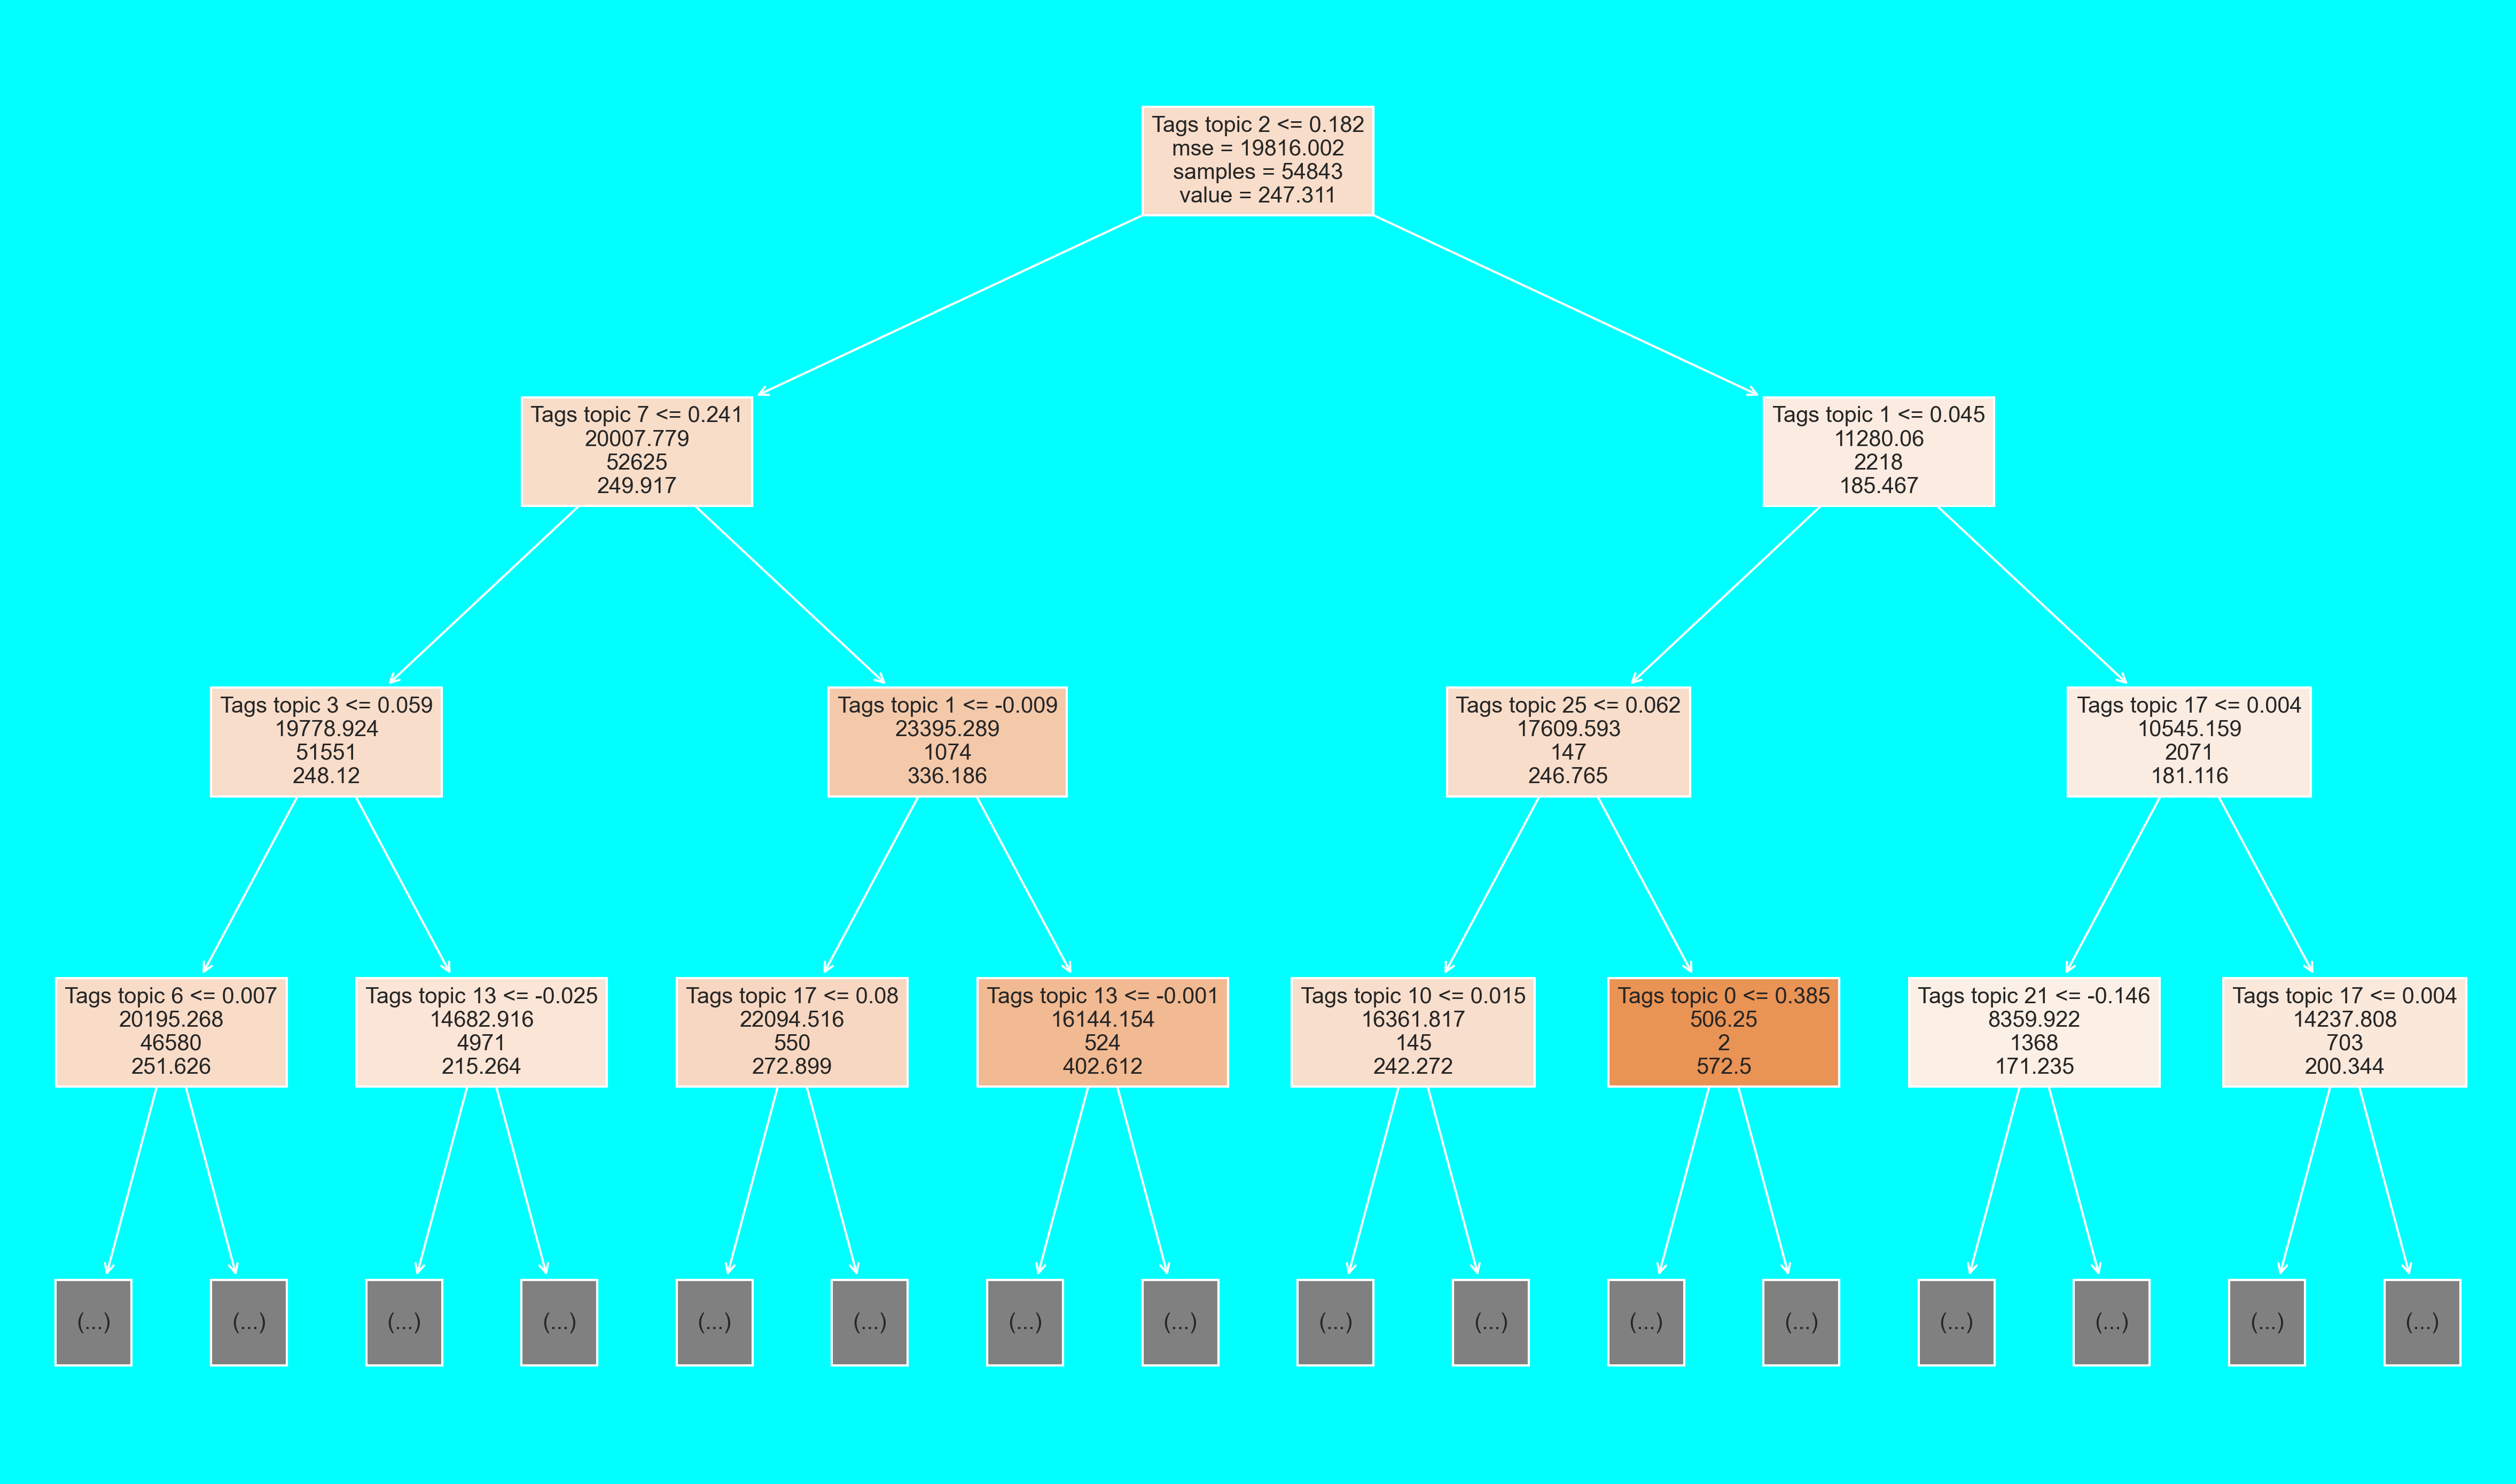

In [564]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_tags_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_tags_after_tfidf_SVD.png')

#### Model 6c) Random Forest on (generic) Tags (with Tf-Idf vectorization and SVD reduction)

In [565]:
from sklearn.ensemble import RandomForestRegressor

In [566]:
#Let's first check the version without SVD reduction to get a baseline performance 
tags_rforest_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=tags_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [567]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

tags_rforest_pipe_filename = './Git_exclude/models/tags_rforest_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(tags_rforest_pipe_filename, 'rb') as f:
        tags_rforest_pipe = load(f)
        print('Loaded pickle file with random forest model for tags (with Tf-Idf but no SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_rforest_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_rforest_pipe_filename, 'wb') as f:
        dump(tags_rforest_pipe, f, recurse=True) 
        print('Saved pickle file with random forest model for tags (with Tf-Idf but no SVD).')

Loaded pickle file with random forest model for tags (with Tf-Idf but no SVD).


In [568]:
#Predict prices on training set:
prices_train_pred = tags_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_rforest_pipe.score(paintings_df_train,prices_train)

0.10243019490245642

In [569]:
#Predict prices on test set:
prices_test_pred = tags_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_rforest_pipe.score(paintings_df_test,prices_test)

0.07868412655326906

In [570]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using generic tags (without Tf-Idf)')


Random Forest model using generic tags (without Tf-Idf):
Training R^2: 0.10243019490245642
Testing R^2: 0.07868412655326906
Training RMSE: USD 133.36508343045463
Testing RMSE: USD 136.4381879256176
Training MAE: USD 107.46493904401856
Testing MAE: USD 109.86405689677697


In [571]:
feature_names_tags_rforest = tags_rforest_pipe['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [572]:
feature_names_tags_rforest[:20]

['10',
 '11',
 '11x14',
 '12',
 '14',
 '140lb',
 '16',
 '16x20',
 '18',
 '18x24',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '20',
 '20th',
 '24',
 '30',
 '3d',
 '3d prints']

In [573]:
tags_rforest_features_imp_df = pd.DataFrame(tags_rforest_pipe['rforest'].feature_importances_,feature_names_tags_rforest,columns=['Rforest feature importance'])
tags_rforest_features_imp_df = tags_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
tags_rforest_features_imp_df

Rforest feature importance
pour                              0.052757
signed                            0.038671
rectangle                         0.035230
oversized                         0.031325
fluid                             0.028053
...                                    ...
daisy                             0.000015
strange                           0.000010
gogh                              0.000010
flowers spring                    0.000009
ralph                             0.000002

[668 rows x 1 columns]

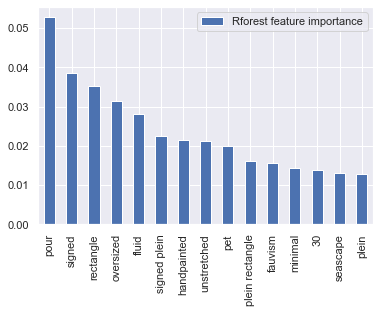

In [574]:
tags_rforest_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

##### Now let's introduce SVD reduction

In [575]:
from sklearn.ensemble import RandomForestRegressor

In [576]:
from sklearn.decomposition import TruncatedSVD

tags_rforest_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=tags_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [577]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

tags_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/tags_rforest_w_tfidf_SVD_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(tags_rforest_w_tfidf_SVD_pipe_filename, 'rb') as f:
        tags_rforest_w_tfidf_SVD_pipe = load(f)
        print('Loaded pickle file with random forest model for tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_rforest_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_rforest_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(tags_rforest_w_tfidf_SVD_pipe, f, recurse=True) 
        print('Saved pickle file with random forest model for tags (after Tf-Idf and SVD).')

Loaded pickle file with random forest model for tags (after Tf-Idf and SVD).


In [578]:
#Predict prices on training set:
prices_train_pred = tags_rforest_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_rforest_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.09787104031934901

In [579]:
#Predict prices on test set:
prices_test_pred = tags_rforest_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_rforest_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.07210294457952027

In [580]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using generic tags (after Tf-Idf and SVD reduction)')


Random Forest model using generic tags (after Tf-Idf and SVD reduction):
Training R^2: 0.09787104031934901
Testing R^2: 0.07210294457952027
Training RMSE: USD 133.70336456839962
Testing RMSE: USD 136.9246262620573
Training MAE: USD 107.4899940379847
Testing MAE: USD 110.00966499739219


In [581]:
tags_rforest_w_tfidf_SVD_pipe

Pipeline(steps=[('tags tfidf vectorization',
                 ColumnTransformer(transformers=[('tags tfidf',
                                                  Pipeline(steps=[('to single '
                                                                   'string',
                                                                   TagsEncoder()),
                                                                  ('to tfidf '
                                                                   'n-grams',
                                                                   TfidfVectorizer(max_df=0.8,
                                                                                   max_features=1000,
                                                                                   min_df=100,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words=['art',
                                                                                               'artwork',
                                                                                               'painting',
                                                                                               'paintings',
                                                                                               'paint',
                                                                                               'paintin',
                                                                                               'paints',
                                                                                               'painter',
                                                                                               'painted',
                                                                                               'illustration',
                                                                                               'picture',
                                                                                               'drawing',
                                                                                               'color',
                                                                                               'colors',
                                                                                               'colored',
                                                                                               'colorful',
                                                                                               'and',
                                                                                               'on',
                                                                                               'one',
                                                                                               'of',
                                                                                               'for',
                                                                                               'to',
                                                                                               'in',
                                                                                               'the',
                                                                                               'a',
                                                                                               'an',
                                                                                               'at',
                                                                                               'with',
                                                                                           

In [582]:
#what are the main features used for decision?
tags_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_

array([0.0197527 , 0.02782671, 0.05905279, 0.04618156, 0.0240848 ,
       0.03531623, 0.04244445, 0.0572525 , 0.02325867, 0.01981881,
       0.01301068, 0.01583966, 0.01229958, 0.02039215, 0.01819688,
       0.01086612, 0.02707362, 0.02698278, 0.01227946, 0.01511289,
       0.01108364, 0.02243915, 0.01201059, 0.01345669, 0.0105222 ,
       0.01596019, 0.02010796, 0.02421711, 0.01861733, 0.01299124,
       0.03718141, 0.01084536, 0.01264311, 0.02341568, 0.01642861,
       0.01480531, 0.02254864, 0.01584888, 0.00993992, 0.01317693,
       0.01325674, 0.0141091 , 0.01475958, 0.01559129, 0.01494638,
       0.01179635, 0.01498761, 0.0110677 , 0.01224751, 0.01195475])

In [583]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_rforest_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

In [584]:
#What are the tags words or word combos that are used most by the random forest regressor?
tags_rforest_w_tfidf_SVD_features_imp_df = pd.DataFrame(tags_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
tags_rforest_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_tags_topics)
tags_rforest_w_tfidf_SVD_features_imp_df = tags_rforest_w_tfidf_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
tags_rforest_w_tfidf_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
2                     0.059053   
7                     0.057252   
3                     0.046182   
6                     0.042444   
30                    0.037181   
5                     0.035316   
1                     0.027827   
16                    0.027074   
17                    0.026983   
27                    0.024217   
4                     0.024085   
33                    0.023416   
8                     0.023259   
36                    0.022549   
21                    0.022439   
13                    0.020392   
26                    0.020108   
9                     0.019819   
0                     0.019753   
28                    0.018617   

                                                Topic  
2              [pour(0.5), fluid(0.44), ocean(-0.28)]  
7          [signed(0.51), flowers(0.32), life(-0.26)]  
3                [pet(0.53), dog(0.45), animal(0.31)]  
6          [woman(0.66), signed(0.27), nature(-0.24)]  
30          [fluid(0.67), pour(-0.61), pouring(0.16)]  
5               [life(0.42), pink(-0.4), still(0.39)]  
1              [pour(0.43), fluid(0.37), ocean(0.36)]  
16         [house(-0.54), living(0.44), office(0.34)]  
17          [antique(0.52), air(0.43), signed(-0.43)]  
27    [seascape(0.48), rectangle(-0.36), tree(-0.21)]  
4          [ocean(0.46), nature(-0.34), trees(-0.28)]  
33              [bird(-0.46), farm(0.41), barn(0.25)]  
8            [pink(0.64), woman(-0.41), signed(0.28)]  
36               [gray(0.65), sky(-0.23), fall(0.22)]  
21  [geometric(0.52), decoration(-0.45), animal(-0...  
13            [antique(-0.54), air(0.4), plein(0.38)]  
26         [office(0.41), living(-0.39), house(-0.3)]  
9           [office(0.43), living(0.39), pink(-0.32)]  
0         [flowers(0.37), nature(0.28), flower(0.27)]  
28   [office(0.4), rectangle(-0.35), seascape(-0.35)]

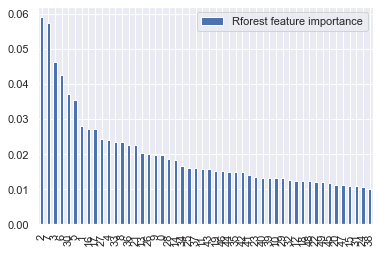

In [585]:
tags_rforest_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 6d) Gradient Boosted Trees on (generic) Tags 

In [586]:
from sklearn.ensemble import GradientBoostingRegressor

In [587]:
#Let's first start with a version without SVD reduction, as a baseline
tags_gboost_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=tags_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']-3,random_state=1,min_samples_leaf=10))
])

In [588]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

tags_gboost_pipe_filename = './Git_exclude/models/tags_gboost_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(tags_gboost_pipe_filename, 'rb') as f:
        tags_gboost_pipe = load(f)
        print('Loaded pickle file with gradient boosting model for tags (with Tf-Idf but no SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_gboost_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_gboost_pipe_filename, 'wb') as f:
        dump(tags_gboost_pipe, f, recurse=True) 
        print('Saved pickle file with gradient boosting model for tags (with Tf-Idf but no SVD).')

Loaded pickle file with gradient boosting model for tags (with Tf-Idf but no SVD).


In [589]:
#Predict prices on training set:
prices_train_pred = tags_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_gboost_pipe.score(paintings_df_train,prices_train)

0.30502051711753453

In [590]:
#Predict prices on test set:
prices_test_pred = tags_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_gboost_pipe.score(paintings_df_test,prices_test)

0.14499304357858867

In [591]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using generic tags (with Tf-Idf but no SVD reduction)')


Gradient Boosting model using generic tags (with Tf-Idf but no SVD reduction):
Training R^2: 0.30502051711753453
Testing R^2: 0.14499304357858867
Training RMSE: USD 117.35295118652567
Testing RMSE: USD 131.43665259129787
Training MAE: USD 93.95265839516027
Testing MAE: USD 103.8197305472894


In [592]:
#what are the main features used for decision?
tags_gboost_pipe['gboost'].feature_importances_[:20]

array([0.00147971, 0.00060745, 0.00147232, 0.00109754, 0.00039484,
       0.00060724, 0.00046198, 0.00130043, 0.00134378, 0.00090393,
       0.00029052, 0.00109098, 0.00058541, 0.00621551, 0.00080558,
       0.00121395, 0.003472  , 0.00482546, 0.00075576, 0.00123071])

In [593]:
feature_names_tags_gboost = tags_gboost_pipe['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [594]:
feature_names_tags_gboost[:20]

['10',
 '11',
 '11x14',
 '12',
 '14',
 '140lb',
 '16',
 '16x20',
 '18',
 '18x24',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '20',
 '20th',
 '24',
 '30',
 '3d',
 '3d prints']

In [595]:
tags_gboost_features_imp_df = pd.DataFrame(tags_gboost_pipe['gboost'].feature_importances_,feature_names_tags_gboost,columns=['Gboost feature importance'])
tags_gboost_features_imp_df = tags_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
tags_gboost_features_imp_df

Gboost feature importance
signed                                       0.022192
rectangle                                    0.018027
pour                                         0.017269
oversized                                    0.010747
seascape                                     0.009696
...                                               ...
underwater tie                               0.000000
fluid pour                                   0.000000
prints graphic                               0.000000
vibrant jillkrutickfineart                   0.000000
krutick                                      0.000000

[668 rows x 1 columns]

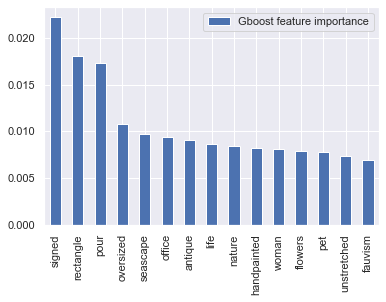

In [596]:
tags_gboost_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

##### Now let's introduce SVD reduction

In [597]:
from sklearn.ensemble import GradientBoostingRegressor

In [598]:
from sklearn.decomposition import TruncatedSVD

tags_gboost_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=tags_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1,min_samples_leaf=10))
])

In [599]:
#Train and possibly save the model
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

tags_gboost_w_tfidf_SVD_pipe_filename = './Git_exclude/models/tags_gboost_w_tfidf_SVD_pipe.pickle'

#If the model file already exists, I load it:
try:
    with open(tags_gboost_w_tfidf_SVD_pipe_filename, 'rb') as f:
        tags_gboost_w_tfidf_SVD_pipe = load(f)
        print('Loaded pickle file with gradient boosting model for tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_gboost_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_gboost_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(tags_gboost_w_tfidf_SVD_pipe, f, recurse=True) 
        print('Saved pickle file with gradient boosting model for tags (after Tf-Idf and SVD).')

Loaded pickle file with gradient boosting model for tags (after Tf-Idf and SVD).


In [600]:
#Predict prices on training set:
prices_train_pred = tags_gboost_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_gboost_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.13076659187405082

In [601]:
#Predict prices on test set:
prices_test_pred = tags_gboost_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_gboost_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.08824222974949791

In [602]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using generic tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using generic tags (after Tf-Idf and SVD reduction):
Training R^2: 0.13076659187405082
Testing R^2: 0.08824222974949791
Training RMSE: USD 131.24302406573233
Testing RMSE: USD 135.7286103166289
Training MAE: USD 104.9762316273279
Testing MAE: USD 108.39873110517068


In [603]:
#what are the main features used for decision?
tags_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_

array([0.03746653, 0.0216825 , 0.04699063, 0.04794144, 0.01394944,
       0.03203138, 0.04185104, 0.03780247, 0.02345229, 0.0234235 ,
       0.01400633, 0.01644399, 0.01380107, 0.01191026, 0.01593314,
       0.01286761, 0.02538983, 0.02487629, 0.01210334, 0.01883224,
       0.01190114, 0.0208164 , 0.01369496, 0.0146227 , 0.01057176,
       0.01365961, 0.01972834, 0.04274505, 0.01858956, 0.01259861,
       0.01682596, 0.01376875, 0.01339641, 0.01162114, 0.01963651,
       0.02887875, 0.01329505, 0.01624277, 0.01251276, 0.01723505,
       0.01420714, 0.01457671, 0.01302235, 0.01219911, 0.0135297 ,
       0.01679018, 0.02364796, 0.0178972 , 0.02078407, 0.01824897])

In [604]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_gboost_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

In [605]:
#What are the tags words or word combos that are used most by the random forest regressor?
tags_gboost_w_tfidf_SVD_features_imp_df = pd.DataFrame(tags_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
tags_gboost_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_tags_topics)
tags_gboost_w_tfidf_SVD_features_imp_df = tags_gboost_w_tfidf_SVD_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
tags_gboost_w_tfidf_SVD_features_imp_df.iloc[:20]

Gboost feature importance  \
3                    0.047941   
2                    0.046991   
27                   0.042745   
6                    0.041851   
7                    0.037802   
0                    0.037467   
5                    0.032031   
35                   0.028879   
16                   0.025390   
17                   0.024876   
46                   0.023648   
8                    0.023452   
9                    0.023423   
1                    0.021683   
21                   0.020816   
48                   0.020784   
26                   0.019728   
34                   0.019637   
19                   0.018832   
28                   0.018590   

                                                Topic  
3                [pet(0.53), dog(0.45), animal(0.31)]  
2              [pour(0.5), fluid(0.44), ocean(-0.28)]  
27  [rectangle(0.51), seascape(-0.37), fauvism(0.28)]  
6          [woman(0.66), signed(0.27), nature(-0.24)]  
7          [signed(0.51), flowers(0.32), life(-0.26)]  
0         [flowers(0.37), nature(0.28), flower(0.27)]  
5               [life(0.42), pink(-0.4), still(0.39)]  
35                [gray(0.72), brown(0.2), sky(-0.2)]  
16         [house(-0.54), living(0.44), office(0.33)]  
17          [antique(0.52), air(0.43), signed(-0.42)]  
46        [rainbow(-0.39), music(0.36), vibrant(0.3)]  
8            [pink(0.64), woman(-0.41), signed(0.28)]  
9           [office(0.43), living(0.39), pink(-0.32)]  
1              [pour(0.43), fluid(0.37), ocean(0.36)]  
21  [geometric(0.55), decoration(-0.45), animal(-0...  
48       [brown(0.29), music(0.29), beautiful(-0.26)]  
26         [living(0.46), office(-0.43), house(0.35)]  
34            [female(0.39), woman(-0.38), nude(0.3)]  
19       [square(0.81), bright(-0.41), sunset(-0.19)]  
28   [seascape(0.48), rectangle(0.33), office(-0.31)]

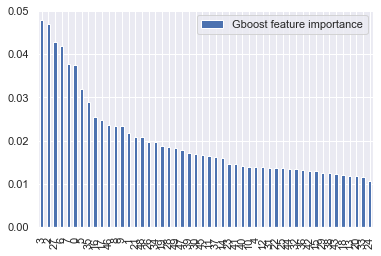

In [606]:
tags_gboost_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 7) Ensemble models blending the predictions from individual models for the different modalities (rather than combining inputs from all modalities under a unique model type) 

To use the existing models as input to a predictor, I turn them into transformers using a custom 'ModelTransformer' class that takes a predictor as an argument. When fit is called, the predictor is fit. When transform is called, the predictor's predict method is called, and its results returned as the transformation.

In [607]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.predictor = model
            
    def fit(self, X, y):
        # Fit the stored predictor.
        self.predictor.fit(X, y)
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # reshape(-1,1) is required to return a 2-D array which is expected by sklearn.
        return np.array(self.predictor.predict(X)).reshape(-1,1)
    

#### 7a) Blending Decision Tree for numerical+categorical features, Decision Tree for style tags (vectorized), Decision Tree for material tags (after Tf-Idf and SVD), Decision Tree for general tags (after Tf-Idf and SVD). 
#### LinearRegression or another Decision Tree is used to blend the 4 models

Create an instance of ModelTransformer for each of the individual models of interest. Then, we'll combine these together in a single feature matrix with a
FeatureUnion.

In [608]:
#Decision Tree model for numerical+categorical features

#Recall that:

# variable_selector_for_trees = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical','passthrough',numerical_columns)
#  ], remainder='drop')

#(I don't want to drop the first variable for tree-based models and I don't need to scale the numerical variables)

#define a pipeline with the best values found earlier via cross-validation

num_plus_cat_dtree_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=9,min_samples_leaf=10)),
])

#Note: this model is saved as: 
#num_plus_cat_dtree_CVmodel_filename = './Git_exclude/models/num_plus_cat_dtree_CVmodel.pickle'
#(if we wanted to load it without having to refit)

num_plus_cat_dtree_trans = ModelTransformer(num_plus_cat_dtree_pipe_final)


In [609]:
#Decision Tree model for style tags (with vectorized style tags (69 features) but without Tf-Idf and SVD dimensionality reduction)

# #Recall that:

# pipe_style_tags_encoding = Pipeline([
#     ('to dict series',DictEncoder()),
#     ('to binary vectors',DictVectorizer())
# ])

# style_tranform = ColumnTransformer([
#     ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# #(I did not need Tf-Idf or SVD reduction because each painting usually only has a handful of style tags, and I kept only the most common ones (69 features)
# # Both Tf-Idf and SVD reduced the performance)

#define a pipeline with the best values found earlier via cross-validation

style_dtree_pipe_final = Pipeline([
    ('style tags vectorization', style_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=12,min_samples_leaf=10)),
])

#Note: this model is saved as: 
#style_dtree_CVmodel_filename = './Git_exclude/models/style_dtree_CVmodel.pickle'
#(if we wanted to load it without having to refit)

style_tags_dtree_trans = ModelTransformer(style_dtree_pipe_final)


In [610]:
#Decision Tree model for material tags (with Tf-Idf of the original 100 tags + bigrams (that occur in very different frequencies) and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# materials_tags_tranform = ColumnTransformer([
#     ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier via cross-validation

materials_dtree_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=78)),
    ('dtree', DecisionTreeRegressor(max_depth=6,min_samples_leaf=10))
])

#Note: this model is saved as: 
#materials_tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/materials_tags_SVD_dtree_CVmodel.pickle'
#(if we wanted to load it without having to refit)

materials_tags_dtree_trans = ModelTransformer(materials_dtree_w_tfidf_SVD_pipe_final)

In [611]:
#Decision Tree model for general tags (with Tf-Idf of the original tags + bigrams and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding_with_stopwords = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier via cross-validation

tags_dtree_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=54)),
    ('dtree', DecisionTreeRegressor(max_depth=6,min_samples_leaf=10))
])

#Note: this model is saved as: 
#tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/tags_SVD_dtree_CVmodel.pickle'
#(if we wanted to load it without having to refit)

tags_dtree_trans = ModelTransformer(tags_dtree_w_tfidf_SVD_pipe_final)

In [612]:
#Let's now combine the 4 predictors-transformers into a feature union.

In [613]:
from sklearn.pipeline import FeatureUnion

dtree_models_union = FeatureUnion([
        ('num plus cat model', num_plus_cat_dtree_trans),
        ('style tags model',style_tags_dtree_trans),
        ('materials tags model',materials_tags_dtree_trans),
        ('other tags model',tags_dtree_trans),
    ])

In [614]:
dtree_models_union

FeatureUnion(transformer_list=[('num plus cat model',
                                ModelTransformer(model=None)),
                               ('style tags model',
                                ModelTransformer(model=None)),
                               ('materials tags model',
                                ModelTransformer(model=None)),
                               ('other tags model',
                                ModelTransformer(model=None))])

#### LinearRegression blending the 4 models

In [615]:
from sklearn.linear_model import LinearRegression

#note: there is no need of scaling because the output of each transformer is a price prediction in this case,
#and thus all columns are in the same unit and comparable with each other.

blended_model_dtree_linear = Pipeline([
    ('individual dtree models', dtree_models_union),
    ('linear combination', LinearRegression())
])
blended_model_dtree_linear

Pipeline(steps=[('individual dtree models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [616]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best linear combination coefficients
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

blended_model_dtree_linear_filename = './Git_exclude/models/blended_model_dtree_linear.pickle'

#If the model file already exists, I load it:
try:
    with open(blended_model_dtree_linear_filename, 'rb') as f:
        blended_model_dtree_linear = load(f)
        print('Loaded pickle file with linear blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_dtree_linear.fit(paintings_df_train,prices_train);
    
    with open(blended_model_dtree_linear_filename, 'wb') as f:
        dump(blended_model_dtree_linear, f, recurse=True) 
        print('Saved pickle file with linear blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded pickle file with linear blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.


In [617]:
#Here are the weights learnt for each of the individual models:
blended_model_dtree_linear['linear combination'].coef_

array([0.90171532, 0.347931  , 0.18329676, 0.26489953])

In [618]:
#Predict prices on training set:
prices_train_pred = blended_model_dtree_linear.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_dtree_linear.score(paintings_df_train,prices_train)

0.36044931554275983

In [619]:
#Predict prices on test set:
prices_test_pred = blended_model_dtree_linear.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_dtree_linear.score(paintings_df_test,prices_test)

0.3075523676680145

In [620]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags')


Linear blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.36044931554275983
Testing R^2: 0.3075523676680145
Training RMSE: USD 112.5759208066328
Testing RMSE: USD 118.28376322048486
Training MAE: USD 85.26352925828684
Testing MAE: USD 89.22727929516954


#### Final Decision Tree blending the 4 decision tree models

In [621]:
blended_model_dtree_dtree = Pipeline([
    ('individual dtree models', dtree_models_union),
    ('final dtree', DecisionTreeRegressor(max_depth=4,min_samples_leaf=10))
])
blended_model_dtree_dtree

Pipeline(steps=[('individual dtree models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('final dtree',
                 DecisionTreeRegressor(max_depth=4, min_samples_leaf=10))])

In [622]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best decision tree
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

blended_model_dtree_dtree_filename = './Git_exclude/models/blended_model_dtree_dtree.pickle'

#If the model file already exists, I load it:
try:
    with open(blended_model_dtree_dtree_filename, 'rb') as f:
        blended_model_dtree_dtree = load(f)
        print('Loaded pickle file with dtree blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_dtree_dtree.fit(paintings_df_train,prices_train);
    
    with open(blended_model_dtree_dtree_filename, 'wb') as f:
        dump(blended_model_dtree_dtree, f, recurse=True) 
        print('Saved pickle file with dtree blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded pickle file with dtree blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.


In [623]:
#Predict prices on training set:
prices_train_pred = blended_model_dtree_dtree.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_dtree_dtree.score(paintings_df_train,prices_train)

0.3486347008493784

In [624]:
#Predict prices on test set:
prices_test_pred = blended_model_dtree_dtree.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_dtree_dtree.score(paintings_df_test,prices_test)

0.2894970157206833

In [625]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Dtree blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags')


Dtree blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.3486347008493784
Testing R^2: 0.2894970157206833
Training RMSE: USD 113.61098705431095
Testing RMSE: USD 119.81594546827071
Training MAE: USD 85.81129721721008
Testing MAE: USD 89.78782392369753


In [626]:
#what are the main features used by the final decision tree?
blended_model_dtree_dtree['final dtree'].feature_importances_

array([0.97093408, 0.02524007, 0.        , 0.00382584])

In [627]:
individual_model_names = ['Num+Cat','Style','Materials','Other Tags']

blended_model_dtree_dtree_features_imp_df = pd.DataFrame(blended_model_dtree_dtree['final dtree'].feature_importances_,individual_model_names,columns=['Dtree feature importance'])
blended_model_dtree_dtree_features_imp_df = blended_model_dtree_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
blended_model_dtree_dtree_features_imp_df

Dtree feature importance
Num+Cat                     0.970934
Style                       0.025240
Other Tags                  0.003826
Materials                   0.000000

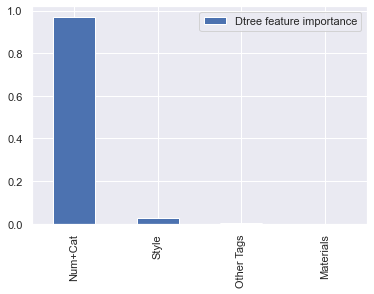

In [628]:
blended_model_dtree_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

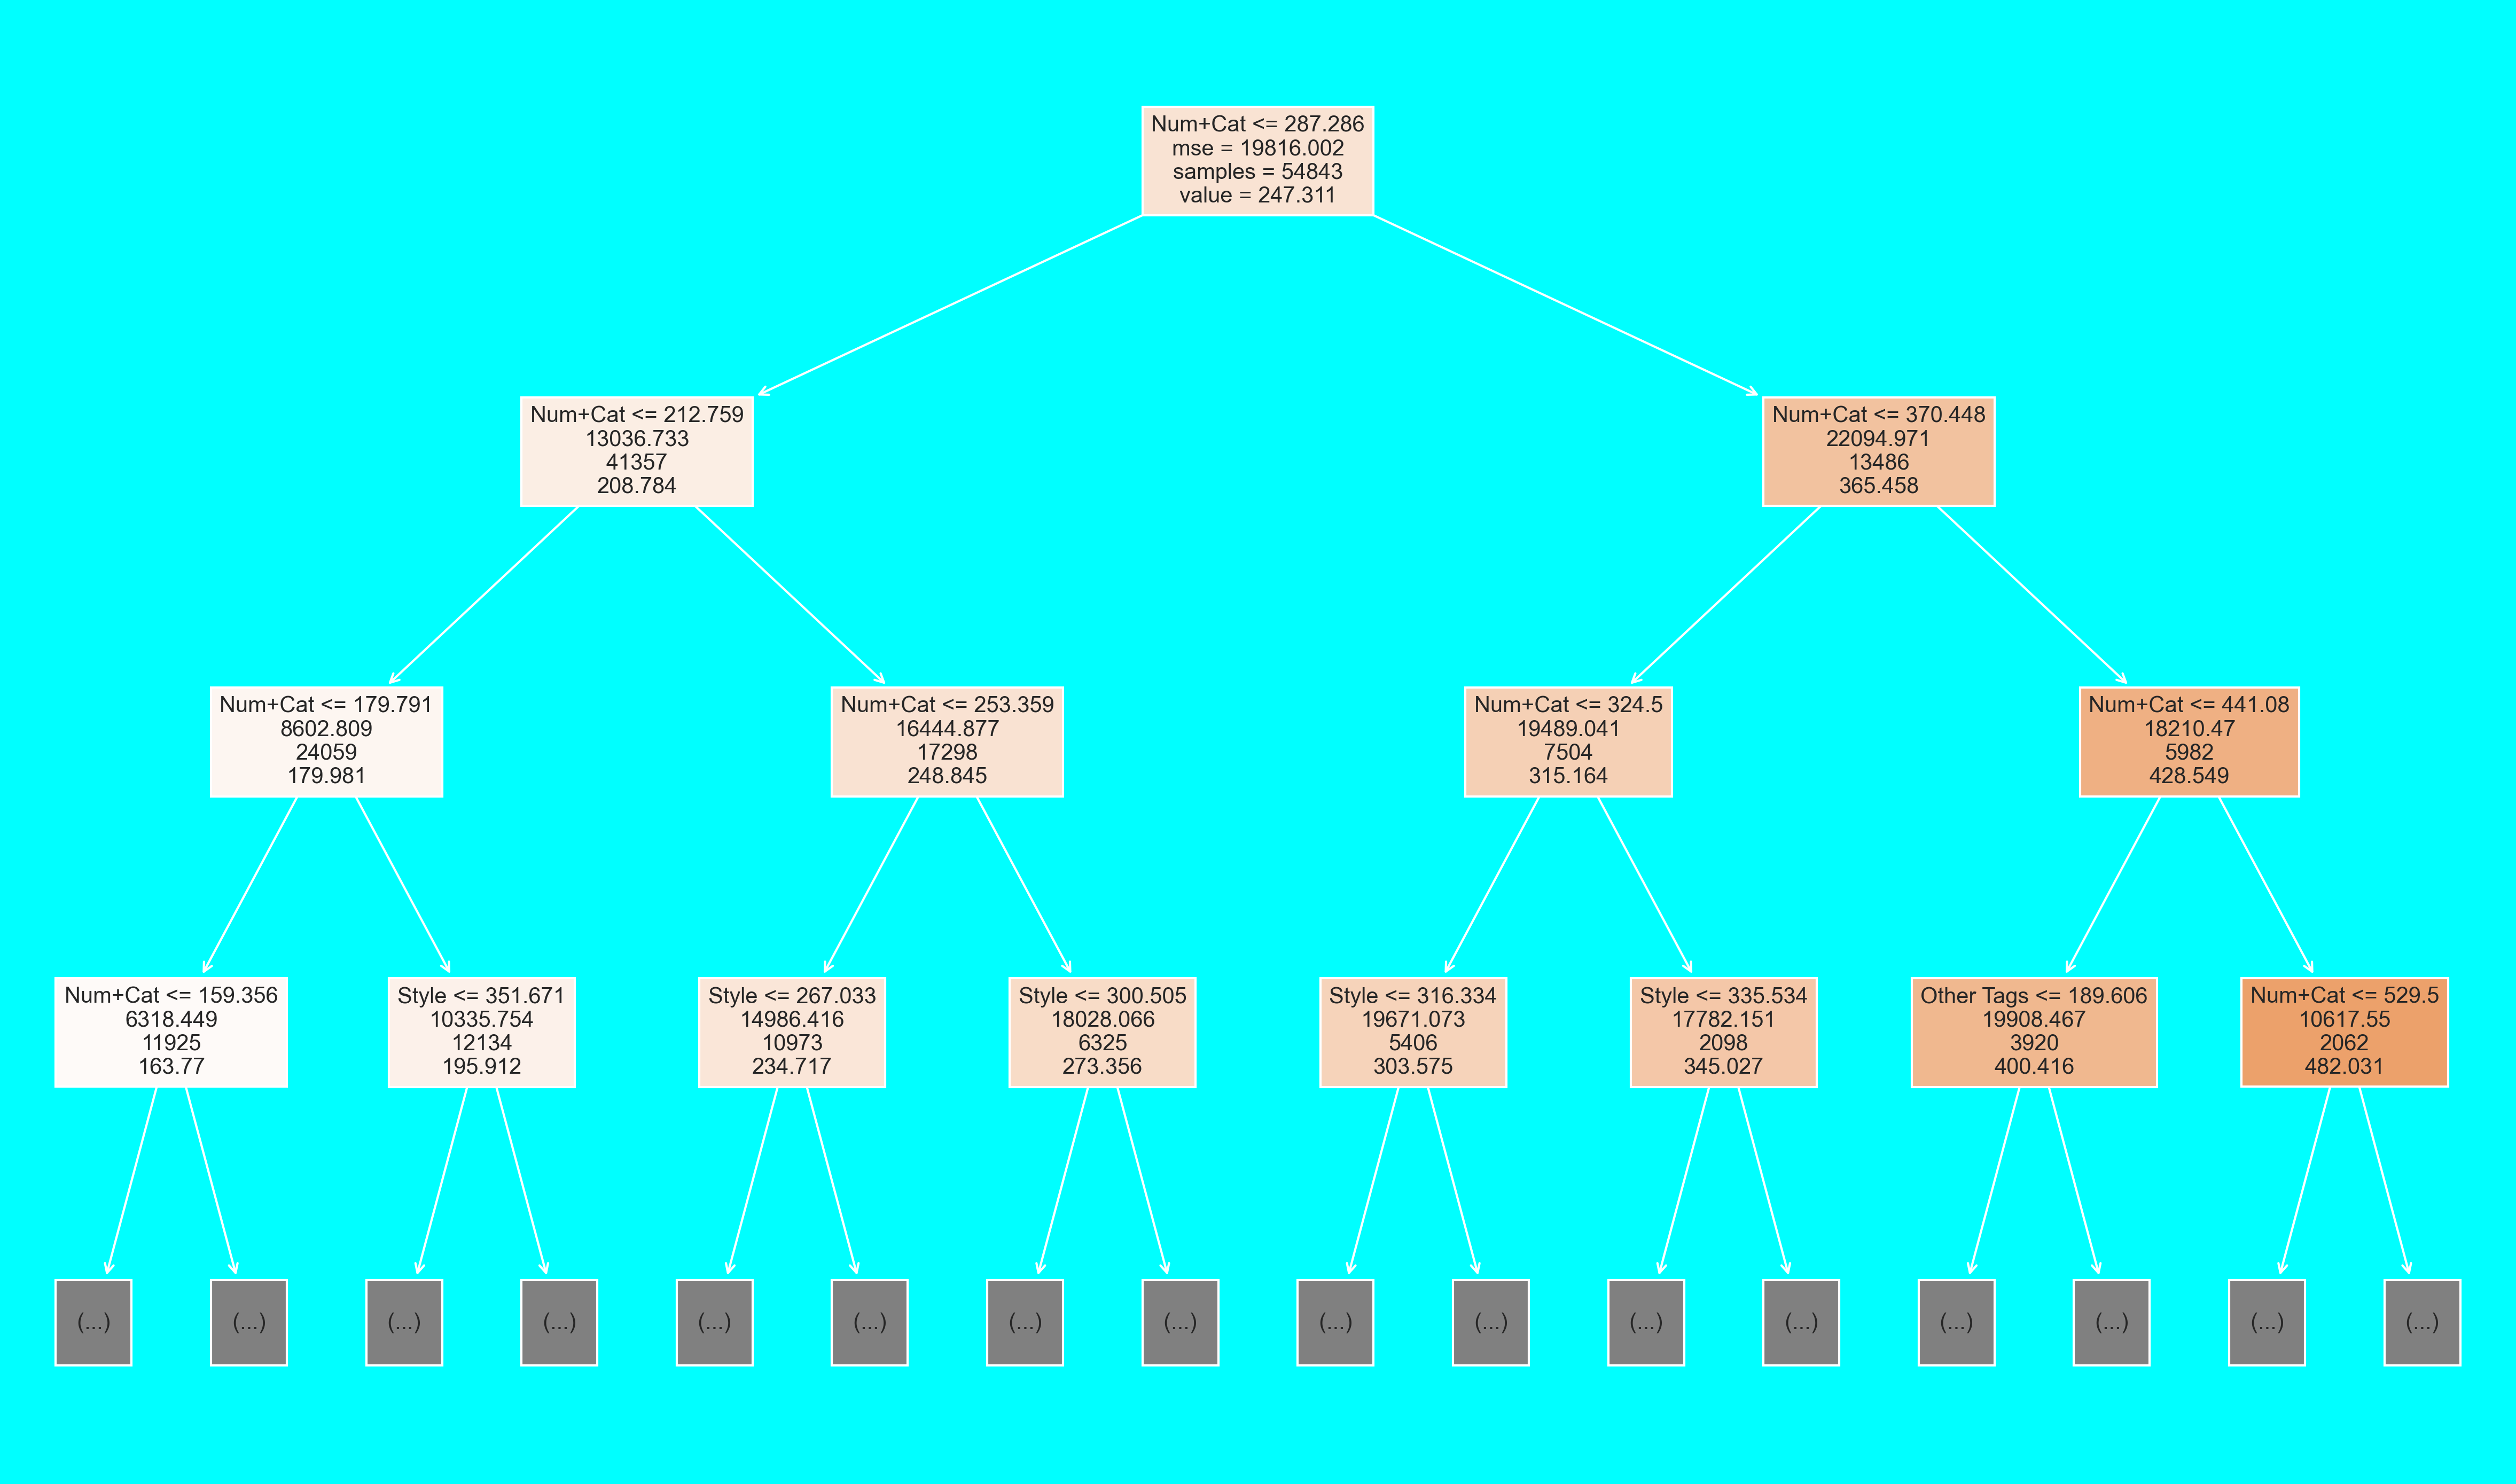

In [629]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(blended_model_dtree_dtree['final dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = individual_model_names)
fig.savefig('./Git_exclude/Figures/decision_tree_blended_model_dtree_dtree.png')

#### 7b) Blending Random Forests for numerical+categorical features, Random Forests for style tags (vectorized), Random Forests for material tags (after Tf-Idf and SVD), Random Forests for general tags (after Tf-Idf and SVD). 
#### LinearRegression or another Random Forest is used to blend the 4 models

In [630]:
#Random Forests model for numerical+categorical features

#Recall that:

# variable_selector_for_trees = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical','passthrough',numerical_columns)
#  ], remainder='drop')

#(I don't want to drop the first variable for tree-based models and I don't need to scale the numerical variables)

#define a pipeline with the best values found earlier 

num_plus_cat_rforest_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=10,random_state=1,max_samples=0.8,min_samples_leaf=10))
])
#Recall that: num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']=9 and I increased max_depth by 1 for the random forests

#Note: this model is saved as: 
#num_plus_cat_rforest_pipe_filename = './Git_exclude/models/num_plus_cat_rforest_pipe.pickle'
#(if we wanted to load it without having to refit)

num_plus_cat_rforest_trans = ModelTransformer(num_plus_cat_rforest_pipe_final)


In [631]:
#Random Forests model for style tags (with vectorized style tags (69 features) but without Tf-Idf and SVD dimensionality reduction)

# #Recall that:

# pipe_style_tags_encoding = Pipeline([
#     ('to dict series',DictEncoder()),
#     ('to binary vectors',DictVectorizer())
# ])

# style_tranform = ColumnTransformer([
#     ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# #(I did not need Tf-Idf or SVD reduction because each painting usually only has a handful of style tags, and I kept only the most common ones (69 features)
# # Both Tf-Idf and SVD reduced the performance)

#define a pipeline with the best values found earlier

style_rforest_pipe_final = Pipeline([
    ('style tags vectorization', style_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=13,random_state=1,max_samples=0.8,min_samples_leaf=10)) 
])

#Recall that: style_dtree_CVmodel.best_params_['dtree__max_depth']=12 and I increased max_depth by 1 for the random forests

#Note: this model is saved as: 
#style_rforest_pipe_filename = './Git_exclude/models/style_rforest_pipe.pickle'
#(if we wanted to load it without having to refit)

style_tags_rforest_trans = ModelTransformer(style_rforest_pipe_final)


In [632]:
#Random Forests model for material tags (with Tf-Idf of the original 100 tags + bigrams (that occur in very different frequencies) and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# materials_tags_tranform = ColumnTransformer([
#     ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier

materials_rforest_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',max_depth=7,n_jobs=2,random_state=1,max_samples=0.8,min_samples_leaf=10)) 
])

#Recall that: materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']=6 and I increased max_depth by 1 for the random forests

#Note: this model is saved as: 
#materials_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/materials_rforest_w_tfidf_SVD_pipe.pickle'
#(if we wanted to load it without having to refit)

materials_tags_rforest_trans = ModelTransformer(materials_rforest_w_tfidf_SVD_pipe_final)

In [633]:
#Random Forests model for general tags (with Tf-Idf of the original tags + bigrams and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding_with_stopwords = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier 

tags_rforest_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=7,random_state=1,max_samples=0.8,min_samples_leaf=10)) 
])

#Recall that: tags_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']=6 and I increased max_depth by 1 for the random forests


#Note: this model is saved as: 
#tags_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/tags_rforest_w_tfidf_SVD_pipe.pickle'
#(if we wanted to load it without having to refit)

tags_rforest_trans = ModelTransformer(tags_rforest_w_tfidf_SVD_pipe_final)

In [634]:
#Let's now combine the 4 predictors-transformers into a feature union.

In [635]:
from sklearn.pipeline import FeatureUnion

rforest_models_union = FeatureUnion([
        ('num plus cat model', num_plus_cat_rforest_trans),
        ('style tags model',style_tags_rforest_trans),
        ('materials tags model',materials_tags_rforest_trans),
        ('other tags model',tags_rforest_trans),
    ])

In [636]:
rforest_models_union

FeatureUnion(transformer_list=[('num plus cat model',
                                ModelTransformer(model=None)),
                               ('style tags model',
                                ModelTransformer(model=None)),
                               ('materials tags model',
                                ModelTransformer(model=None)),
                               ('other tags model',
                                ModelTransformer(model=None))])

#### LinearRegression blending the 4 random forest models

In [637]:
from sklearn.linear_model import LinearRegression

#note: there is no need of scaling because the output of each transformer is a price prediction in this case,
#and thus all columns are in the same unit and comparable with each other.

blended_model_rforest_linear = Pipeline([
    ('individual rforest models', rforest_models_union),
    ('linear combination', LinearRegression())
])
blended_model_rforest_linear

Pipeline(steps=[('individual rforest models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [638]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best linear combination coefficients
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

blended_model_rforest_linear_filename = './Git_exclude/models/blended_model_rforest_linear.pickle'

#If the model file already exists, I load it:
try:
    with open(blended_model_rforest_linear_filename, 'rb') as f:
        blended_model_rforest_linear = load(f)
        print('Loaded pickle file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_rforest_linear.fit(paintings_df_train,prices_train);
    
    with open(blended_model_rforest_linear_filename, 'wb') as f:
        dump(blended_model_rforest_linear, f, recurse=True) 
        print('Saved pickle file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded pickle file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.


In [639]:
#Here are the weights learnt for each of the individual models:
blended_model_rforest_linear['linear combination'].coef_

array([1.11488888, 0.4614238 , 0.12906683, 0.3261548 ])

In [640]:
blended_model_rforest_linear['linear combination'].intercept_

-255.01414358817863

In [641]:
#individual_model_names = ['Num+Cat','Style','Materials','Other Tags']

blended_model_rforest_linear_coeff_df = pd.DataFrame(blended_model_rforest_linear['linear combination'].coef_,individual_model_names,columns=['Linear Reg Coeff'])
blended_model_rforest_linear_coeff_df = blended_model_rforest_linear_coeff_df.sort_values(by='Linear Reg Coeff',ascending=False)
blended_model_rforest_linear_coeff_df

Linear Reg Coeff
Num+Cat             1.114889
Style               0.461424
Other Tags          0.326155
Materials           0.129067

In [642]:
#Predict prices on training set:
prices_train_pred = blended_model_rforest_linear.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_rforest_linear.score(paintings_df_train,prices_train)

0.39599722437926643

In [643]:
#Predict prices on test set:
prices_test_pred = blended_model_rforest_linear.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_rforest_linear.score(paintings_df_test,prices_test)

0.3532484682809862

In [644]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags')


Linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.39599722437926665
Testing R^2: 0.3532484682809862
Training RMSE: USD 109.40256165196068
Testing RMSE: USD 114.3142572501194
Training MAE: USD 82.67889465974605
Testing MAE: USD 86.0214436974972


#### RidgeRegression blending the 4 random forest models

In [645]:
from sklearn.linear_model import RidgeCV

#note: there is no need of scaling because the output of each transformer is a price prediction in this case,
#and thus all columns are in the same unit and comparable with each other.

blended_model_rforest_ridge = Pipeline([
    ('individual rforest models', rforest_models_union),
    ('ridge', RidgeCV(fit_intercept=False))
])
blended_model_rforest_ridge

Pipeline(steps=[('individual rforest models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('ridge',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                         fit_intercept=False))])

In [646]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best linear combination coefficients
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

blended_model_rforest_ridge_filename = './Git_exclude/models/blended_model_rforest_ridge.pickle'

#If the model file already exists, I load it:
try:
    with open(blended_model_rforest_ridge_filename, 'rb') as f:
        blended_model_rforest_ridge = load(f)
        print('Loaded pickle file with ridge blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_rforest_ridge.fit(paintings_df_train,prices_train);
    
    with open(blended_model_rforest_ridge_filename, 'wb') as f:
        dump(blended_model_rforest_ridge, f, recurse=True) 
        print('Saved pickle file with ridge blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded pickle file with ridge blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.


In [647]:
#Here are the weights learnt for each of the individual models:
blended_model_rforest_ridge['ridge'].coef_

array([ 1.18657115,  0.03138168, -0.15404722, -0.05821794])

In [648]:
blended_model_rforest_ridge['ridge'].intercept_

0.0

In [649]:
#individual_model_names = ['Num+Cat','Style','Materials','Other Tags']

blended_model_rforest_ridge_coeff_df = pd.DataFrame(blended_model_rforest_ridge['ridge'].coef_,individual_model_names,columns=['Linear Reg Coeff'])
blended_model_rforest_ridge_coeff_df = blended_model_rforest_ridge_coeff_df.sort_values(by='Linear Reg Coeff',ascending=False)
blended_model_rforest_ridge_coeff_df

Linear Reg Coeff
Num+Cat             1.186571
Style               0.031382
Other Tags         -0.058218
Materials          -0.154047

In [650]:
#Predict prices on training set:
prices_train_pred = blended_model_rforest_ridge.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_rforest_ridge.score(paintings_df_train,prices_train)

0.3782133075575942

In [651]:
#Predict prices on test set:
prices_test_pred = blended_model_rforest_ridge.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_rforest_ridge.score(paintings_df_test,prices_test)

0.3405563744517167

In [652]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags')


Ridge blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.3782133075575942
Testing R^2: 0.3405563744517167
Training RMSE: USD 111.0014713224422
Testing RMSE: USD 115.4304804205141
Training MAE: USD 84.18459471712313
Testing MAE: USD 87.06255074117583


#### Final Random Forest blending the 4 random forest models

In [653]:

blended_model_rforest_rforest = Pipeline([
    ('individual rforest models', rforest_models_union),
    ('final rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',max_depth=4,n_jobs=2,random_state=1,max_samples=0.8,min_samples_leaf=10))
])
blended_model_rforest_rforest

Pipeline(steps=[('individual rforest models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('final rforest',
                 RandomForestRegressor(max_depth=4, max_features='sqrt',
                                       max_samples=0.8, min_samples_leaf=10,
                                       n_estimators=50, n_jobs=2,
                                       random_state=1))])

In [654]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best decision tree
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

blended_model_rforest_rforest_filename = './Git_exclude/models/blended_model_rforest_rforest.pickle'

#If the model file already exists, I load it:
try:
    with open(blended_model_rforest_rforest_filename, 'rb') as f:
        blended_model_rforest_rforest = load(f)
        print('Loaded pickle file with rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_rforest_rforest.fit(paintings_df_train,prices_train);
    
    with open(blended_model_rforest_rforest_filename, 'wb') as f:
        dump(blended_model_rforest_rforest, f, recurse=True) 
        print('Saved pickle file with rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded pickle file with rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.


In [655]:
#Predict prices on training set:
prices_train_pred = blended_model_rforest_rforest.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_rforest_rforest.score(paintings_df_train,prices_train)

0.39769166520037014

In [656]:
#Predict prices on test set:
prices_test_pred = blended_model_rforest_rforest.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_rforest_rforest.score(paintings_df_test,prices_test)

0.35086245249731696

In [657]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags')


Rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.39769166520037014
Testing R^2: 0.35086245249731696
Training RMSE: USD 109.24899748971613
Testing RMSE: USD 114.52492897417649
Training MAE: USD 83.65638762504572
Testing MAE: USD 87.21212361578313


In [658]:
#what are the main features used by the final decision tree?
blended_model_rforest_rforest['final rforest'].feature_importances_

array([0.79861425, 0.06976257, 0.07627582, 0.05534736])

In [659]:
individual_model_names = ['Num+Cat','Style','Materials','Other Tags']

blended_model_rforest_rforest_features_imp_df = pd.DataFrame(blended_model_rforest_rforest['final rforest'].feature_importances_,individual_model_names,columns=['Rforest feature importance'])
blended_model_rforest_rforest_features_imp_df = blended_model_rforest_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
blended_model_rforest_rforest_features_imp_df

Rforest feature importance
Num+Cat                       0.798614
Materials                     0.076276
Style                         0.069763
Other Tags                    0.055347

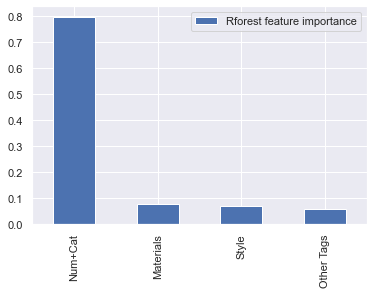

In [660]:
blended_model_rforest_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### 7c) Ensemble model in which the individual models are in a cascade rather than in parallel (as opposed to the blended models showed above)

In [661]:
#Build a custom predictor that takes as an argument two other predictors. 
#It should use the first to fit the raw data and the second to fit the residuals of the first.

In [662]:
class CascadePredictor(BaseEstimator, RegressorMixin):
    def __init__(self, Predictor1, Predictor2):
        # initialization code
        self.predictor1 = Predictor1
        self.predictor2 = Predictor2

    def fit(self, X, y):
        # fit the model:
        self.predictor1.fit(X, y)
        res = y - np.array(self.predictor1.predict(X))
        self.predictor2.fit(X, res)
        return self

    def predict(self, X):
        # make predictions 
        return np.array(self.predictor1.predict(X)) + np.array(self.predictor2.predict(X))

    #def score(self, X, y):
    #  # custom score implementation
    #  # this is optional, if not defined default is R^2
    #  return ...

#### Let's try the numerical+categorical random forest model followed by the style-tags based random forest model 

In [663]:
cascade_model_numcat_style = CascadePredictor(Predictor1=num_plus_cat_rforest_pipe_final,Predictor2=style_rforest_pipe_final)

In [664]:
#Train and possibly save the model.
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

cascade_model_numcat_style_filename = './Git_exclude/models/cascade_model_numcat_style.pickle'

#If the model file already exists, I load it:
try:
    with open(cascade_model_numcat_style_filename, 'rb') as f:
        cascade_model_numcat_style = load(f)
        print('Loaded pickle file with cascaded model of random forests for numerical+categorical variables, followed by style tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    cascade_model_numcat_style.fit(paintings_df_train,prices_train);
    
    with open(cascade_model_numcat_style_filename, 'wb') as f:
        dump(cascade_model_numcat_style, f, recurse=True) 
        print('Saved pickle file with cascaded model of random forests for numerical+categorical variables, followed by style tags.')

Loaded pickle file with cascaded model of random forests for numerical+categorical variables, followed by style tags.


In [665]:
cascade_model_numcat_style

CascadePredictor(Predictor1=None, Predictor2=None)

In [666]:
#Predict prices on training set:
prices_train_pred = cascade_model_numcat_style.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_numcat_style.score(paintings_df_train,prices_train)

0.3981438921843705

In [667]:
#Predict prices on test set:
prices_test_pred = cascade_model_numcat_style.predict(paintings_df_test)
#And return the R2 score as follows:
cascade_model_numcat_style.score(paintings_df_test,prices_test)

0.3566065856484454

In [668]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Cascaded model of random forests for numerical+categorical variables followed by style tags')


Cascaded model of random forests for numerical+categorical variables followed by style tags:
Training R^2: 0.3981438921843705
Testing R^2: 0.3566065856484454
Training RMSE: USD 109.20797645535895
Testing RMSE: USD 114.01709498918434
Training MAE: USD 83.69419098538505
Testing MAE: USD 86.90661665020967


In [669]:
#Does it do better than the numerical+categorical features alone?
print('Compare with Random Forests using numerical+categorical features alone:')
num_plus_cat_rforest_pipe_final.fit(paintings_df_train,prices_train);
print('Training R^2:')
print(num_plus_cat_rforest_pipe_final.score(paintings_df_train,prices_train))
print('Testing R^2:')
print(num_plus_cat_rforest_pipe_final.score(paintings_df_test,prices_test))

Compare with Random Forests using numerical+categorical features alone:
Training R^2:
0.3494771967719956
Testing R^2:
0.32915371080142575


#### Let's try the numerical+categorical random forest model followed by the materials-tags based random forest model 

In [670]:
cascade_model_numcat_materials = CascadePredictor(Predictor1=num_plus_cat_rforest_pipe_final,Predictor2=materials_rforest_w_tfidf_SVD_pipe_final)

In [671]:
#Train and possibly save the model.
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

cascade_model_numcat_materials_filename = './Git_exclude/models/cascade_model_numcat_materials.pickle'

#If the model file already exists, I load it:
try:
    with open(cascade_model_numcat_materials_filename, 'rb') as f:
        cascade_model_numcat_materials = load(f)
        print('Loaded pickle file with cascaded model of random forests for numerical+categorical variables, followed by materials tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    cascade_model_numcat_materials.fit(paintings_df_train,prices_train);
    
    with open(cascade_model_numcat_materials_filename, 'wb') as f:
        dump(cascade_model_numcat_materials, f, recurse=True) 
        print('Saved pickle file with cascaded model of random forests for numerical+categorical variables, followed by materials tags.')

Loaded pickle file with cascaded model of random forests for numerical+categorical variables, followed by materials tags.


In [672]:
cascade_model_numcat_materials

CascadePredictor(Predictor1=None, Predictor2=None)

In [673]:
#Predict prices on training set:
prices_train_pred = cascade_model_numcat_materials.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_numcat_materials.score(paintings_df_train,prices_train)

0.38985312588976595

In [674]:
#Predict prices on test set:
prices_test_pred = cascade_model_numcat_materials.predict(paintings_df_test)
#And return the R2 score as follows:
cascade_model_numcat_materials.score(paintings_df_test,prices_test)

0.3478510867715777

In [675]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Cascaded model of random forests for numerical+categorical variables followed by materials tags')


Cascaded model of random forests for numerical+categorical variables followed by materials tags:
Training R^2: 0.38985312588976595
Testing R^2: 0.3478510867715777
Training RMSE: USD 109.9575916746069
Testing RMSE: USD 114.79026364752326
Training MAE: USD 84.32451999189124
Testing MAE: USD 87.56150068682584


In [676]:
#So the results are very similar to the ones of the blended model, and in all cases the numerical+categorical features capture most of the
#variance (35%-37%) and then the style tags (and a bit less so the materials tags) capture another 2-3% of the variance

## 8) Nearest Neighbors Regression (mostly to find comparable paintings)

In [677]:
#I need to have all features in comparable scales (e.g. within 0 and 1)

In [678]:
#For the numerical variables, I just need to rescale using StandardScaler or MinMaxScaler,
#since the boolean and categorical variables are already within [0,1]

num_plus_cat_selector_with_scaling = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns) #('numerical',StandardScaler(),numerical_columns)
  ], remainder='drop')

num_plus_cat_scaling_pipe = Pipeline([('num and cat preproc', num_plus_cat_selector_with_scaling)])



In [679]:
#The style tags, since I am using a DictVectorizer without Tf-Idf and SVD reduction, are also already in the [0,1] range:

# #Recall that:

# pipe_style_tags_encoding = Pipeline([
#     ('to dict series',DictEncoder()),
#     ('to binary vectors',DictVectorizer())
# ])

# style_tranform = ColumnTransformer([
#     ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
# ], remainder='drop')


In [680]:
#The materials and general tags, instead, go through Tf-Idf and SVD dimensionality reduction, so they are not guaranteed to be within 0 and 1
#We just need to add a scaling (StandardScaler ot MinMaxScaler at the end)

# #Recall that for the materials tags:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# materials_tags_tranform = ColumnTransformer([
#     ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
# ], remainder='drop')


materials_tags_SVD_scaling_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('scaling', MinMaxScaler()) #('scaling',StandardScaler())
])


# #Recall that for general tags:

# pipe_tags_encoding_with_stopwords = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
# ], remainder='drop')

tags_SVD_scaling_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('scaling', MinMaxScaler()) #('scaling',StandardScaler())
])



In [681]:
#We can use a feature union to provide all the appropriately scaled variables to KNN:
all_scaled_features_union = FeatureUnion([
        ('num plus cat features', num_plus_cat_selector_with_scaling),
        ('style tags features', style_tranform),
        ('materials tags features',materials_tags_SVD_scaling_pipe),
        ('other tags features', tags_SVD_scaling_pipe),
    ])

In [682]:
#I can now pass this to a KNN-regressor (which will also compute nearest neighbors in the process):

from sklearn.neighbors import KNeighborsRegressor

knn_pipe = Pipeline([
    ('all scaled features', all_scaled_features_union),
    ('knn', KNeighborsRegressor(n_neighbors=5,n_jobs=2))
])

In [683]:
#I want to cross-validate the choice of number of neighbors that make sense:
from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': range(1, 22, 4)} 
knn_CVmodel = GridSearchCV(knn_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [684]:
#Train the model.
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

knn_CVmodel_filename = './Git_exclude/models/knn_CVmodel.pickle'

#If the model file already exists, I load it:
try:
    with open(knn_CVmodel_filename, 'rb') as f:
        knn_CVmodel = load(f)
        print('Loaded pickle file with cross-validated KNN regression using scaled tags, numerical+categorical variables.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    knn_CVmodel.fit(paintings_df_train,prices_train)
    
    with open(knn_CVmodel_filename, 'wb') as f:
        dump(knn_CVmodel, f, recurse=True) 
        print('Saved pickle file with cross-validated KNN regression using scaled tags, numerical+categorical variables.')

Loaded pickle file with cross-validated KNN regression using scaled tags, numerical+categorical variables.


In [685]:
knn_CVmodel.best_params_

{'knn__n_neighbors': 9}

In [686]:
knn_CVmodel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all scaled features',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'plus '
                                                                        'cat '
                                                                        'features',
                                                                        ColumnTransformer(transformers=[('categorical',
                                                                                                         OneHotEncoder(),
                                                                                                         ['painting_type',
                                                                                                          'when_made']),
                                                                                                        ('boolean',
                                                                                                         'passthrough',
                                                                                                         ['made_by_seller',
                                                                                                          'is_customizable',
                                                                                                          'has_variations']),
                                                                                                        ('numerical',
                                                                                                         MinMaxScaler(),
                                                                                                         ['num_favorers',
                                                                                                          'feature...
                                                                                                                                                                       'painted',
                                                                                                                                                                       'illustration',
                                                                                                                                                                       'picture',
                                                                                                                                                                       'drawing',
                                                                                                                                                                       'color',
                                                                                                                                                                       'colors',
                                                                                                                                                                       'colored',
                                                                                                                                                                       'colorful',
                                                                                                                                                                       'and',
                                                                                                                                                                       'on',
                                                                                                                                                                       'one',
                                                                        

In [687]:
# #This takes long to compute and it's not critical, so I commented it. Result was 0.33505 
# #Predict prices on training set:
# prices_train_pred = knn_CVmodel.predict(paintings_df_train)
# #And return the R2 score as follows:
knn_CVmodel.score(paintings_df_train,prices_train)

0.38343503980406823

In [688]:
# #This takes long to compute and it's not critical, so I commented it. Result was 0.23848 
# #Predict prices on test set:
# prices_test_pred = knn_CVmodel.predict(paintings_df_test)
# #And return the R2 score as follows:
knn_CVmodel.score(paintings_df_test,prices_test)

0.23791234255650284

In [689]:
# #Print results using the function defined earlier:

# print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='K nearest neighbors regression for all (scaled) tags, numerical+categorical variables')


In [690]:
#Let's see how to obtain the neighbors of a painting that is the real use of KNN in this project
paintings_df_test.iloc[0]

listing_id                                                             671254913
user_id                                                                 89682024
shop_id                                                                 14453345
title                          Red Apples - Still Life Oil Painting 14 x 11  ...
description                    Red Apples is an original still life Oil paint...
shop_section_id                                                       20899385.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/671254913/red-app...
num_favorers                                                                   0
is_customizable                                                            False
shipping_profile_id                                                36934670265.0
when_made                                                             made_2010s
has_variations              

In [691]:
#This is how you would check for the nearest neighbors of a test painting:
#1) Compute the features for that painting: (note that here I am computing features for the whole test set just to speed things up)
features_paintings_df_test = knn_CVmodel.best_estimator_['all scaled features'].transform(paintings_df_test)
features_paintings_df_test


<13711x177 sparse matrix of type '<class 'numpy.float64'>'
	with 1379656 stored elements in Compressed Sparse Row format>

In [692]:
features_paintings_df_test.shape

(13711, 177)

In [693]:
len(paintings_df_test)

13711

In [694]:
features_paintings_df_test.shape[0]

13711

In [695]:
#2) Pass the features to the 'kneighbors' method of the KNN regressor (note that reshape(1,-1) is needed by the method, if there is a single feature array):
num_neighbors_to_return = 10 
neigh_dist_test0, neigh_ind_test0 = knn_CVmodel.best_estimator_['knn'].kneighbors(features_paintings_df_test[0].reshape(1, -1),num_neighbors_to_return,return_distance=True)

In [696]:
neigh_dist_test0

array([[0.33188176, 0.54892741, 0.55244924, 0.55859509, 0.59743955,
        0.64567813, 0.6524378 , 0.65438991, 0.67976822, 0.68780504]])

In [697]:
neigh_ind_test0

array([[ 8253, 10172, 10579, 21733,  9958, 15746, 17946, 33332, 43134,
        22131]], dtype=int64)

In [698]:
#here are the details of the nearest neighbors:
paintings_df_train.iloc[neigh_ind_test0[0]]

listing_id    user_id   shop_id  \
20663   698287199   89682024  14453345   
40287   467341208    5681702   5262301   
1054    670517334  201894727  19562056   
26039   832016581  321525100  23811870   
9350    507802607   89682024  14453345   
53139   545584136   21092657   6868078   
618     593719795  102613330  14511026   
59875   805425405  286787624  22859943   
54876   629611886    9414042   5819608   
21529   829947467  321525100  23811870   

                                                   title  \
20663  Lunch - Still Life Oil Painting 12 x 12  on St...   
40287  Rose in Mason Ball Jar Amber Glass Oil Paintin...   
1054      Red Onion and Silver Cup original oil on panel   
26039  Colorful Carrots an Original Oil Painting by P...   
9350   Yellow Flower - Oil Painting on Panel by Janet...   
53139             Oni and Glass Frog still life painting   
618    Still life inspired by Bakhchisaray Palace, Cr...   
59875                                   Cups With Strips   
54876                        Black Bear in a Forest Fire   
21529  Pink Peony an Original Oil Painting by Pat Huf...   

                                             description  shop_section_id  \
20663  Lunch is an original still life Oil painting o...       20899385.0   
40287  12&quot; x 12&quot; Oil painting on stretched ...              NaN   
1054   Original Fine Art Oil Painting on Panel.  Sold...       25723995.0   
26039  Colorful Carrots is an original oil painting b...       29343841.0   
9350   This is an Original Oil Painting on Canvas Pan...       20913403.0   
53139  &quot;Oni and Glass Frog&quot; is an oil on pa...       11595929.0   
618    Crimea is home to the Bakhchisaray Palace, res...              NaN   
59875  Oil painting of fast food/disposable cups with...              NaN   
54876  This striking portrait of a black bear feature...        6937727.0   
21529  Pink Peony is an original oil painting by Pat ...       29343841.0   

       featured_rank                                                url  \
20663             -1  https://www.etsy.com/listing/698287199/lunch-s...   
40287             -1  https://www.etsy.com/listing/467341208/rose-in...   
1054              -1  https://www.etsy.com/listing/670517334/red-oni...   
26039             -1  https://www.etsy.com/listing/832016581/colorfu...   
9350              -1  https://www.etsy.com/listing/507802607/yellow-...   
53139              0  https://www.etsy.com/listing/545584136/oni-and...   
618               -1  https://www.etsy.com/listing/593719795/still-l...   
59875             -1  https://www.etsy.com/listing/805425405/cups-wi...   
54876             -1  https://www.etsy.com/listing/629611886/black-b...   
21529             -1  https://www.etsy.com/listing/829947467/pink-pe...   

       num_favorers  is_customizable  ...  max_dimension   area  aspect_ratio  \
20663             1            False  ...           14.0  196.0      1.000000   
40287             5            False  ...           15.0  195.0      1.153846   
1054              1            False  ...            9.0   63.0      1.285714   
26039             2            False  ...           12.0  120.0      1.200000   
9350              0            False  ...           12.0  120.0      1.200000   
53139             5            False  ...           20.0  320.0      1.250000   
618              32            False  ...           16.0  224.0      1.142857   
59875             0            False  ...           30.0  720.0      1.250000   
54876             8            False  ...           16.0  224.0      1.142857   
21529             0            False  ...           10.0  100.0      1.000000   

       weight  days_from_original_creation  made_by_seller  painting_type  \
20663   112.0                          993            True            oil   
40287    38.0                         1924            True            oil   
1054     16.0                         1045            True            oil   
26039    

In [699]:
paintings_df_train.iloc[neigh_ind_test0[0][0]]

listing_id                                                             698287199
user_id                                                                 89682024
shop_id                                                                 14453345
title                          Lunch - Still Life Oil Painting 12 x 12  on St...
description                    Lunch is an original still life Oil painting o...
shop_section_id                                                       20899385.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/698287199/lunch-s...
num_favorers                                                                   1
is_customizable                                                            False
shipping_profile_id                                                36934670265.0
when_made                                                             made_2010s
has_variations              

In [700]:
paintings_df_train.iloc[neigh_ind_test0[0][1]]

listing_id                                                             467341208
user_id                                                                  5681702
shop_id                                                                  5262301
title                          Rose in Mason Ball Jar Amber Glass Oil Paintin...
description                    12&quot; x 12&quot; Oil painting on stretched ...
shop_section_id                                                              NaN
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/467341208/rose-in...
num_favorers                                                                   5
is_customizable                                                            False
shipping_profile_id                                                12111905897.0
when_made                                                             made_2010s
has_variations              

In [701]:
#sanity check that a painting in the training set should find itself as the closest neighbor
features_paintings_df_train = knn_CVmodel.best_estimator_['all scaled features'].transform(paintings_df_train)
features_paintings_df_train

num_neighbors_to_return = 10 
neigh_dist_train0, neigh_ind_train0 = knn_CVmodel.best_estimator_['knn'].kneighbors(features_paintings_df_train[0].reshape(1, -1),num_neighbors_to_return,return_distance=True)

In [702]:
neigh_ind_train0

array([[    0,  2756,  1321, 47534, 41840, 43386, 32147,   782,  1354,
        44728]], dtype=int64)

In [703]:
neigh_dist_train0

array([[0.02387271, 1.93140397, 2.03665597, 2.17149955, 2.22152046,
        2.23860103, 2.2411734 , 2.26977616, 2.30545623, 2.33445302]])

In [704]:
#What if I pass all test paintings at once?
num_neighbors_to_return = 10 
neigh_dist_test, neigh_ind_test = knn_CVmodel.best_estimator_['knn'].kneighbors(features_paintings_df_test,num_neighbors_to_return,return_distance=True)

In [705]:
neigh_dist_test.shape

(13711, 10)

In [706]:
#each row returns the distance of the 10 closest neighbors, in increasing order, e.g.
neigh_dist_test[13]

array([0.33966823, 0.78890663, 0.93794484, 0.98528608, 0.98664003,
       0.99680783, 1.0066685 , 1.02884206, 1.0615874 , 1.08722682])

In [707]:
#hence this gives me the min distance between any test painting and the closest training set painting
neigh_dist_test[:,0]

array([0.33188176, 0.87184702, 0.19037671, ..., 0.01168015, 1.30940264,
       0.03001599])

In [708]:
#and this is the closest distance between any pair testing vs training paintings
np.min(neigh_dist_test[:,0])

0.0004267632960856954

In [709]:
#How come it's so small? Are there duplicate paintings in test vs train set?
#No, but there may be paintings that are identical in terms of all dimensions and tags because they are made by the same person and done in a series
#That is expected and acceptable since I don't use image data at this point, but I shouldn't show examples like this in the demo as it's a bit of an edge case.
#In general, when assessing a new painting there's not going to be already one in the training set that's very close to it. 

In [710]:
test_painting_closest_to_train = np.argmin(neigh_dist_test[:,0])

In [711]:
paintings_df_test.iloc[test_painting_closest_to_train]

listing_id                                                             977740110
user_id                                                                153554096
shop_id                                                                 22641107
title                                                                Yellow Bird
description                    This nod to a Twisbian technique of allowing c...
shop_section_id                                                              NaN
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/977740110/yellow-...
num_favorers                                                                   0
is_customizable                                                            False
shipping_profile_id                                               103931955207.0
when_made                                                             made_2020s
has_variations              

In [712]:
#its closest neighbor is:
train_painting_closest_to_test = neigh_ind_test[test_painting_closest_to_train][0]
train_painting_closest_to_test

33268

In [713]:
paintings_df_train.iloc[train_painting_closest_to_test]

listing_id                                                             977750068
user_id                                                                153554096
shop_id                                                                 22641107
title                                                          It&#39;s a Flower
description                    The straightforward simplicity successfully re...
shop_section_id                                                              NaN
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/977750068/its-a-f...
num_favorers                                                                   0
is_customizable                                                            False
shipping_profile_id                                               103931955207.0
when_made                                                             made_2020s
has_variations              

In [714]:
#Before moving on to the display of results, let's save the precomputed nearest neighbors of each test painting for the demo since those are usually slow to compute in real time

In [715]:
#Note: min_price is already defined at the beginning of the file (either 100.0 for the larger dataset, or 250,0 for the smaller set)

nearest_neighbors_indices_paintings_test_filename = f'./Git_exclude/models/nearestneighbors_paintings_from_USD{int(min_price)}_test.pickle'

#If the file already exists, I load it:
try:
    with open(nearest_neighbors_indices_paintings_test_filename, 'rb') as f:
        neigh_ind_test = load(f)
        print(f'Loaded pickle file {nearest_neighbors_indices_paintings_test_filename} with indices for 10 nearest neighbors for all paintings USD{int(min_price)} and up used for testing the initial models.')
except FileNotFoundError: #if not, actually save the indices for next time:
    with open(nearest_neighbors_indices_paintings_test_filename, 'wb') as f:
        dump(neigh_ind_test, f, recurse=True) 
        print(f'Saved pickle file {nearest_neighbors_indices_paintings_test_filename} with indices for 10 nearest neighbors for all paintings USD{int(min_price)} and up used for testing the initial models.')

Loaded pickle file ./Git_exclude/models/nearestneighbors_paintings_from_USD100_test.pickle with indices for 10 nearest neighbors for all paintings USD100 and up used for testing the initial models.


In [716]:
#Also save the paintings_df_train and paintings_df_test dataframes for the demo

In [717]:
from dill import dump, load

paintings_df_train_filename = f'./Git_exclude/models/paintings_from_USD{int(min_price)}_df_train.pickle'

#If the file already exists, I load it:
try:
    with open(paintings_df_train_filename, 'rb') as f:
        paintings_df_train = load(f)
        print(f'Loaded pickle file {paintings_df_train_filename} with dataframe of paintings USD{int(min_price)} and up used for training the initial models.')
except FileNotFoundError: #if not, actually save the model for next time:
    with open(paintings_df_train_filename, 'wb') as f:
        dump(paintings_df_train, f, recurse=True) 
        print(f'Saved pickle file {paintings_df_train_filename} with dataframe of paintings USD{int(min_price)} and up used for training the initial models.')

Loaded pickle file ./Git_exclude/models/paintings_from_USD100_df_train.pickle with dataframe of paintings USD100 and up used for training the initial models.


In [718]:
paintings_df_test_filename = f'./Git_exclude/models/paintings_from_USD{int(min_price)}_df_test.pickle'

#If the file already exists, I load it:
try:
    with open(paintings_df_test_filename, 'rb') as f:
        paintings_df_test = load(f)
        print(f'Loaded pickle file {paintings_df_test_filename} with dataframe of paintings USD{int(min_price)} and up used for testing the initial models.')
except FileNotFoundError: #if not, actually save the model for next time:
    with open(paintings_df_test_filename, 'wb') as f:
        dump(paintings_df_test, f, recurse=True) 
        print(f'Saved pickle file {paintings_df_test_filename} with dataframe of paintings USD{int(min_price)} and up used for testing the initial models.')

Loaded pickle file ./Git_exclude/models/paintings_from_USD100_df_test.pickle with dataframe of paintings USD100 and up used for testing the initial models.


## 9) Other models computed combining all (scaled and dimensionality-reduced) features at once (like KNN regressor)

In [719]:
# #Recall we already have a feature union that provides all the appropriately scaled variables (from the KNN model):
# all_scaled_features_union = FeatureUnion([
#         ('num plus cat features', num_plus_cat_selector_with_scaling),
#         ('style tags features', style_tranform),
#         ('materials tags features',materials_tags_SVD_scaling_pipe),
#         ('other tags features', tags_SVD_scaling_pipe),
#     ])

### 9a) Ridge Regression using all features

In [720]:
#I can now pass this to a Ridge Regression model, which is usually good at handling many features:

ridge_pipe_allfeatures = Pipeline([
    ('all scaled features', all_scaled_features_union),
    ('ridge', Ridge(alpha=10))
])

In [721]:
#I want to cross-validate the choice of max depth and num estimators that make sense:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(-2, 2, 10)} 
ridge_CVmodel_allfeatures = GridSearchCV(ridge_pipe_allfeatures, param_grid, cv=5, n_jobs=2, verbose=1)

In [722]:
#Train the model.
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

ridge_CVmodel_allfeatures_filename = './Git_exclude/models/ridge_CVmodel_allfeatures.pickle'

#If the model file already exists, I load it:
try:
    with open(ridge_CVmodel_allfeatures_filename, 'rb') as f:
        ridge_CVmodel_allfeatures = load(f)
        print('Loaded pickle file with cross-validated Ridge regression using all scaled tags, numerical+categorical variables.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    ridge_CVmodel_allfeatures.fit(paintings_df_train,prices_train)
    
    with open(ridge_CVmodel_allfeatures_filename, 'wb') as f:
        dump(ridge_CVmodel_allfeatures, f, recurse=True) 
        print('Saved pickle file with cross-validated Ridge regression using all scaled tags, numerical+categorical variables.')

Loaded pickle file with cross-validated Ridge regression using all scaled tags, numerical+categorical variables.


In [723]:
ridge_CVmodel_allfeatures.best_params_

{'ridge__alpha': 0.0774263682681127}

In [724]:
ridge_CVmodel_allfeatures

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all scaled features',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'plus '
                                                                        'cat '
                                                                        'features',
                                                                        ColumnTransformer(transformers=[('categorical',
                                                                                                         OneHotEncoder(),
                                                                                                         ['painting_type',
                                                                                                          'when_made']),
                                                                                                        ('boolean',
                                                                                                         'passthrough',
                                                                                                         ['made_by_seller',
                                                                                                          'is_customizable',
                                                                                                          'has_variations']),
                                                                                                        ('numerical',
                                                                                                         MinMaxScaler(),
                                                                                                         ['num_favorers',
                                                                                                          'feature...
                                                                                                                                                                       'at',
                                                                                                                                                                       'with',
                                                                                                                                                                       'by',
                                                                                                                                                                       'fi', ...]))]),
                                                                                                                          'tags_new')])),
                                                                                        ('SVD',
                                                                                         TruncatedSVD(n_components=50)),
                                                                                        ('scaling',
                                                                                         MinMaxScaler())]))])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             verbose=1)

In [725]:
#Predict prices on training set:
prices_train_pred = ridge_CVmodel_allfeatures.predict(paintings_df_train)
#And return the R2 score as follows:
ridge_CVmodel_allfeatures.score(paintings_df_train,prices_train)

0.24373341147857097

In [726]:
#Predict prices on test set:
prices_test_pred = ridge_CVmodel_allfeatures.predict(paintings_df_test)
#And return the R2 score as follows:
ridge_CVmodel_allfeatures.score(paintings_df_test,prices_test)

0.2524865119361074

In [727]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression using all (scaled) tags, numerical+categorical variables')


Ridge regression using all (scaled) tags, numerical+categorical variables:
Training R^2: 0.24373341147857097
Testing R^2: 0.2524865119361074
Training RMSE: USD 122.41805663035935
Testing RMSE: USD 122.89697199834897
Training MAE: USD 94.96230647419405
Testing MAE: USD 95.01184049402566


In [728]:
#This underperforms the ensemble model, so it's not that useful.
#May still be interesting to visualize the relative weight given to different features.

In [729]:
#We first need to dig out the names of all features and in the right order in which they are used within the model:

In [730]:
# #The order is:
#('num plus cat features', num_plus_cat_selector_with_scaling),
#         ('style tags features', style_tranform),
#         ('materials tags features',materials_tags_SVD_scaling_pipe),
#         ('other tags features', tags_SVD_scaling_pipe),

In [731]:
# #We can pull the numerical and categorical feature names from:
#feature_names_num_plus_cat_dtree = num_plus_cat_dtree_CVmodel.best_estimator_['num and cat selector'].get_feature_names()
feature_names_num_plus_cat_dtree

['categorical__x0_acrylic',
 'categorical__x0_more_than_one',
 'categorical__x0_oil',
 'categorical__x0_watercolor',
 'categorical__x1_made_2010s',
 'categorical__x1_made_2020s',
 'categorical__x1_made_before_2010',
 'categorical__x1_made_to_order',
 'made_by_seller',
 'is_customizable',
 'has_variations',
 'num_favorers',
 'featured_rank',
 'max_dimension',
 'aspect_ratio',
 'area',
 'weight',
 'days_from_original_creation']

In [732]:
# #The style tags can be pulled from:
#feature_names_style_dtree = style_dtree_CVmodel.best_estimator_['style tags vectorization'].named_transformers_['style tags vectorizer']['to binary vectors'].get_feature_names()
feature_names_style_dtree

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

In [733]:
# #The materials tags topic numbers and corresponding features can be pulled from:

#materials_feature_names = materials_rforest_w_tfidf_SVD_pipe['materials tfidf vectorization'].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()

# list_of_materials_topics = []
# list_of_materials_topic_num_names = []

# for index, component in enumerate(materials_rforest_w_tfidf_SVD_pipe['SVD'].components_):
#     zipped = zip(materials_feature_names, component)
#     top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
#     top_terms_list=list(dict(top_terms_key).keys())
#     top_comp_list=list(dict(top_terms_key).values())
#     topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
#     list_of_materials_topics.append(topic_materials_components)
#     list_of_materials_topic_num_names.append("Materials topic "+str(index))
#     #print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

list_of_materials_topic_num_names[:10]

['Materials topic 0',
 'Materials topic 1',
 'Materials topic 2',
 'Materials topic 3',
 'Materials topic 4',
 'Materials topic 5',
 'Materials topic 6',
 'Materials topic 7',
 'Materials topic 8',
 'Materials topic 9']

In [734]:
list_of_materials_topics

[['stretched canvas(0.5)', 'canvas(0.49)', 'stretched(0.48)'],
 ['oil(0.58)', 'oil canvas(0.49)', 'stretched canvas(-0.45)'],
 ['paper(0.65)', 'watercolor(0.55)', 'paper watercolor(0.47)'],
 ['acrylic(0.68)', 'acrylic canvas(0.52)', 'stretched canvas(-0.31)'],
 ['canvas board(0.58)', 'board(0.56)', 'wood(-0.24)'],
 ['wood(0.49)', 'hardboard wood(0.48)', 'hardboard(0.47)'],
 ['blue(0.52)', 'blue canvas(0.47)', 'canvas stretched(0.31)'],
 ['paper(0.64)', 'watercolor(-0.61)', 'acrylic canvas(-0.26)'],
 ['acrylic stretched(0.55)', 'acrylic canvas(-0.52)', 'acrylic(0.36)'],
 ['framed(0.5)', 'framed canvas(0.38)', 'oil framed(0.38)'],
 ['stretched oil(0.6)', 'oil(-0.42)', 'framed(0.3)'],
 ['fine(0.57)', 'canvas fine(0.34)', 'black(0.25)'],
 ['fine(0.55)', 'canvas fine(0.39)', 'black(-0.32)'],
 ['acrylic stretched(-0.66)', 'acrylic paper(0.37)', 'acrylic(0.32)'],
 ['hand(0.38)', 'painted(0.33)', 'canvas stretched(-0.32)'],
 ['oil canvas(-0.4)', 'oil(0.31)', 'black(0.31)'],
 ['hand(0.36)', 'oi

In [735]:
# #The (generic) tags topic numbers and corresponding features can be pulled from:

# #tags_feature_names = tags_rforest_w_tfidf_SVD_pipe['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

# list_of_tags_topics = []
# list_of_tags_topic_num_names = []

# for index, component in enumerate(tags_rforest_w_tfidf_SVD_pipe['SVD'].components_):
#     zipped = zip(tags_feature_names, component)
#     top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
#     top_terms_list=list(dict(top_terms_key).keys())
#     top_comp_list=list(dict(top_terms_key).values())
#     topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
#     list_of_tags_topics.append(topic_tags_components)
#     list_of_tags_topic_num_names.append("Tags topic "+str(index))
#     #print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

list_of_tags_topic_num_names[:10]

['Tags topic 0',
 'Tags topic 1',
 'Tags topic 2',
 'Tags topic 3',
 'Tags topic 4',
 'Tags topic 5',
 'Tags topic 6',
 'Tags topic 7',
 'Tags topic 8',
 'Tags topic 9']

In [736]:
list_of_tags_topics

[['flowers(0.37)', 'nature(0.28)', 'flower(0.27)'],
 ['pour(0.43)', 'fluid(0.37)', 'ocean(0.36)'],
 ['pour(0.5)', 'fluid(0.44)', 'ocean(-0.28)'],
 ['pet(0.53)', 'dog(0.45)', 'animal(0.31)'],
 ['ocean(0.46)', 'nature(-0.34)', 'trees(-0.28)'],
 ['life(0.42)', 'pink(-0.4)', 'still(0.39)'],
 ['woman(0.66)', 'signed(0.27)', 'nature(-0.24)'],
 ['signed(0.51)', 'flowers(0.32)', 'life(-0.26)'],
 ['pink(0.64)', 'woman(-0.41)', 'signed(0.28)'],
 ['office(0.43)', 'living(0.39)', 'pink(-0.32)'],
 ['nature(0.56)', 'flowers(-0.35)', 'trees(-0.33)'],
 ['flower(0.58)', 'flowers(-0.49)', 'antique(0.44)'],
 ['textured(0.5)', 'orange(0.38)', 'house(-0.31)'],
 ['antique(-0.54)', 'air(0.4)', 'plein(0.38)'],
 ['kind(0.79)', 'textured(-0.36)', 'flower(0.22)'],
 ['textured(0.63)', 'orange(-0.6)', 'bright(-0.26)'],
 ['house(-0.54)', 'living(0.44)', 'office(0.33)'],
 ['antique(0.52)', 'air(0.43)', 'signed(-0.42)'],
 ['bright(0.54)', 'orange(-0.53)', 'geometric(0.46)'],
 ['square(0.81)', 'bright(-0.41)', 'sunset

In [737]:
all_feature_names = feature_names_num_plus_cat_dtree  + feature_names_style_dtree + list_of_materials_topic_num_names + list_of_tags_topic_num_names
len(all_feature_names)

177

In [738]:
#Which are the largest regression coefficients in the regression model?

tags_ridge_all_features_coeff_df = pd.DataFrame(ridge_CVmodel_allfeatures.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
tags_ridge_all_features_coeff_df['Feature']=pd.Series(all_feature_names)
tags_ridge_all_features_coeff_df = tags_ridge_all_features_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_all_features_coeff_df.iloc[:10]

Regression coefficients          Feature
16              1649.160336           weight
15               334.689780             area
13               246.107304    max_dimension
71               153.835129           rocker
60               151.208740     neoclassical
12               144.320807    featured_rank
34               133.793062      cовременный
14               126.703251     aspect_ratio
86               122.178995     традиционный
85                74.533329  неоклассический

In [739]:
tags_ridge_all_features_coeff_df.iloc[-10:]

Regression coefficients             Feature
27                -43.404524           burlesque
119               -44.391466  Materials topic 32
39                -44.565389             fashion
73                -45.245136                 sci
53                -50.033341       mediterranean
130               -50.138534        Tags topic 3
89                -51.208158   Materials topic 2
128               -68.265895        Tags topic 1
11               -100.644028        num_favorers
129              -104.293462        Tags topic 2

In [740]:
#The regression coefficients don't seem to make much sense

### 9b) Random Forest Regression using all features

In [741]:
#Let's try with a Random Forest, since that was a model that worked well with each individual set of features
rforest_pipe_allfeatures = Pipeline([
    ('all scaled features', all_scaled_features_union),
    ('rforest', RandomForestRegressor(n_estimators=200,max_features='sqrt',n_jobs=2,max_depth=7,random_state=1,max_samples=0.8,min_samples_leaf=10))
])

In [742]:
#I want to cross-validate the choice of max depth and num estimators that make sense:
from sklearn.model_selection import GridSearchCV

param_grid = {'rforest__max_depth': range(5, 37, 3), 'rforest__n_estimators': range(100,410,100)} 
rforest_CVmodel_allfeatures = GridSearchCV(rforest_pipe_allfeatures, param_grid, cv=5, n_jobs=2, verbose=1)

In [743]:
#Train the model.
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

rforest_CVmodel_allfeatures_filename = './Git_exclude/models/rforest_CVmodel_allfeatures.pickle'

#If the model file already exists, I load it:
try:
    with open(rforest_CVmodel_allfeatures_filename, 'rb') as f:
        rforest_CVmodel_allfeatures = load(f)
        print('Loaded pickle file with cross-validated Random Forests regression using all scaled tags, numerical+categorical variables.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    rforest_CVmodel_allfeatures.fit(paintings_df_train,prices_train)
    
    with open(rforest_CVmodel_allfeatures_filename, 'wb') as f:
        dump(rforest_CVmodel_allfeatures, f, recurse=True) 
        print('Saved pickle file with cross-validated Random Forests regression using all scaled tags, numerical+categorical variables.')

Loaded pickle file with cross-validated Random Forests regression using all scaled tags, numerical+categorical variables.


In [744]:
rforest_CVmodel_allfeatures.best_params_

{'rforest__max_depth': 32, 'rforest__n_estimators': 400}

In [745]:
rforest_CVmodel_allfeatures

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all scaled features',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'plus '
                                                                        'cat '
                                                                        'features',
                                                                        ColumnTransformer(transformers=[('categorical',
                                                                                                         OneHotEncoder(),
                                                                                                         ['painting_type',
                                                                                                          'when_made']),
                                                                                                        ('boolean',
                                                                                                         'passthrough',
                                                                                                         ['made_by_seller',
                                                                                                          'is_customizable',
                                                                                                          'has_variations']),
                                                                                                        ('numerical',
                                                                                                         MinMaxScaler(),
                                                                                                         ['num_favorers',
                                                                                                          'feature...
                                                                                                                                                                       'fi', ...]))]),
                                                                                                                          'tags_new')])),
                                                                                        ('SVD',
                                                                                         TruncatedSVD(n_components=50)),
                                                                                        ('scaling',
                                                                                         MinMaxScaler())]))])),
                                       ('rforest',
                                        RandomForestRegressor(max_depth=7,
                                                              max_features='sqrt',
                                                              max_samples=0.8,
                                                              min_samples_leaf=10,
                                                              n_estimators=200,
                                                              n_jobs=2,
                                                              random_state=1))]),
             n_jobs=2,
             param_grid={'rforest__max_depth': range(5, 42, 3),
                         'rforest__n_estimators': range(100, 410, 100)},
             verbose=1)

In [746]:
#Predict prices on training set:
prices_train_pred = rforest_CVmodel_allfeatures.predict(paintings_df_train)
#And return the R2 score as follows:
rforest_CVmodel_allfeatures.score(paintings_df_train,prices_train)

0.5427674077467806

In [747]:
#Predict prices on test set:
prices_test_pred = rforest_CVmodel_allfeatures.predict(paintings_df_test)
#And return the R2 score as follows:
rforest_CVmodel_allfeatures.score(paintings_df_test,prices_test)

0.3751740628330512

In [748]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forests regression using all (scaled) tags, numerical+categorical variables')


Random Forests regression using all (scaled) tags, numerical+categorical variables:
Training R^2: 0.5427674077467806
Testing R^2: 0.3751740628330511
Training RMSE: USD 95.18677523316506
Testing RMSE: USD 112.35986029640115
Training MAE: USD 72.31239219919777
Testing MAE: USD 85.64704688587054


In [749]:
# This model appears to overfit the training data, and its improvement compared to the blended model is still minimal, so the blended model remains preferable.
# One thing it may be useful is to visualize the feature importance across all feature types

In [750]:
rforest_all_features_imp_df = pd.DataFrame(rforest_CVmodel_allfeatures.best_estimator_['rforest'].feature_importances_,columns=['Rforest feature importance'])
rforest_all_features_imp_df['Topic']=pd.Series(all_feature_names)
rforest_all_features_imp_df = rforest_all_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
rforest_all_features_imp_df.iloc[:20]

Rforest feature importance                        Topic
15                     0.104913                         area
13                     0.100326                max_dimension
16                     0.070723                       weight
14                     0.020128                 aspect_ratio
89                     0.017163            Materials topic 2
17                     0.014942  days_from_original_creation
2                      0.013560          categorical__x0_oil
88                     0.013001            Materials topic 1
132                    0.010941                 Tags topic 5
129                    0.010634                 Tags topic 2
133                    0.009783                 Tags topic 6
134                    0.009681                 Tags topic 7
97                     0.009545           Materials topic 10
144                    0.009339                Tags topic 17
130                    0.008745                 Tags topic 3
128                    0.008500                 Tags topic 1
87                     0.008464            Materials topic 0
135                    0.007975                 Tags topic 8
157                    0.007881                Tags topic 30
171                    0.007501                Tags topic 44

In [751]:
#For some reason, none of the style topics made it into the top-20 of most important features.. but again this model overfits the data so I find
#the conclusions of the blended model more reliable

### 9c) Gradient Boosted Trees regression using all features

In [752]:
from sklearn.ensemble import GradientBoostingRegressor

In [753]:
#Let's try with a Random Forest, since that was a model that worked well with each individual set of features
gboost_pipe_allfeatures = Pipeline([
    ('all scaled features', all_scaled_features_union),
    ('gboost', GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,subsample=0.5,max_depth=7,random_state=1,max_features='sqrt',min_samples_leaf=10))
])

In [754]:
#I want to cross-validate the choice of max depth and num estimators that make sense:
from sklearn.model_selection import GridSearchCV

param_grid = {'gboost__max_depth': range(5, 33, 3), 'gboost__n_estimators': range(100,310,100)} 
gboost_CVmodel_allfeatures = GridSearchCV(gboost_pipe_allfeatures, param_grid, cv=5, n_jobs=2, verbose=1)

In [755]:
#Train the model.
#I will save the model after fitting the model the first time, then I will load it from memory the following times
from dill import dump, load

gboost_CVmodel_allfeatures_filename = './Git_exclude/models/gboost_CVmodel_allfeatures.pickle'

#If the model file already exists, I load it:
try:
    with open(gboost_CVmodel_allfeatures_filename, 'rb') as f:
        gboost_CVmodel_allfeatures = load(f)
        print('Loaded pickle file with cross-validated Gradient Boosted Trees regression using all scaled tags, numerical+categorical variables.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    gboost_CVmodel_allfeatures.fit(paintings_df_train,prices_train)
    
    with open(gboost_CVmodel_allfeatures_filename, 'wb') as f:
        dump(gboost_CVmodel_allfeatures, f, recurse=True) 
        print('Saved pickle file with cross-validated Gradient Boosted Trees regression using all scaled tags, numerical+categorical variables.')

Loaded pickle file with cross-validated Gradient Boosted Trees regression using all scaled tags, numerical+categorical variables.


In [756]:
gboost_CVmodel_allfeatures.best_params_

{'gboost__max_depth': 14, 'gboost__n_estimators': 200}

In [757]:
gboost_CVmodel_allfeatures

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all scaled features',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'plus '
                                                                        'cat '
                                                                        'features',
                                                                        ColumnTransformer(transformers=[('categorical',
                                                                                                         OneHotEncoder(),
                                                                                                         ['painting_type',
                                                                                                          'when_made']),
                                                                                                        ('boolean',
                                                                                                         'passthrough',
                                                                                                         ['made_by_seller',
                                                                                                          'is_customizable',
                                                                                                          'has_variations']),
                                                                                                        ('numerical',
                                                                                                         MinMaxScaler(),
                                                                                                         ['num_favorers',
                                                                                                          'feature...
                                                                                                                                                                       'by',
                                                                                                                                                                       'fi', ...]))]),
                                                                                                                          'tags_new')])),
                                                                                        ('SVD',
                                                                                         TruncatedSVD(n_components=50)),
                                                                                        ('scaling',
                                                                                         MinMaxScaler())]))])),
                                       ('gboost',
                                        GradientBoostingRegressor(max_depth=7,
                                                                  max_features='sqrt',
                                                                  min_samples_leaf=10,
                                                                  n_estimators=200,
                                                                  random_state=1,
                                                                  subsample=0.5))]),
             n_jobs=2,
             param_grid={'gboost__max_depth': range(5, 42, 3),
                         'gboost__n_estimators': range(100, 410, 100)},
             verbose=1)

In [758]:
#Predict prices on training set:
prices_train_pred = gboost_CVmodel_allfeatures.predict(paintings_df_train)
#And return the R2 score as follows:
gboost_CVmodel_allfeatures.score(paintings_df_train,prices_train)

0.8497254729471693

In [759]:
#Predict prices on test set:
prices_test_pred = gboost_CVmodel_allfeatures.predict(paintings_df_test)
#And return the R2 score as follows:
gboost_CVmodel_allfeatures.score(paintings_df_test,prices_test)

0.41952722662019637

In [760]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosted Trees regression using all (scaled) tags, numerical+categorical variables')


Gradient Boosted Trees regression using all (scaled) tags, numerical+categorical variables:
Training R^2: 0.8497254729471693
Testing R^2: 0.41952722662019637
Training RMSE: USD 54.569592264007255
Testing RMSE: USD 108.298537816355
Training MAE: USD 39.161163799525404
Testing MAE: USD 79.36643071797126


In [761]:
# This model appears to overfit the training data, and its improvement compared to the blended model is still minimal, so the blended model remains preferable.
# One thing it may be useful is to visualize the feature importance across all feature types

In [762]:
gboost_all_features_imp_df = pd.DataFrame(gboost_CVmodel_allfeatures.best_estimator_['gboost'].feature_importances_,columns=['Gboost feature importance'])
gboost_all_features_imp_df['Topic']=pd.Series(all_feature_names)
gboost_all_features_imp_df = gboost_all_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
gboost_all_features_imp_df.iloc[:20]

Gboost feature importance                        Topic
15                    0.058673                         area
13                    0.046065                max_dimension
16                    0.041767                       weight
17                    0.019137  days_from_original_creation
14                    0.015795                 aspect_ratio
87                    0.011449            Materials topic 0
133                   0.011305                 Tags topic 6
89                    0.011281            Materials topic 2
127                   0.010979                 Tags topic 0
88                    0.010900            Materials topic 1
144                   0.010545                Tags topic 17
130                   0.010378                 Tags topic 3
140                   0.010048                Tags topic 13
129                   0.010016                 Tags topic 2
132                   0.009983                 Tags topic 5
134                   0.009918                 Tags topic 7
161                   0.009630                Tags topic 34
163                   0.009535                Tags topic 36
141                   0.009530                Tags topic 14
97                    0.009467           Materials topic 10

In [763]:
#For some reason, none of the style topics made it into the top-20 of most important features.. but again this model overfits the data so I find
#the conclusions of the blended model more reliable

## 10) Analysis of performance of the best ML model (the ensemble one combining the 4 Random Forest individual models with a linear regression)

In [764]:
#Load the saved model:

from dill import dump, load

blended_model_rforest_linear_filename = './Git_exclude/models/blended_model_rforest_linear.pickle'

#If the model file already exists, I load it:
with open(blended_model_rforest_linear_filename, 'rb') as f:
    blended_model_rforest_linear = load(f)
    print('Loaded pickle file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded pickle file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.


In [765]:
predictions_all_test_set = blended_model_rforest_linear.predict(paintings_df_test)

In [766]:
len(predictions_all_test_set)

13711

In [767]:
np.median(predictions_all_test_set)

228.05142564607308

In [768]:
np.median(paintings_df_test['price'])

193.0

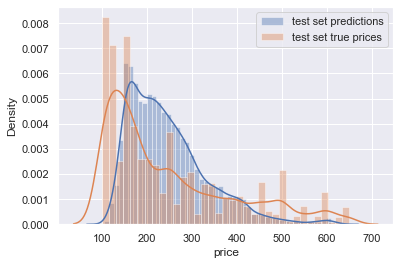

In [769]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.distplot(predictions_all_test_set,label='test set predictions')
sns.distplot(paintings_df_test['price'],label='test set true prices')
plt.legend();
plt.savefig('./Git_exclude/Figures/price_distributions_true_vs_pred_test.png')

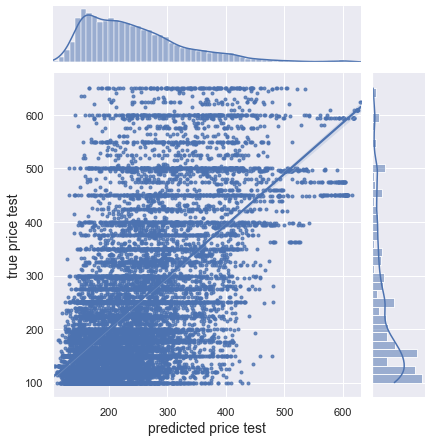

In [770]:
p = sns.jointplot(predictions_all_test_set,paintings_df_test['price'],kind='reg',marker='.');
p.set_axis_labels('predicted price test', 'true price test', fontsize=14);

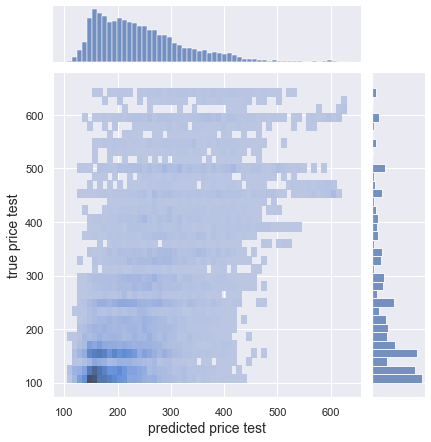

In [771]:
p = sns.jointplot(predictions_all_test_set,paintings_df_test['price'],kind='hist');
p.set_axis_labels('predicted price test', 'true price test', fontsize=14);
plt.savefig('./Git_exclude/Figures/scatter_plot_price_true_vs_pred_test.png')

In [772]:
#Let's check on the training set:
predictions_all_train_set = blended_model_rforest_linear.predict(paintings_df_train)

In [773]:
len(predictions_all_train_set)

54843

In [774]:
np.median(predictions_all_train_set)

228.99346719474784

In [775]:
np.median(paintings_df_train['price'])

195.0

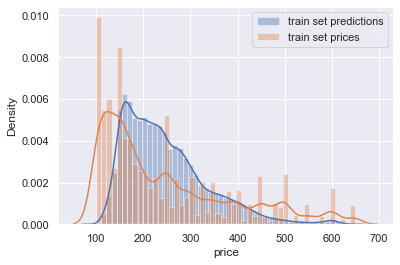

In [776]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.distplot(predictions_all_train_set,label='train set predictions')
sns.distplot(paintings_df_train['price'],label='train set prices')
plt.legend();
plt.savefig('./Git_exclude/Figures/price_distributions_true_vs_pred_train.png')

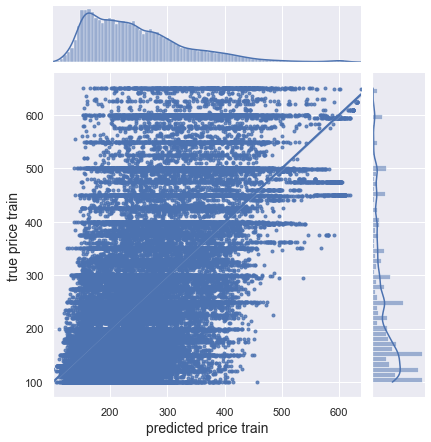

In [777]:
p = sns.jointplot(predictions_all_train_set,paintings_df_train['price'],kind='reg',marker='.');
p.set_axis_labels('predicted price train', 'true price train', fontsize=14);

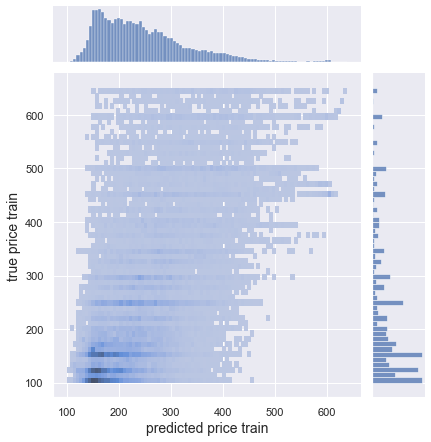

In [778]:
p = sns.jointplot(predictions_all_train_set,paintings_df_train['price'],kind='hist');
p.set_axis_labels('predicted price train', 'true price train', fontsize=14);
plt.savefig('./Git_exclude/Figures/scatter_plot_price_true_vs_pred_train.png')

In [779]:
#How does the model perform on predicting prices within the 3 main price ranges (say 100-250, 250-450, 450-650):

In [780]:
sorted_indices_predictions_test = np.argsort(predictions_all_test_set)

In [781]:
predictions_all_test_set[sorted_indices_predictions_test]

array([105.17839085, 107.0129173 , 107.62812286, ..., 624.92745258,
       629.44875638, 630.53920515])

In [782]:
num_pred_below_USD250_test = np.where(predictions_all_test_set[sorted_indices_predictions_test]<250)[0][-1]
num_pred_below_USD250_test

8211

In [783]:
idx_predictions_below_USD250_test = sorted_indices_predictions_test[:num_pred_below_USD250_test]
len(idx_predictions_below_USD250_test)

8211

In [784]:
num_pred_above_USD450_test = len(sorted_indices_predictions_test) - np.where(predictions_all_test_set[sorted_indices_predictions_test]>450)[0][0]
num_pred_above_USD450_test

404

In [785]:
idx_predictions_above_USD450_test = sorted_indices_predictions_test[-num_pred_above_USD450_test:]
len(idx_predictions_above_USD450_test)

404

In [786]:
idx_predictions_between_USD250_and_USD450_test = sorted_indices_predictions_test[num_pred_below_USD250_test:-num_pred_above_USD450_test:]
len(idx_predictions_between_USD250_and_USD450_test)

5096

In [787]:
len(predictions_all_test_set)

13711

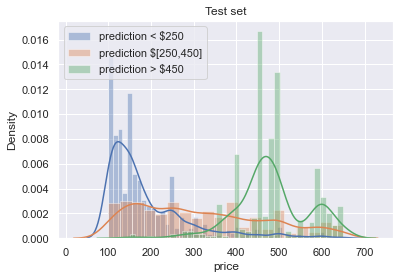

In [788]:
sns.distplot(paintings_df_test['price'].iloc[idx_predictions_below_USD250_test],label='prediction < $250')
sns.distplot(paintings_df_test['price'].iloc[idx_predictions_between_USD250_and_USD450_test],label='prediction $[250,450]')
sns.distplot(paintings_df_test['price'].iloc[idx_predictions_above_USD450_test],label='prediction > $450')
plt.legend();
plt.title('Test set');
plt.savefig('./Git_exclude/Figures/price_distributions_true_vs_pred_test_by_price_range.png')

In [789]:
sorted_indices_predictions_train = np.argsort(predictions_all_train_set)

In [790]:
predictions_all_train_set[sorted_indices_predictions_train]

array([100.47318874, 105.26869618, 106.34110877, ..., 630.53920515,
       630.53920515, 638.17763673])

In [791]:
num_pred_below_USD250_train = np.where(predictions_all_train_set[sorted_indices_predictions_train]<250)[0][-1]
num_pred_below_USD250_train

32740

In [792]:
idx_predictions_below_USD250_train = sorted_indices_predictions_train[:num_pred_below_USD250_test]
len(idx_predictions_below_USD250_train)

8211

In [793]:
num_pred_above_USD450_train = len(sorted_indices_predictions_train) - np.where(predictions_all_train_set[sorted_indices_predictions_train]>450)[0][0]
num_pred_above_USD450_train

1610

In [794]:
idx_predictions_above_USD450_train = sorted_indices_predictions_train[-num_pred_above_USD450_train:]
len(idx_predictions_above_USD450_train)

1610

In [795]:
idx_predictions_between_USD250_and_USD450_train = sorted_indices_predictions_train[num_pred_below_USD250_train:-num_pred_above_USD450_train:]
len(idx_predictions_between_USD250_and_USD450_train)

20493

In [796]:
len(predictions_all_train_set)

54843

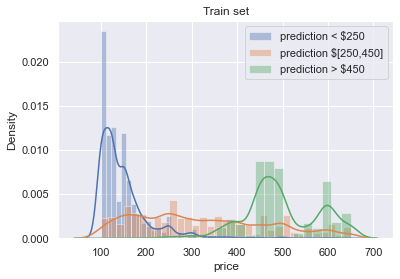

In [797]:
sns.distplot(paintings_df_train['price'].iloc[idx_predictions_below_USD250_train],label='prediction < $250')
sns.distplot(paintings_df_train['price'].iloc[idx_predictions_between_USD250_and_USD450_train],label='prediction $[250,450]')
sns.distplot(paintings_df_train['price'].iloc[idx_predictions_above_USD450_train],label='prediction > $450')
plt.legend();
plt.title('Train set');
plt.savefig('./Git_exclude/Figures/price_distributions_true_vs_pred_train_by_price_range.png')

In [798]:
#While the price predictor is not that precise in general, and fails to selectively identify paintings in the $250-450 range,
#it at least rarely predicts a high price (>$450) for paintings listed at a low price (<$250), and viceversa

## 11) Demonstration of the finalized ML models (best prediction and nearest neighbors) in action

In [799]:
#This has now been moved to its own notebook 'Local Demo', along with the design of the Bokeh App which was eventually deployed

## 12) Models using the mean colors in the painting as provided by Etsy (which may or may not be accurate)

### The models below are preliminary work for future versions of the model integrating also the image information 

### Model 12a) Linear regression using only mean image features

In [ ]:
image_mean_selector = ColumnTransformer([
    ('image_mean', 'passthrough', image_columns),
], remainder='drop')

In [ ]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

image_mean_preproc_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('minmax scaling', MinMaxScaler()),
])

In [ ]:
from sklearn.linear_model import LinearRegression

meanimage_linreg_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [ ]:
#Train the model
meanimage_linreg_pipe.fit(paintings_df_train,prices_train);

In [ ]:
#Predict prices on training set:
prices_train_pred = meanimage_linreg_pipe.predict(paintings_df_train)

In [ ]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_train,prices_train)

In [ ]:
#Predict prices on test set:
prices_test_pred = meanimage_linreg_pipe.predict(paintings_df_test)

In [ ]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_test,prices_test)

In [ ]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only mean image info')

### Model 12b) Polynomial regression using only mean image features

In [ ]:
from sklearn.linear_model import Ridge

meanimage_polyreg_ridge_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [ ]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
meanimage_polyreg_ridge_CVmodel = GridSearchCV(meanimage_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [ ]:
#Train the model
meanimage_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

In [ ]:
meanimage_polyreg_ridge_CVmodel.best_params_

In [ ]:
#Predict prices on training set:
prices_train_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_train)

In [ ]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

In [ ]:
#Predict prices on test set:
prices_test_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_test)

In [ ]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

In [ ]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial ridge regression model using only mean image info')

In [ ]:
#So it doesn't look like the mean image colors - as provided by Etsy at least - are very useful at all - but let's also try with tree-based models to see if things change

### Model 12c) Decision tree model using only mean image features

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [ ]:
# #Recall that I already have the image mean selector, which need not change:
# image_mean_selector = ColumnTransformer([
#     ('image_mean', 'passthrough', image_columns),
# ], remainder='drop')

In [ ]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

meanimage_dtree_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [ ]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
meanimage_dtree_CVmodel = GridSearchCV(meanimage_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [ ]:
meanimage_dtree_CVmodel.fit(paintings_df_train,prices_train)

In [ ]:
meanimage_dtree_CVmodel.best_params_['dtree__max_depth']

In [ ]:
#Predict prices on training set:
prices_train_pred = meanimage_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_train,prices_train)

In [ ]:
#Predict prices on test set:
prices_test_pred = meanimage_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_test,prices_test)

In [ ]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only mean image features (provided by Etsy)')


In [ ]:
#it seems that the mean image (at least as provided by Etsy) has basically no predictive power, so there's no need to continue investigating this or to also try random forests
meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

In [ ]:
feature_names_meanimage_dtree = meanimage_dtree_CVmodel.best_estimator_['image mean selector'].get_feature_names()

meanimage_dtree_features_imp_df = pd.DataFrame(meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_meanimage_dtree,columns=['Dtree feature importance'])
meanimage_dtree_features_imp_df = meanimage_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
meanimage_dtree_features_imp_df

In [ ]:
meanimage_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");